# Modeller
All baselines are run on the same test set i.e. a subset of the original data set. 
The baselines included in this script are:
- Random model - choosing and ranking candidates randomly from the test set
- Plain Mergesort model - choosing and ranking candidates from the test set based on best grades in high school
- Mergesort w. gender accountability - choosing and ranking candidates based on high school grades with account equal gender representation (alternating between females and males in the ranking)
- Plain Xgboost regression model -
- Xgboost regression model without sensitive attributes - 

Fair model:
- Xgboost regression model account for diversity 

## Load packages

In [321]:
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
import numpy as np
import random 
from sklearn.utils import shuffle

## Plots setup

In [322]:
def setup_mpl():
    mpl.rcParams["font.family"] = "Helvetica Neue"
    mpl.rcParams["font.size"] = 11
    mpl.rcParams["figure.figsize"] = (14,5)
    mpl.rcParams["figure.dpi"] = 200
    # mpl.rcParams["lines.linewidth"] = 1
setup_mpl()

## Load dataset

TODO: INSERT NEW DF WITH 200 X_test:

In [323]:
df = pd.read_csv("X_test_STRATUM_y_test.csv") 
df = df.drop(["Unnamed: 0"], axis=1).rename(columns = {"Unnamed: 0.1":"Unnamed: 0"})
df_new = pd.read_csv("NEW_X_test_y_test.csv") 
df_new = pd.concat([df_new, df.STRATUM], axis=1)
df = df_new.copy()
# df er nu det, der er lavet på seed 24 og det er baseret på GUDF

# Mergesort Ranker

In [324]:
df_sort = df.sort_values(by="HI_GRADE_AVG", ascending=False, kind="mergesort")

## Gendersort Ranker
Choosing and ranking candidates based on high school grades with account equal gender representation (alternating between females and males in the ranking).

Merge sort for Female df and Male df and append and sort

In [325]:
#Gendersort all
def gender_mergesort_all(df):
    df_temp = df.copy()
    df_M = df_temp[df_temp.GENDER_bin == 0]
    df_F = df_temp[df_temp.GENDER_bin == 1]
    
    df_sort_M = df_M.sort_values(by="HI_GRADE_AVG", ascending=False, kind="mergesort").reset_index()
    df_sort_F = df_F.sort_values(by="HI_GRADE_AVG", ascending=False, kind="mergesort").reset_index()

    if df_F.HI_GRADE_AVG.max() > df_M.HI_GRADE_AVG.max():
        sorted_with_gender = pd.concat([df_sort_F,df_sort_M], sort=False).sort_index()
    else: 
        sorted_with_gender = pd.concat([df_sort_M,df_sort_F], sort=False).sort_index()
    
    return sorted_with_gender.reset_index()
        

gender_df = gender_mergesort_all(df)


# UTILITY:


### Mergesort utility

In [326]:
df_avg = df_sort.copy()

In [327]:
df_avg["incr_col_mean"] = df_avg.COL_GRADE_AVG.expanding().mean()
df_avg["n_students"] = range(1,len(df_avg)+1)

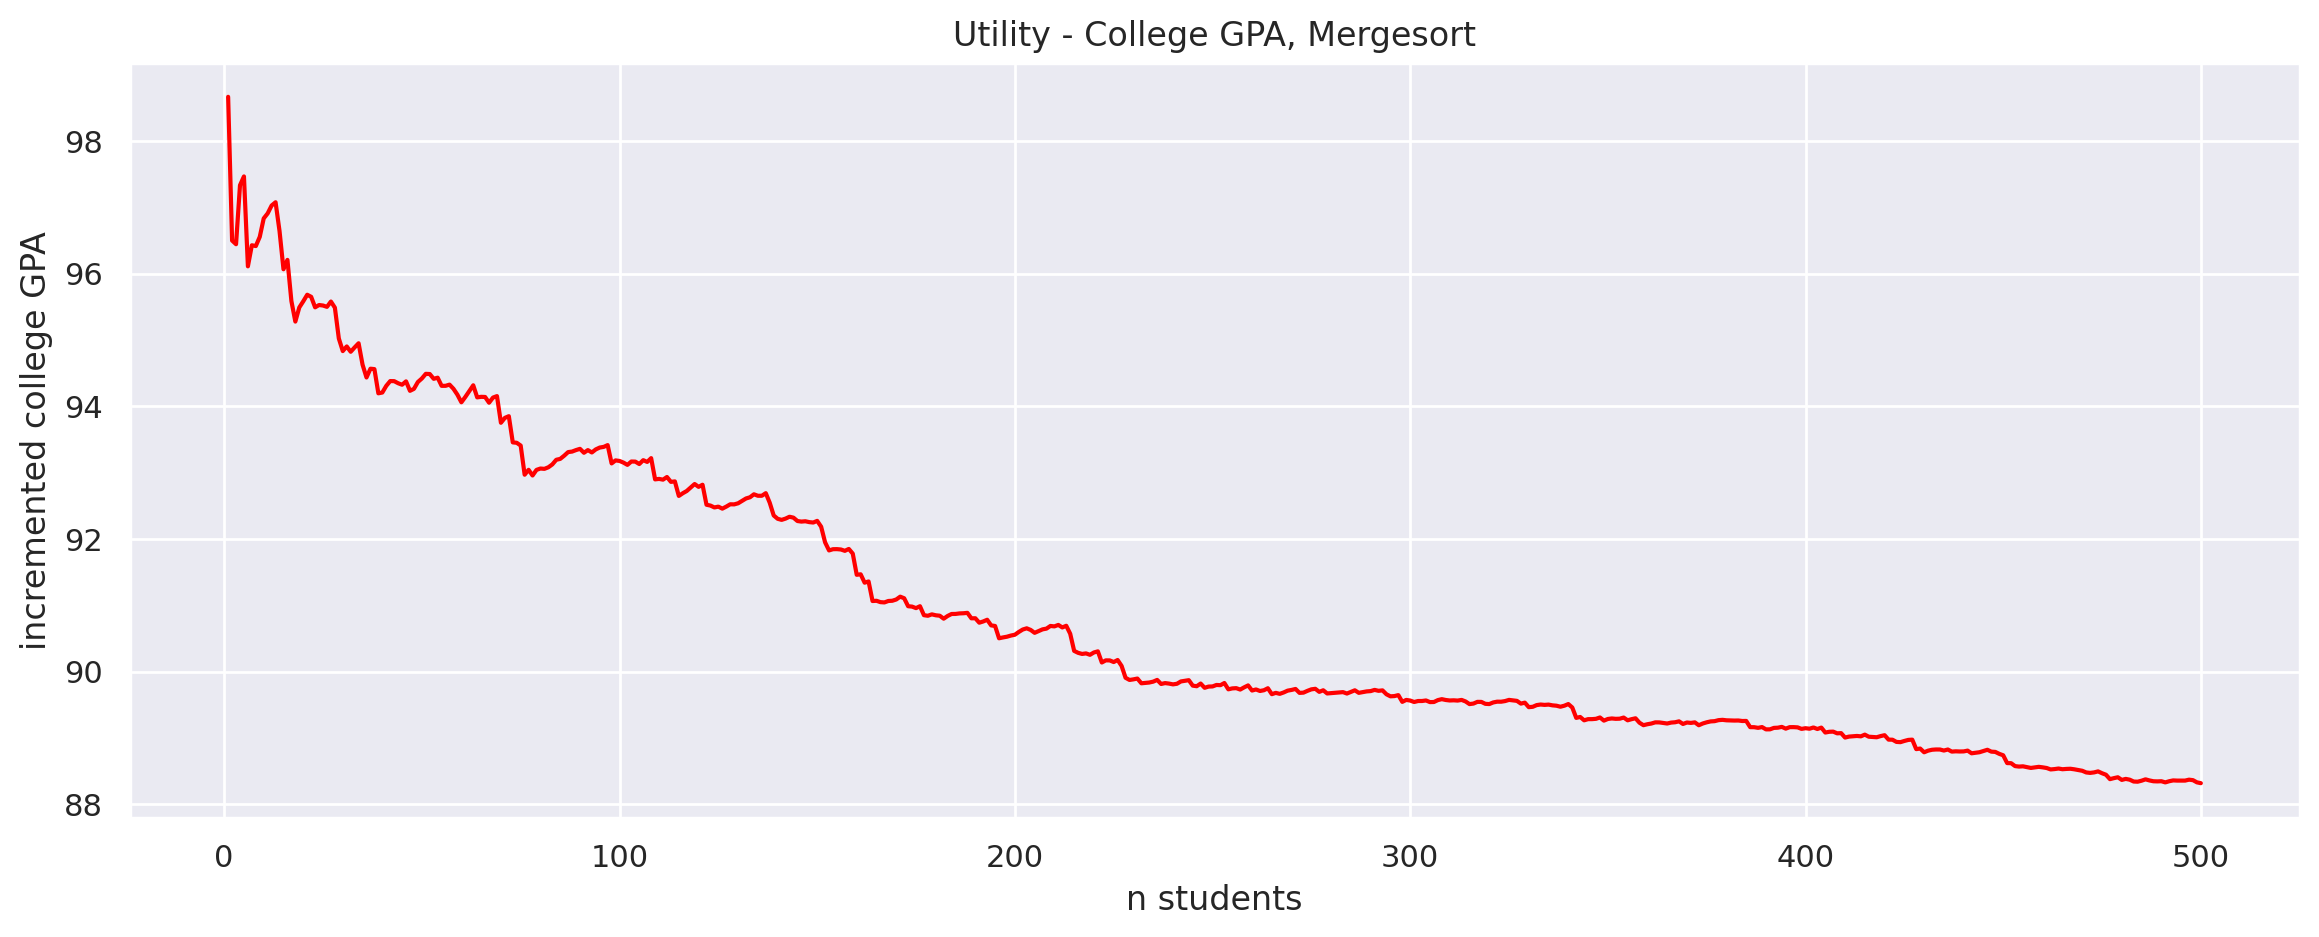

In [328]:
sns.lineplot(x="n_students", y="incr_col_mean", data=df_avg[:500], color="red").set_title("Utility - College GPA, Mergesort")
plt.xlabel('n students')
plt.ylabel('incremented college GPA')
plt.show()

### Gendersort utility


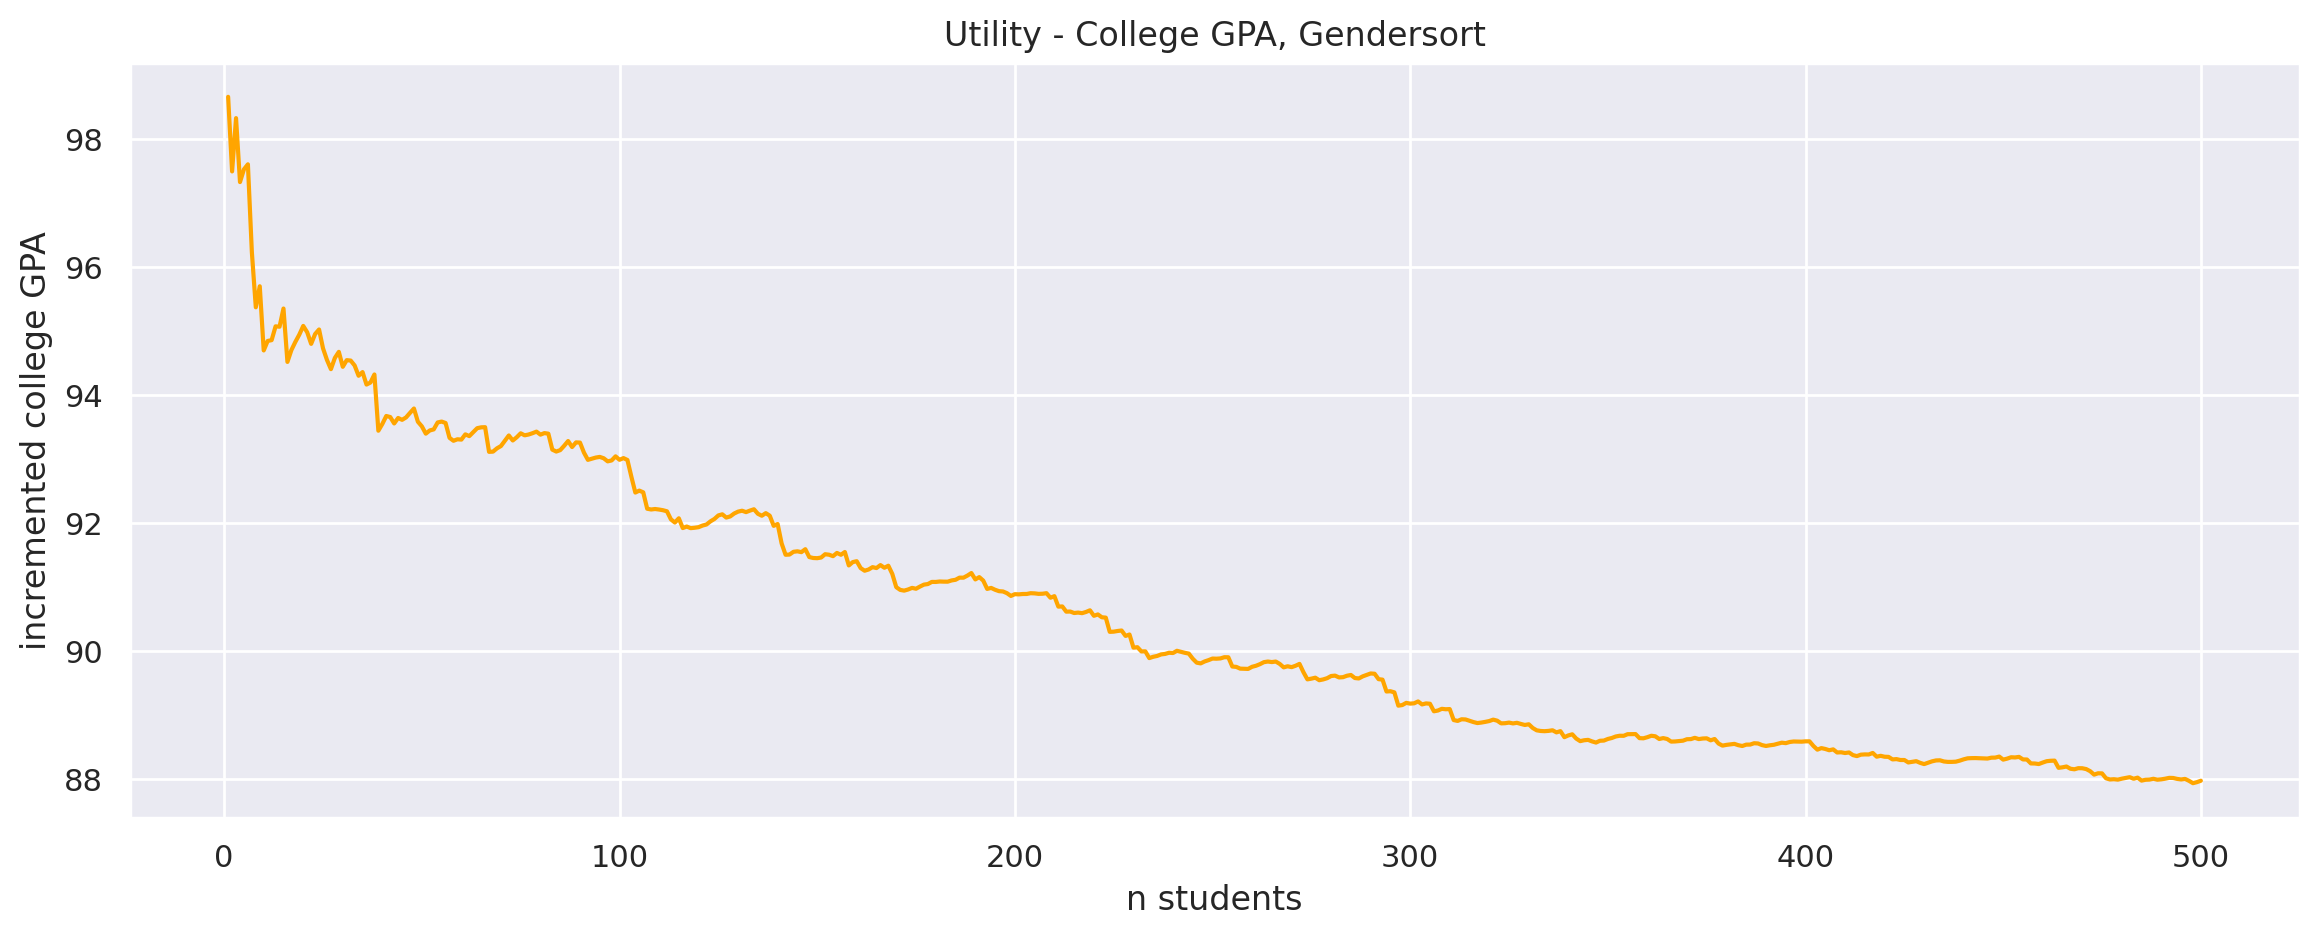

In [329]:
# The gendersort as function of n
#set the incremented col avg as column
gender_df["incr_col_mean"] = gender_df.COL_GRADE_AVG.expanding().mean()
gender_df["n_students"] = range(1,len(gender_df)+1)
# Look of single lineplot of gendersort grades as function of n
sns.lineplot(x="n_students", y="incr_col_mean", data=gender_df[:500], color="orange").set_title("Utility - College GPA, Gendersort")
plt.xlabel('n students')
plt.ylabel('incremented college GPA')
plt.show()

### Random sort utility
2000 samples of random dataframes are generated and plotted with std. as error bars


In [331]:
#Random generated dfs
pd.options.mode.chained_assignment = None 

df_use = df.copy()
df_use = df_use[["Unnamed: 0","COL_GRADE_AVG", "GENDER_bin"]] #"STRATUM"

for j in range(1,2): #first make one random df that we can append the other random dfs to
    gen_state = random.seed(a=None) #random generator
    df_random1 = shuffle(df_use, random_state=gen_state) #shuffle the df with a random generator based on time
    df_random1["incr_col_mean"] = df_random1.COL_GRADE_AVG.expanding().mean()
    df_random1["n_students"] = range(1,len(df_random1)+1)
    for i in range(1000):
        gen_state = random.seed(a=None)
        df_random2 = shuffle(df_use, random_state=gen_state)
        df_random2["incr_col_mean"] = df_random2.COL_GRADE_AVG.expanding().mean()
        df_random2["n_students"] = range(1,len(df_random2)+1)
        df_random1 = df_random1.append(df_random2)
#The random df to use
df_random1

,Unnamed: 0,COL_GRADE_AVG,GENDER_bin,incr_col_mean,n_students
3072,1951,78.666667,0,78.666667,1
1675,1681,20.000000,1,49.333333,2
3259,6476,87.333333,1,62.000000,3
2075,6767,72.666667,1,64.666667,4
467,8686,25.000000,1,56.733333,5
...,...,...,...,...,...
2345,3364,40.666667,0,63.038123,4092
3656,2313,88.666667,0,63.044385,4093
3850,10400,60.666667,1,63.043804,4094
1901,1589,69.333333,0,63.045340,4095


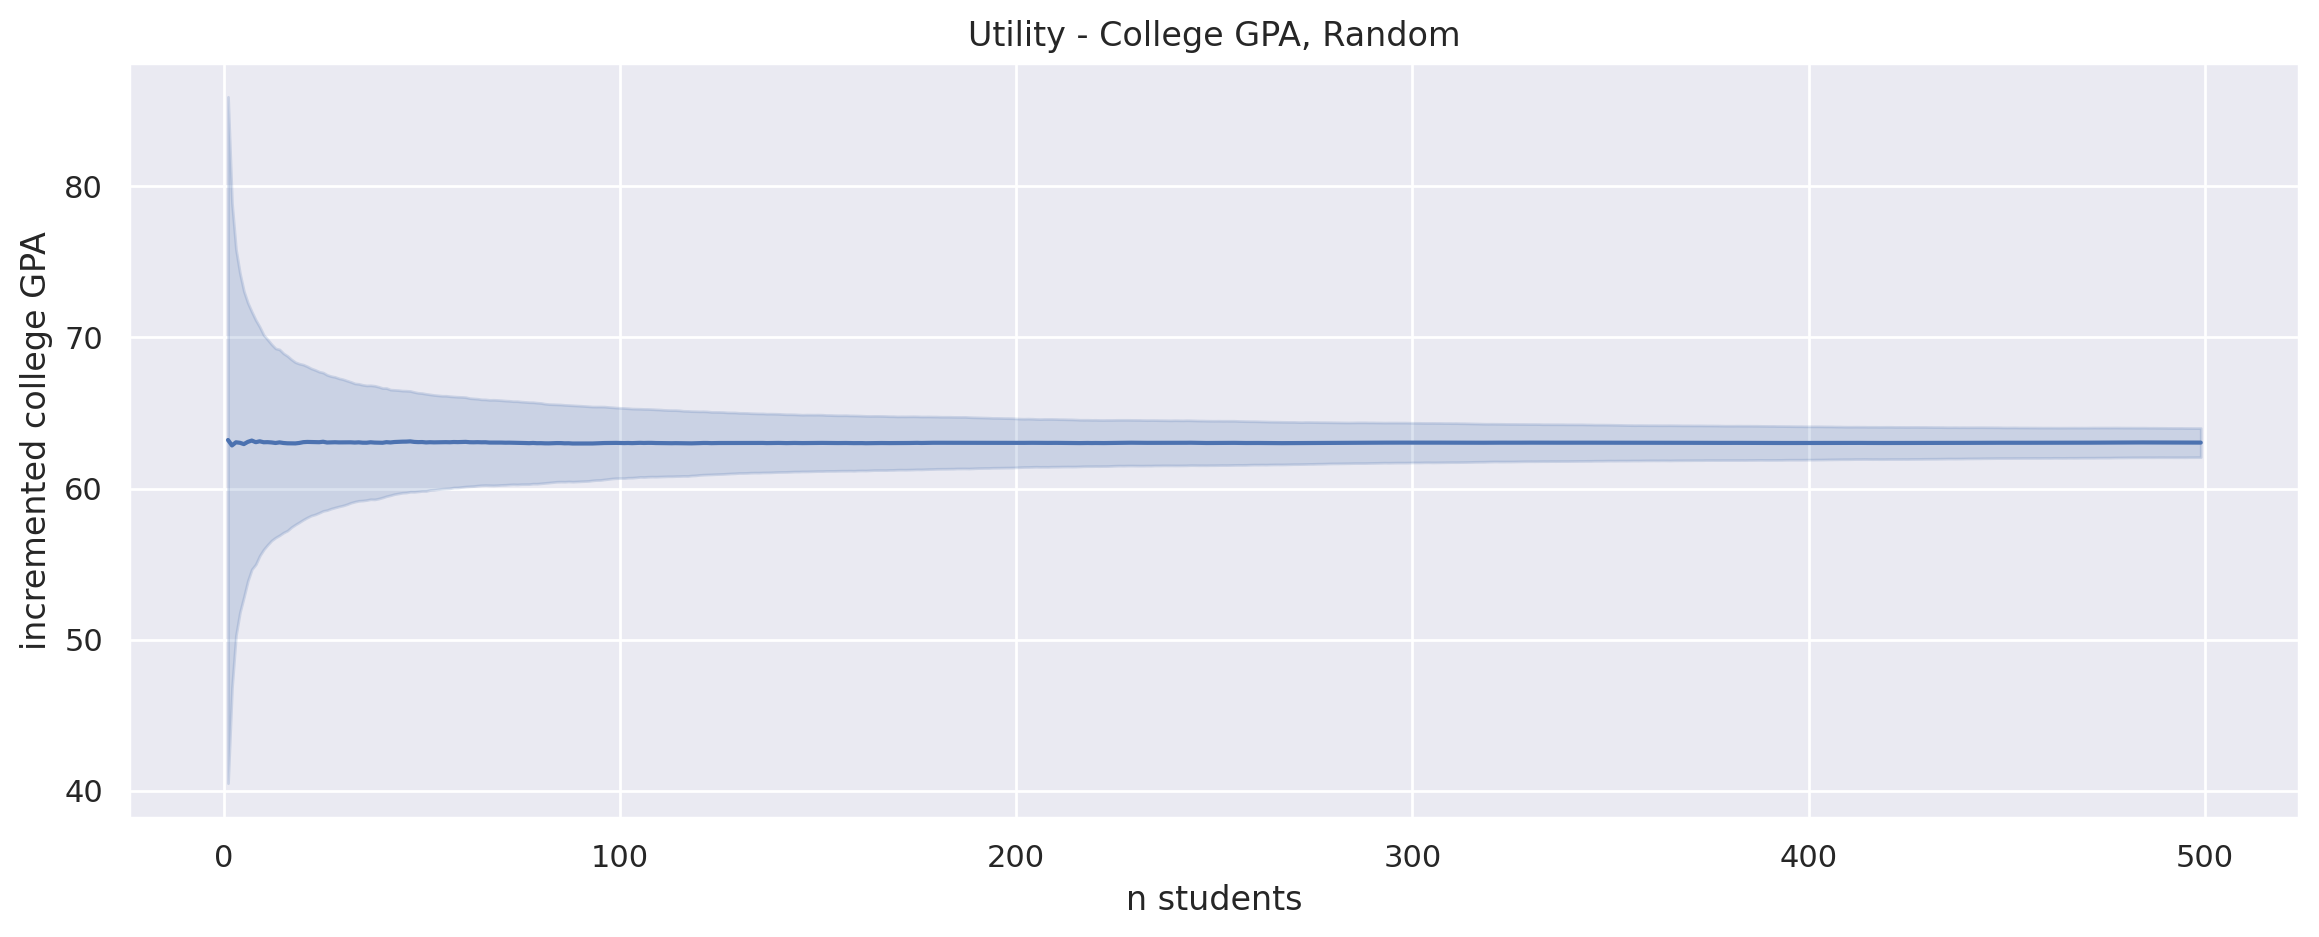

In [332]:


#only take n students from index 1-500
indexs = np.arange(0,500)
df_random_use = df_random1.loc[df_random1['n_students'].isin(indexs)]
df_random_use = df_random_use.reset_index()
#First we plot the random grades per n students
# w 2000 samples
#indexs = np.arange(0,500)
#df_random_use = df_random1.loc[df_random1['n_students'].isin(indexs)]
sns.lineplot(data=df_random_use, x="n_students", y="incr_col_mean", ci="sd")
plt.xlabel('n students')
plt.ylabel('incremented college GPA')
plt.title("Utility - College GPA, Random") 
plt.show()



### Fairness enhanced XGBoost utility 

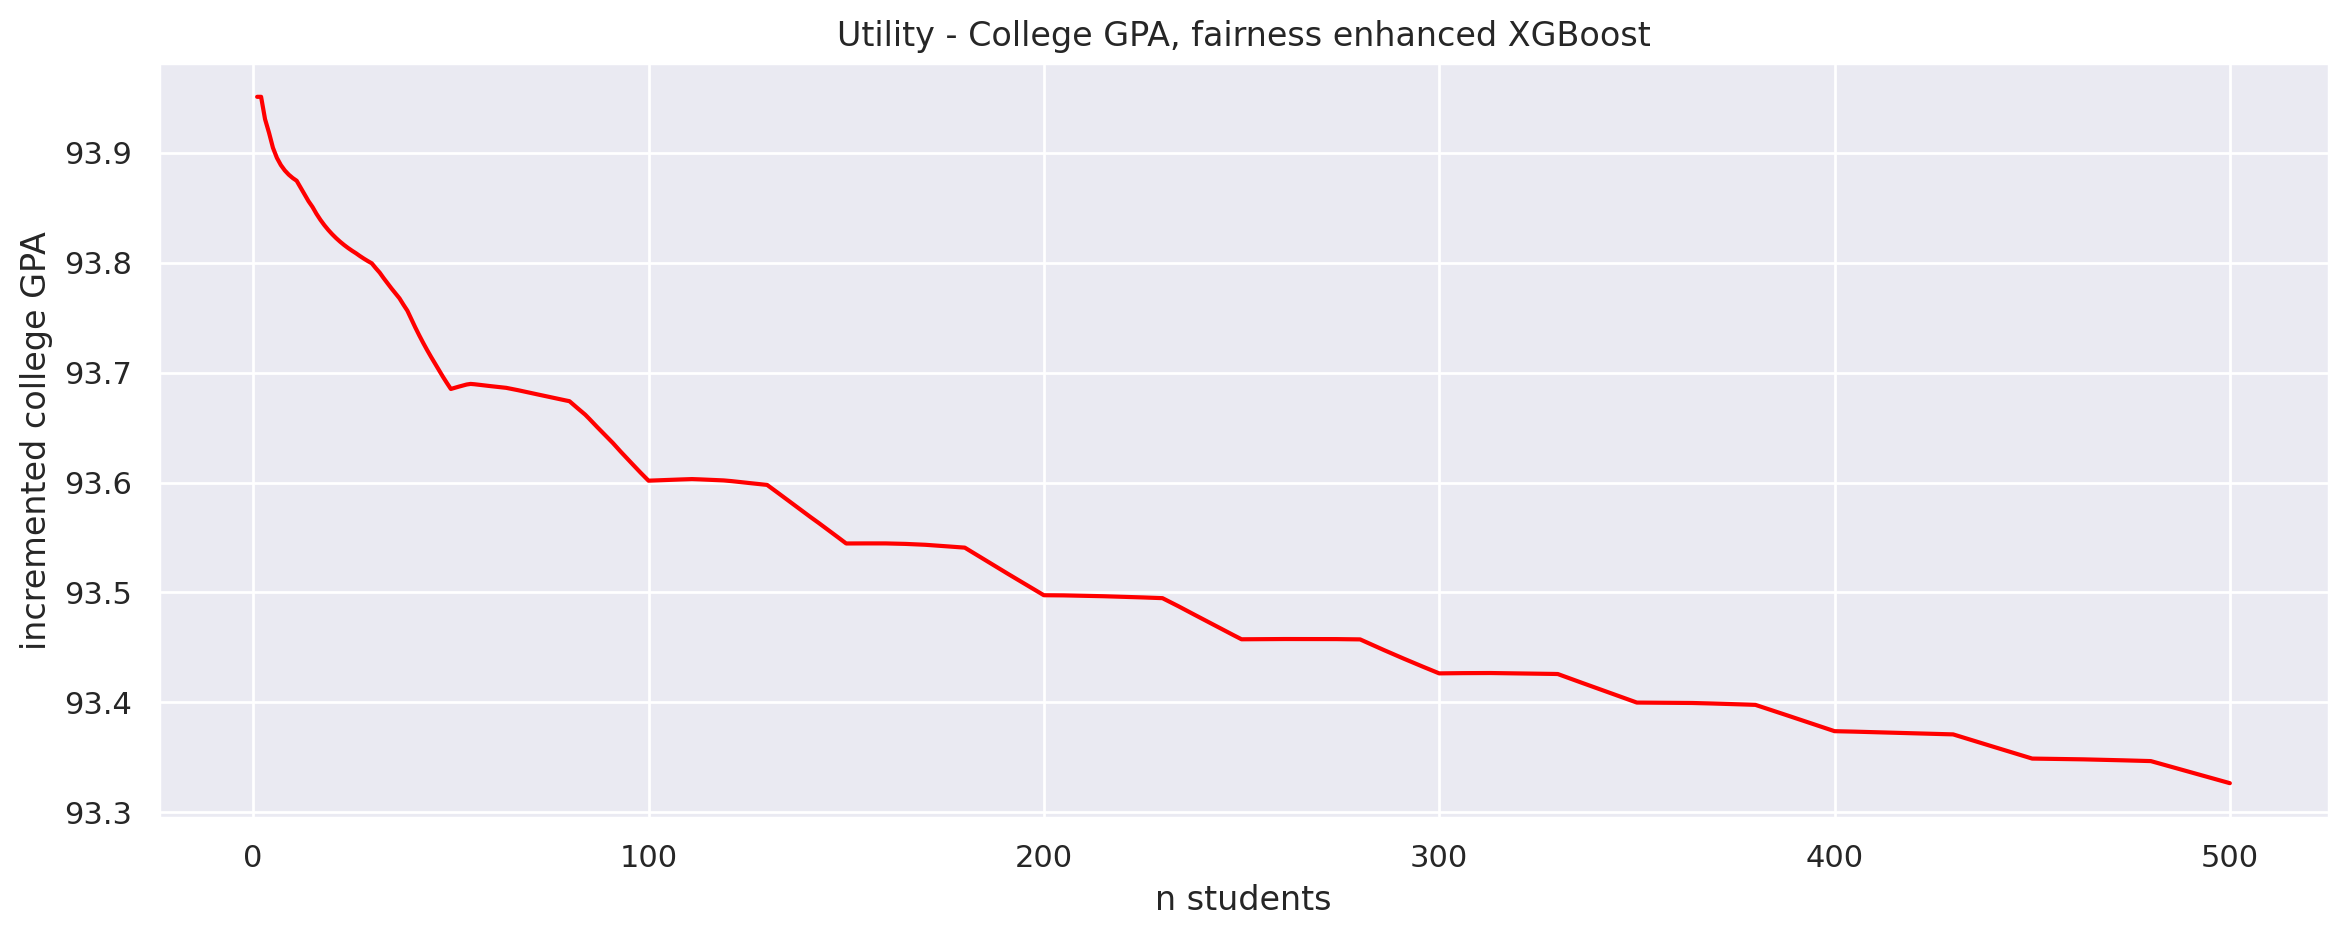

In [333]:
##Re ranked plain UTILITY
df_reR = pd.read_csv('re_ranked_PLAIN.csv').copy()
df_reR["incr_col_mean"] = df_reR.Preds.expanding().mean()
df_reR["n_students"] = range(1,len(df_reR)+1)
sns.lineplot(x="n_students", y="incr_col_mean", data=df_reR[:500], color="red").set_title("Utility - College GPA, fairness enhanced XGBoost")
plt.xlabel('n students')
plt.ylabel('incremented college GPA')
plt.show()

###  Utility: Mergesort, gendersort and random

In [334]:
indexs = np.arange(0,500)
df_random_use_plot = df_random_use.loc[df_random_use['n_students'].isin(indexs)]
df_random_use_plot = df_random_use.reset_index()
df_random_use_plot = df_random_use_plot

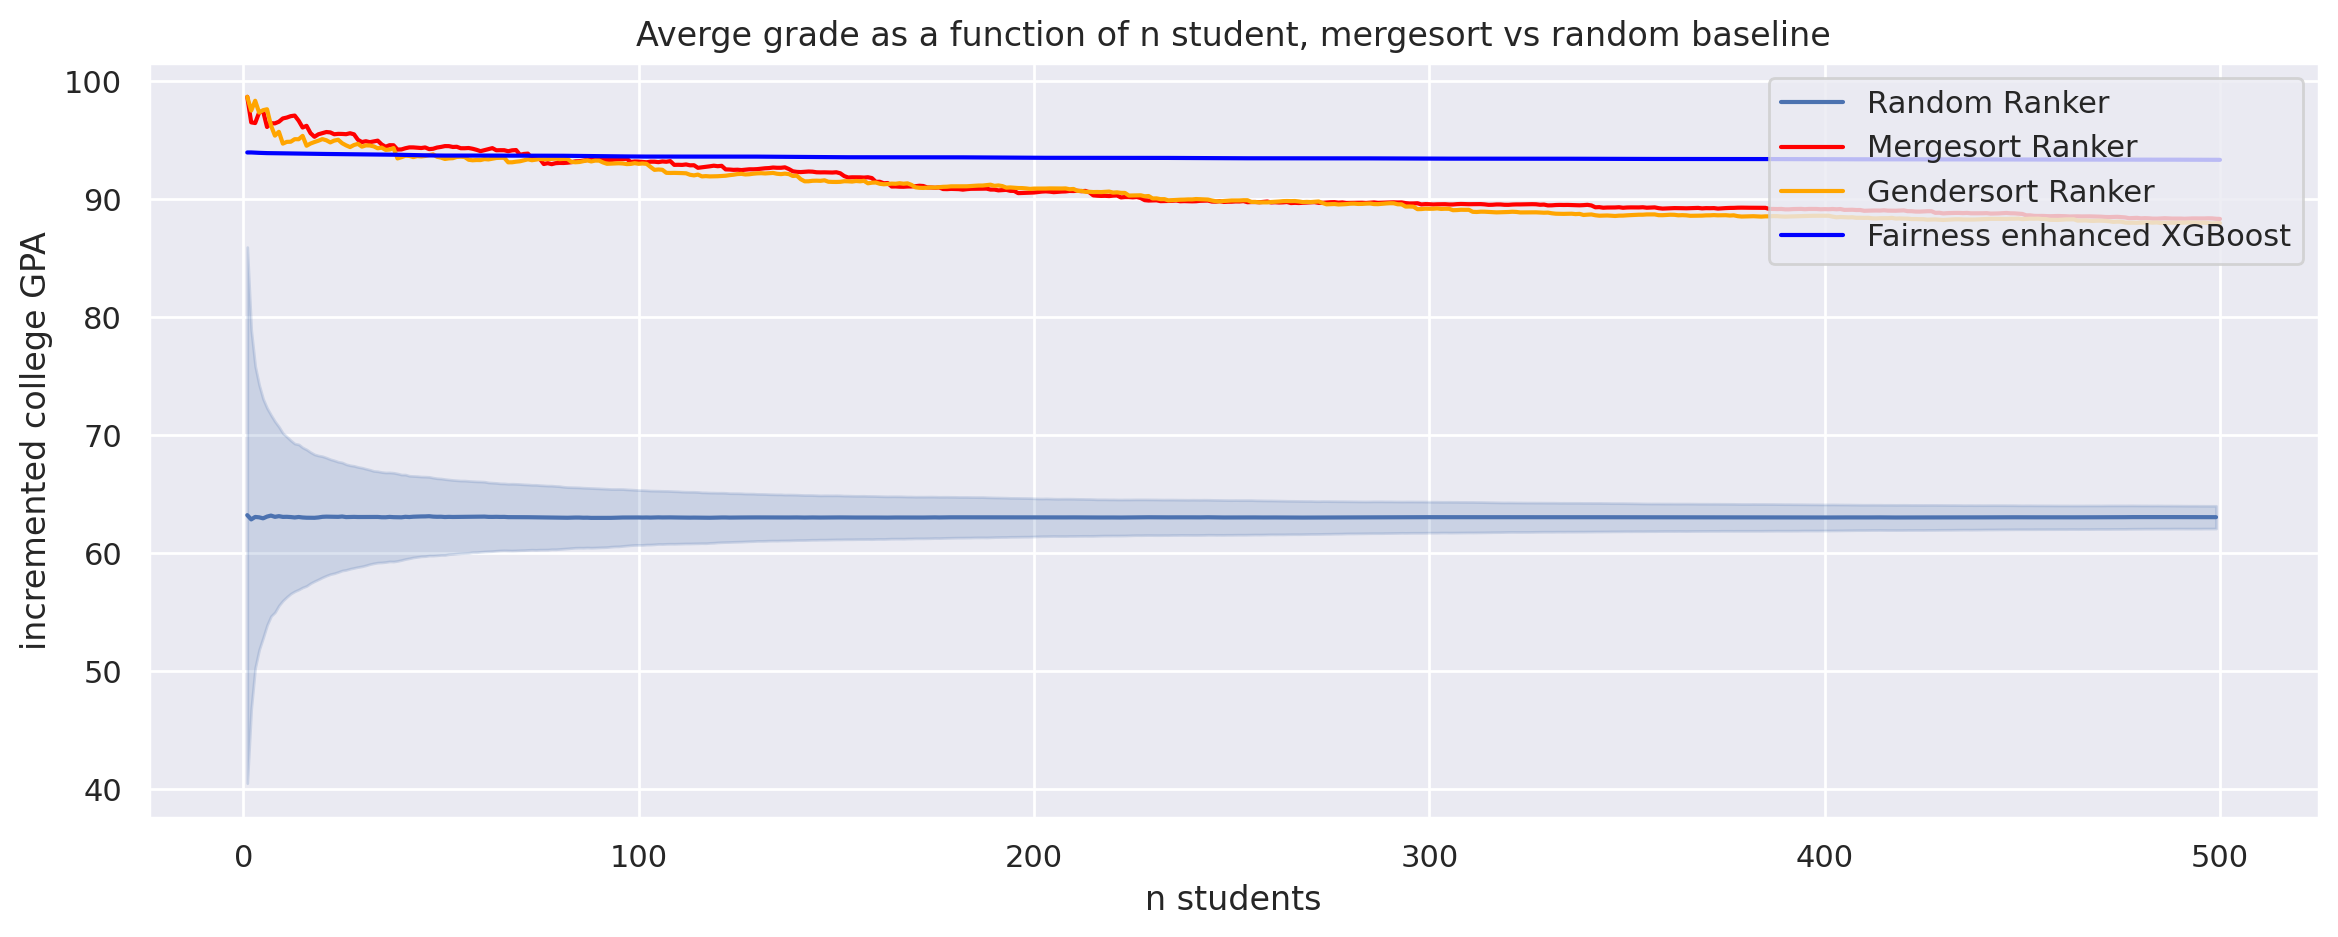

In [335]:
# The random grades per n students together with the gendersorted mergesort grades per n students
sns.lineplot(data=df_random_use_plot, x="n_students", y="incr_col_mean", ci="sd")
sns.lineplot(x="n_students", y="incr_col_mean", data=df_avg[:500], color='red')
sns.lineplot(x="n_students", y="incr_col_mean", data=gender_df[:500], color ='orange')
sns.lineplot(x="n_students", y="incr_col_mean", data=df_reR[:500], color="blue")

plt.xlabel('n students')
plt.ylabel('incremented college GPA')
plt.title("Averge grade as a function of n student, mergesort vs random baseline")
plt.legend(['Random Ranker',"Mergesort Ranker", "Gendersort Ranker", "Fairness enhanced XGBoost"], loc ="upper right")
plt.show()

# TODO: KØR MED de 200 xgb dfs

## Utility: Plain XGBoost 

Using "preds" as College scores for XGBoost

Det skal tjekkes her, hvilken af de 3 grafer, der faktisk er den rigtige. 

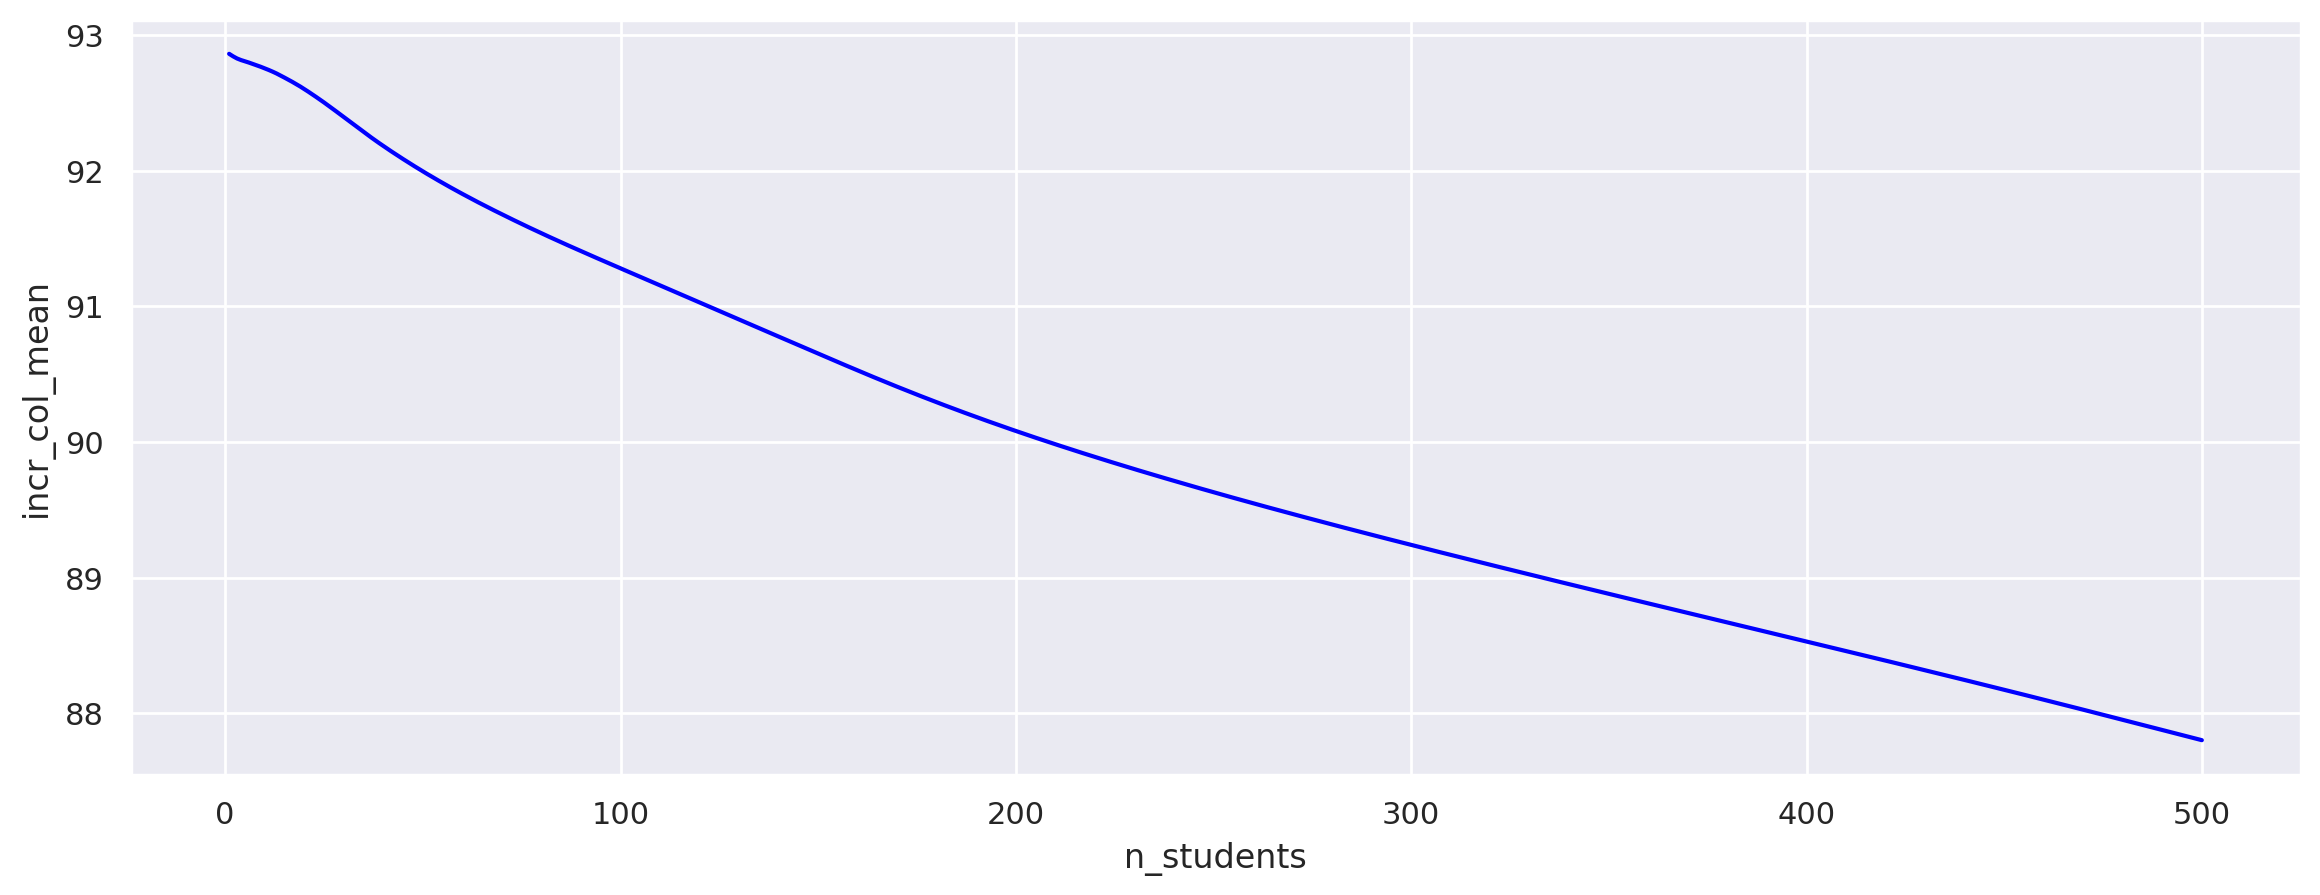

In [336]:
df_plain_TWO = pd.read_csv('TWO_samlet_preds_index_ny_PLAIN.csv')
df_plain_TWO_std = df_plain_TWO.groupby('Unnamed: 0').std()
df_plain_TWO_mean=  df_plain_TWO.groupby('Unnamed: 0').mean()
df_plain_TWO_mean = df_plain_TWO_mean.sort_values(by=['Preds'], ascending=False)
df_plain_TWO_mean["incr_col_mean"] = df_plain_TWO_mean.Preds.expanding().mean()

#cumsum of index to use for plot
df_plain_TWO_mean["n_students"] = range(1,len(df_plain_TWO_mean)+1)
# xgboost 200
Kat_PLAIN_utility = sns.lineplot(data=df_plain_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="blue" , ci="sd")

In [337]:
# Denne herover tager de mean af de 500 førset af hver df i den 200-compiled df TWO_...

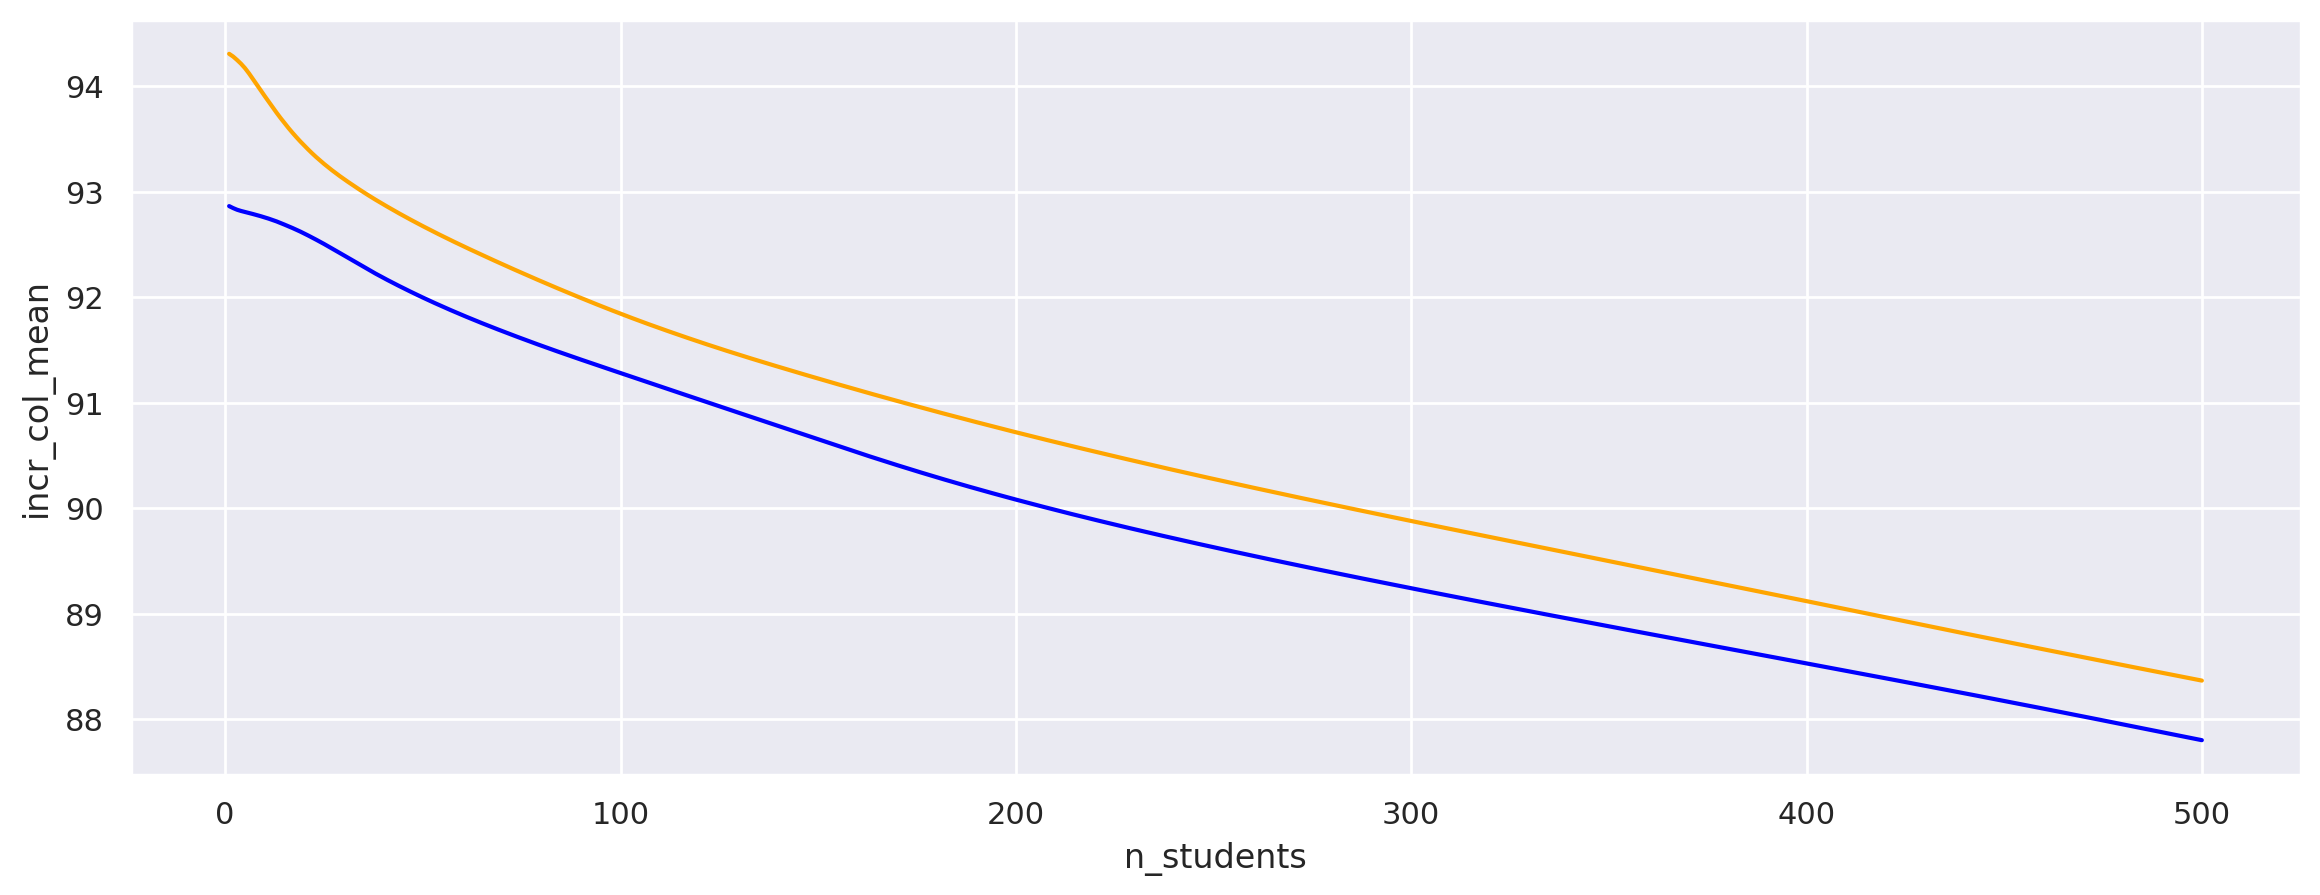

In [338]:
# WO XGBoost

df_wo_TWO = pd.read_csv('TWO_samlet_preds_index_ny_WO.csv')
df_wo_TWO_std = df_wo_TWO.groupby('Unnamed: 0').std()
df_wo_TWO_mean=  df_wo_TWO.groupby('Unnamed: 0').mean()
df_wo_TWO_mean = df_wo_TWO_mean.sort_values(by=['Preds'], ascending=False)
df_wo_TWO_mean["incr_col_mean"] = df_wo_TWO_mean.Preds.expanding().mean()

#cumsum of index to use for plot
df_wo_TWO_mean["n_students"] = range(1,len(df_wo_TWO_mean)+1)

Kat_WO_utility = sns.lineplot(data=df_wo_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="orange" , ci="sd")
Kat_PLAIN_utility = sns.lineplot(data=df_plain_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="blue" , ci="sd")

# Fairness enhanced Ranker on 200 re-rankings

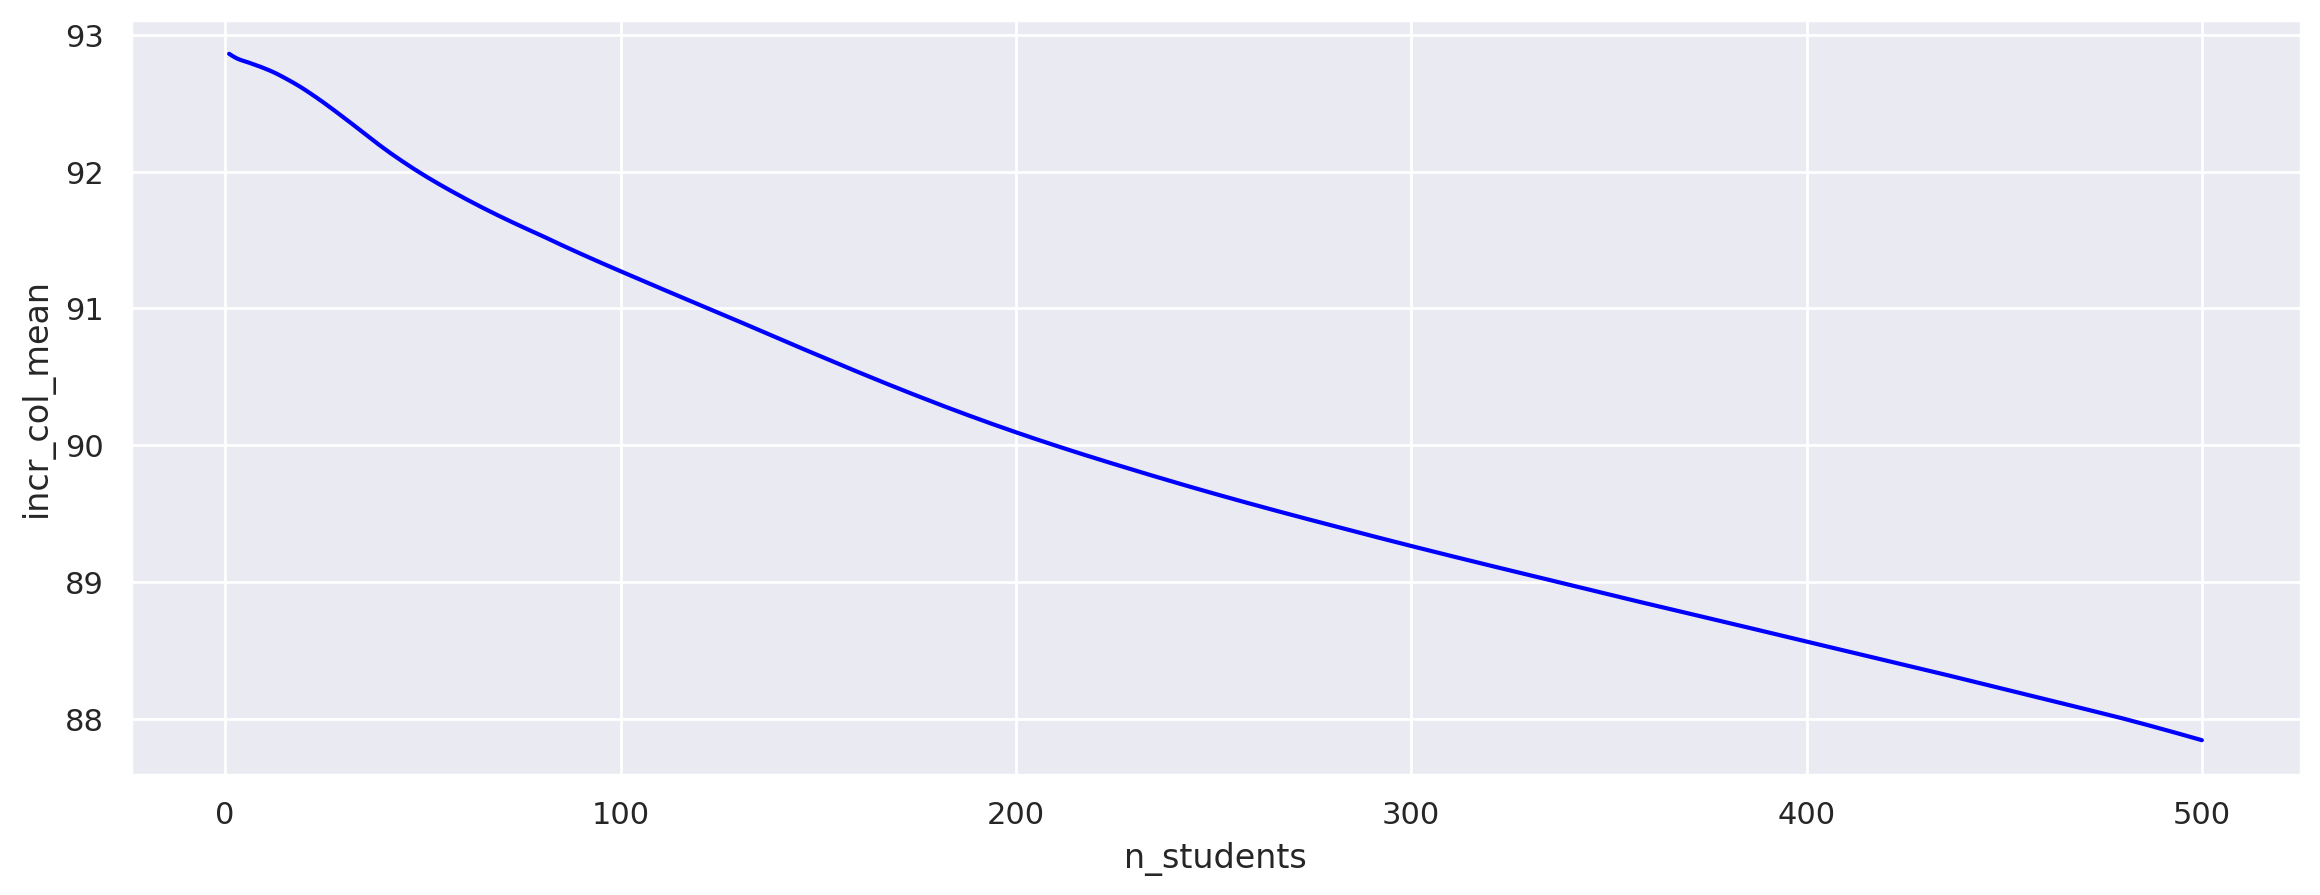

In [339]:
df_fair_TWO = pd.read_csv('re_ranked_199_NY.csv')
df_fair_TWO_std = df_fair_TWO.groupby('Unnamed: 0').std()
df_fair_TWO_mean=  df_fair_TWO.groupby('Unnamed: 0').mean()
df_fair_TWO_mean = df_fair_TWO_mean.sort_values(by=['Preds'], ascending=False)
df_fair_TWO_mean["incr_col_mean"] = df_fair_TWO_mean.Preds.expanding().mean()

#cumsum of index to use for plot
df_fair_TWO_mean["n_students"] = range(1,len(df_fair_TWO_mean)+1)
# xgboost 200
Kat_FAIR_utility = sns.lineplot(data=df_fair_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="blue" , ci="sd")

In [340]:
# XGBOOST with senesitive attributes 
df_xgb_vanilla = pd.read_csv("ONE_samlet_preds_index_ny_PLAIN.csv")
#df_xgb_vanilla = df_xgb_vanilla.rename(columns={"Gender_bins":"GENDER_bin"}) 

# XGBOOST without senesitive attributes 
df_xgb_wo = pd.read_csv("ONE_samlet_preds_index_ny_WO.csv")
df_xgb_wo['Gender_bins'] = df_xgb_wo['Gender_bins'].str.strip('[]').astype(int)
#df_xgb_wo = df_xgb_wo.merge(df_xgb_wo[["GENDER_bin", "Idx"]], on="Idx")
#CHECK 
df["Idx"] = df["Unnamed: 0"]
df_xgb_vanilla = df_xgb_vanilla.merge(df[["Idx", "STRATUM"]], on="Idx")

# XGBOOST without senesitive attributes 
df_xgb_wo = df_xgb_wo.merge(df[["Idx", "STRATUM"]], on="Idx")

### TODO: check når den rigtige fil er loaded

# OBS. TODO: er "Unnamed : 0" studienumre i df

In [341]:
## The preds as function of n
#Vanilla / PLAIN
#set the incremented col avg as column
df_xgb_vanilla["incr_col_mean"] = df_xgb_vanilla.Preds.expanding().mean()

#cumsum of index to use for plot
df_xgb_vanilla["n_students"] = range(1,len(df_xgb_vanilla)+1)


#Without / WO
#set the incremented col avg as column
df_xgb_wo["incr_col_mean"] = df_xgb_wo.Preds.expanding().mean()

#cumsum of index to use for plot
df_xgb_wo["n_students"] = range(1,len(df_xgb_wo)+1)

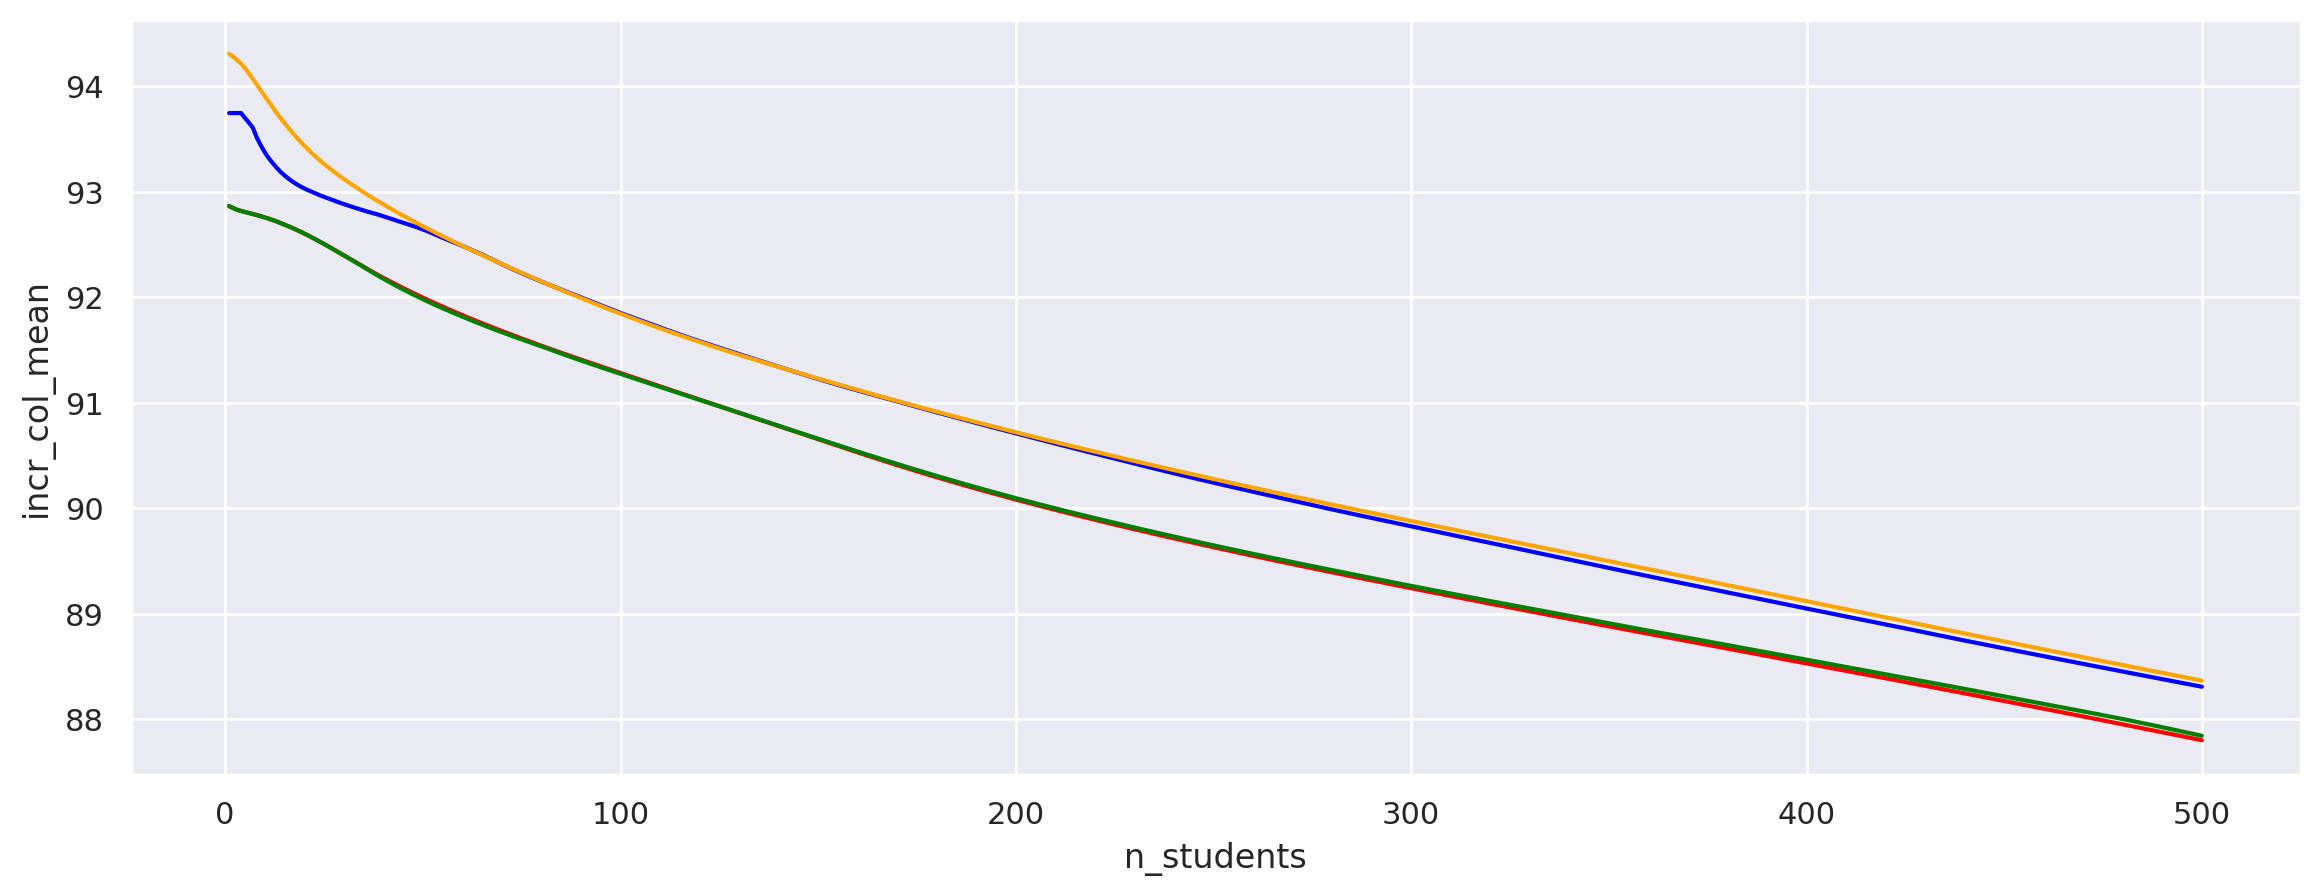

In [342]:
## TODO: herunder er lavet til 200 dfs - brug den df

#import df from xgboost
df_plain = df_xgb_vanilla
#only take n students from index 1-500
indexs = np.arange(0,500) # Dette gøres så vi kun 
#df_plain["n_students"] = range(len(df_plain))
df_plain_use = df_plain.loc[df_plain['Unnamed: 0'].isin(indexs)]
df_plain_use = df_plain_use.reset_index()


#set the incremented col avg as column
df_plain_use["incr_col_mean"] = df_plain_use.Preds.expanding().mean()

#cumsum of index to use for plot
df_plain_use["n_students"] = range(1,len(df_plain_use)+1)

# xgboost 200
sns.lineplot(data=df_plain_use, x="n_students", y="incr_col_mean",  color="blue" , ci="sd")
# sns.lineplot(data=df_plain_use, x="Unnamed: 0", y="Preds",  color="cornflowerblue" , ci="sd")
sns.lineplot(data=df_plain_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="red" , ci="sd")
sns.lineplot(data=df_wo_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="orange" , ci="sd")
Kat_FAIR_utility = sns.lineplot(data=df_fair_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="green" , ci="sd")


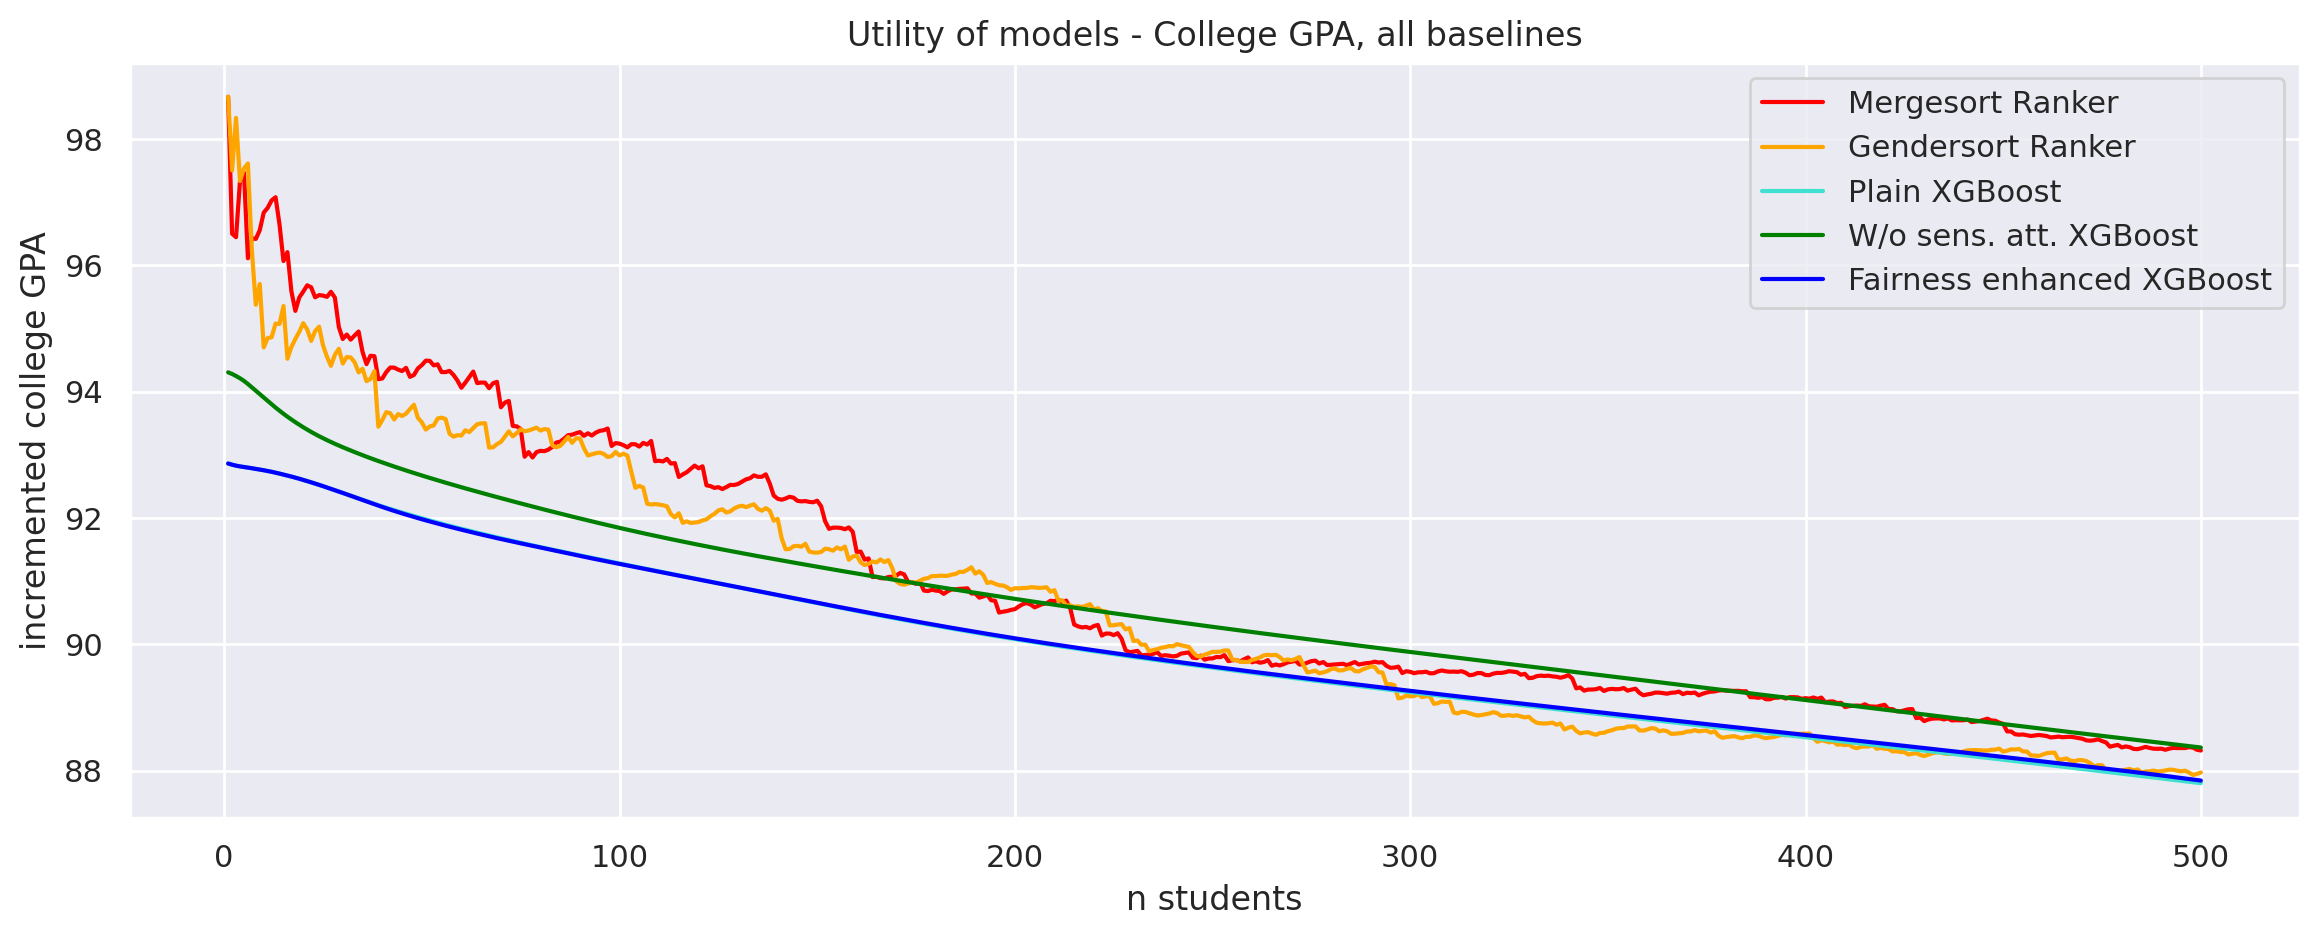

In [343]:
# The random grades per n students together with the gendersorted mergesort grades per n students

sns.lineplot(x="n_students", y="incr_col_mean", data=df_avg[:500], color='red')
sns.lineplot(x="n_students", y="incr_col_mean", data=gender_df[:500], color ='orange')
#sns.lineplot(data=df_random_use, x="n_students", y="incr_col_mean", ci="sd")

# sns.lineplot(x="n_students", y="incr_col_mean", data=df_xgb_vanilla[:500], color="turquoise")
sns.lineplot(data=df_plain_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="turquoise" , ci="sd")

# sns.lineplot(x="n_students", y="incr_col_mean", data=df_xgb_wo[:500], color ="green")
Kat_WO_utility = sns.lineplot(data=df_wo_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="green" , ci="sd")

# sns.lineplot(x="n_students", y="incr_col_mean", data=df_reR[:500], color="blue")
Kat_FAIR_utility = sns.lineplot(data=df_fair_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="blue" , ci="sd")




plt.xlabel('n students')
plt.ylabel('incremented college GPA')
# plt.title("Averge grade as a function of n student, baselines and XGBoost")
plt.title('Utility of models - College GPA, all baselines')
plt.legend(["Mergesort Ranker", "Gendersort Ranker", "Plain XGBoost", "W/o sens. att. XGBoost", "Fairness enhanced XGBoost"], loc ="upper right")
plt.show()



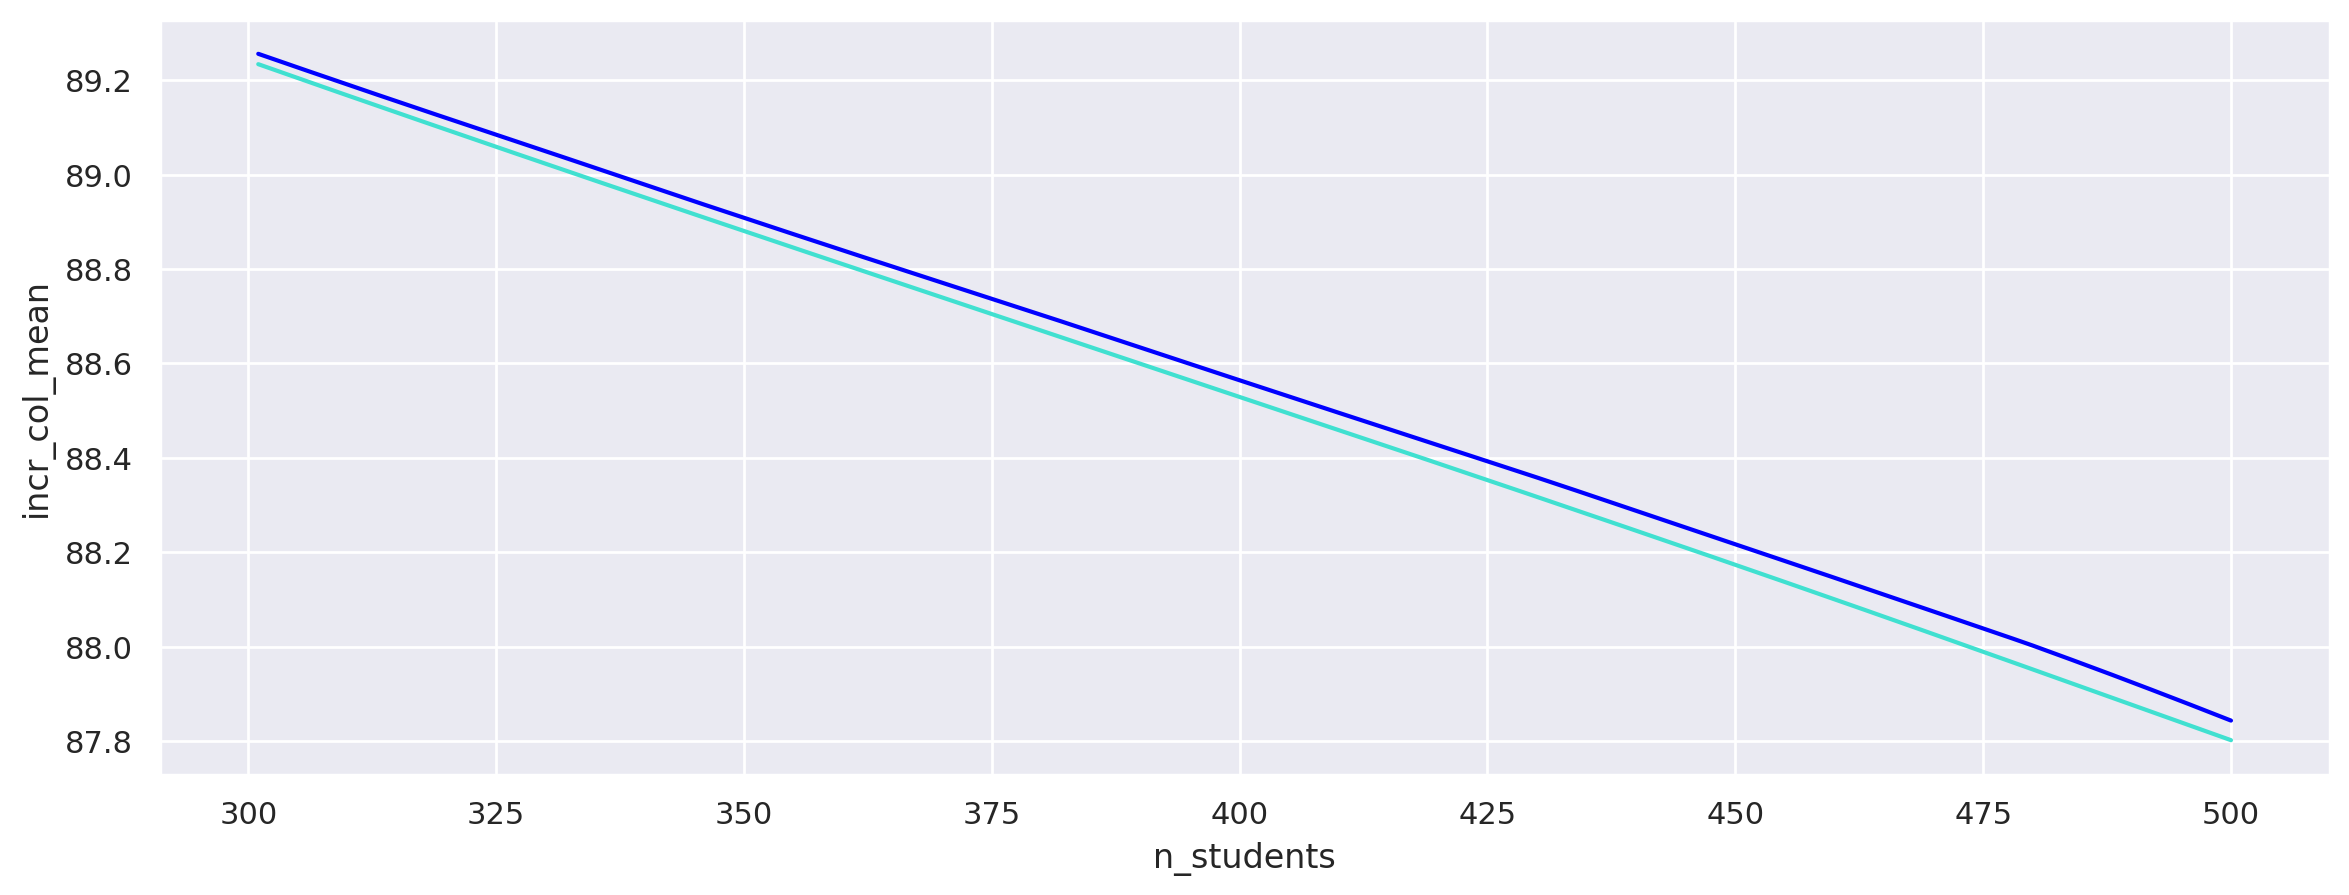

In [344]:
# FAIR vs PLAIN
sns.lineplot(data=df_plain_TWO_mean[300:500], x="n_students", y="incr_col_mean",  color="turquoise", ci="sd")
Kat_FAIR_utility = sns.lineplot(data=df_fair_TWO_mean[300:500], x="n_students", y="incr_col_mean",  color="blue" , ci="sd")


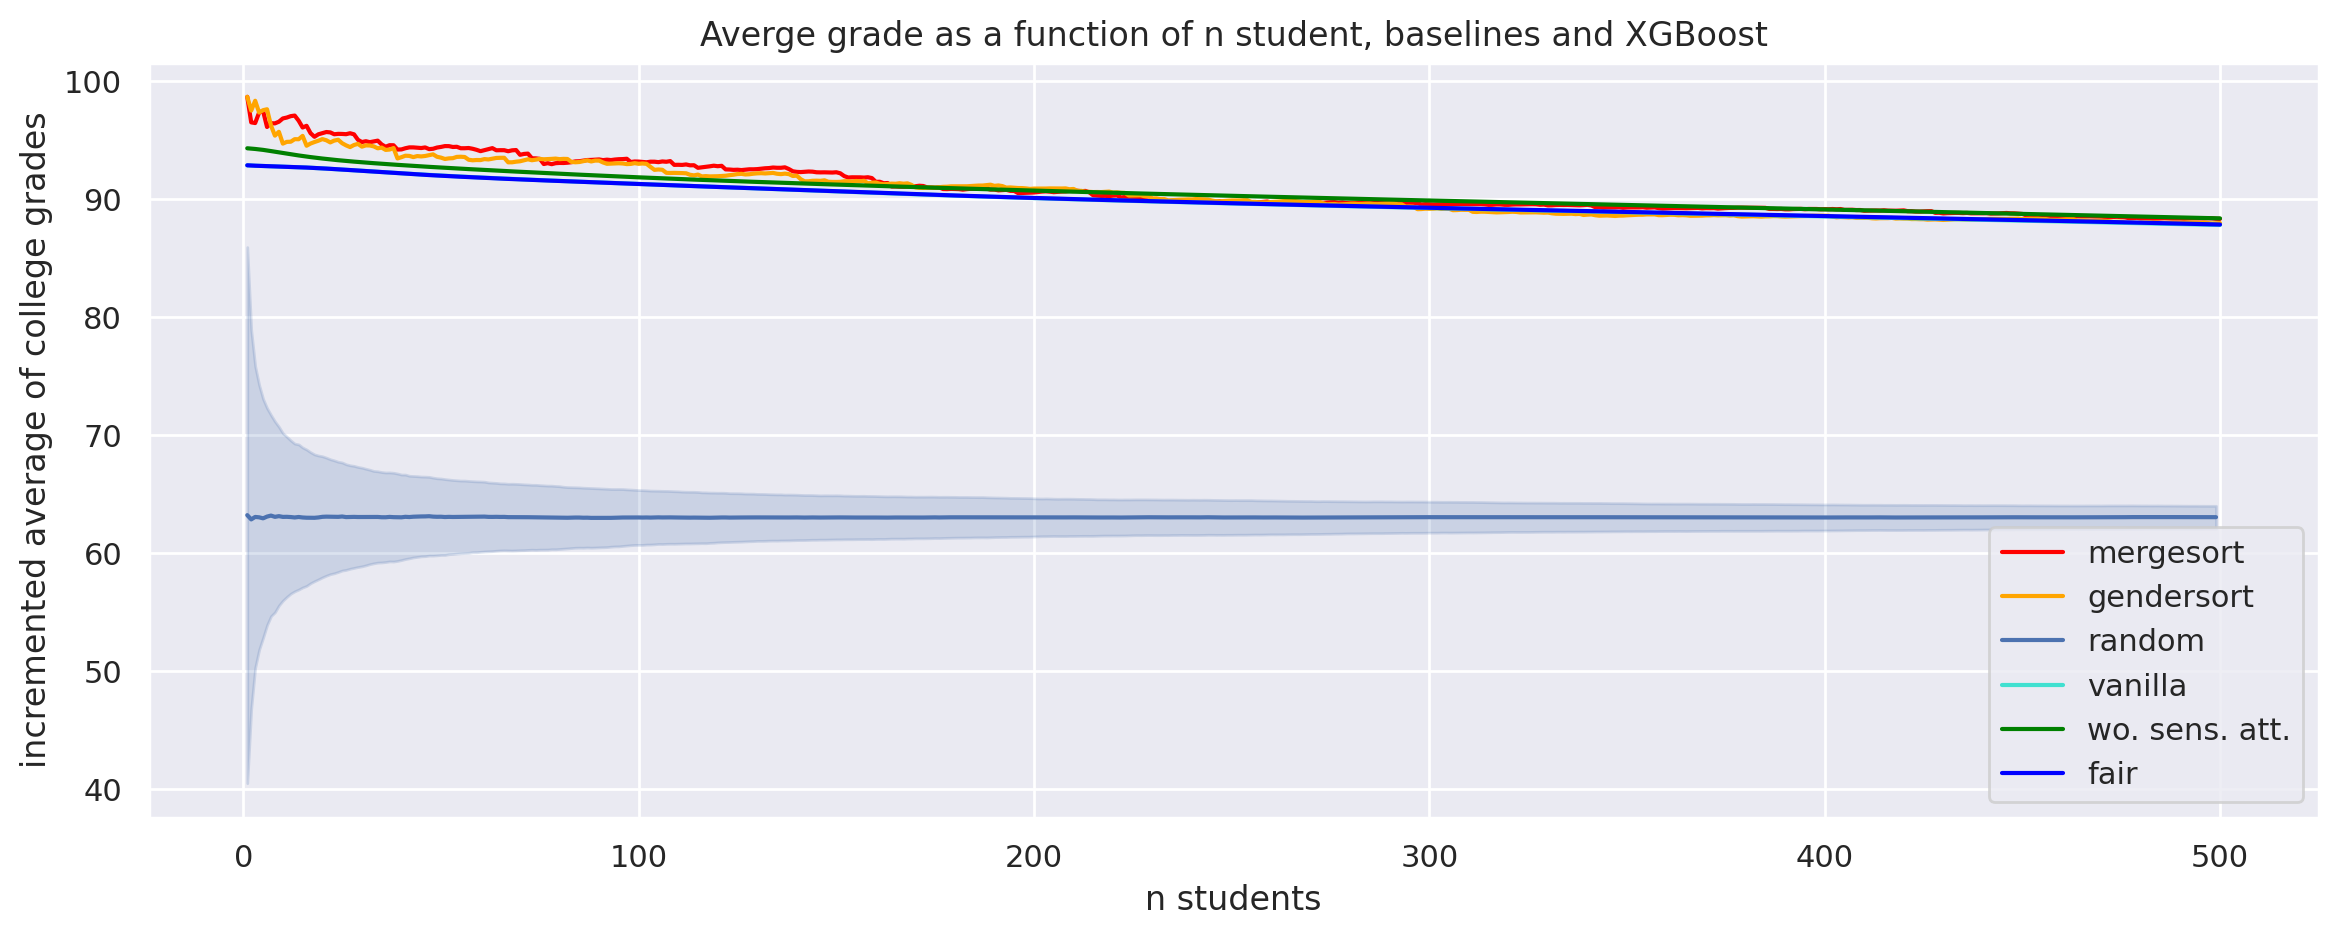

In [345]:
# The random grades per n students together with the gendersorted mergesort grades per n students

sns.lineplot(x="n_students", y="incr_col_mean", data=df_avg[:500], color='red')
sns.lineplot(x="n_students", y="incr_col_mean", data=gender_df[:500], color ='orange')
sns.lineplot(data=df_random_use, x="n_students", y="incr_col_mean", ci="sd")
# sns.lineplot(x="n_students", y="incr_col_mean", data=df_xgb_vanilla[:500], color="turquoise")

# sns.lineplot(data=df_plain_use, x="Unnamed: 0", y="Preds",  color="turquoise" , ci="sd")
# sns.lineplot(x="n_students", y="incr_col_mean", data=df_xgb_vanilla[:500], color="turquoise")
Kat_PLAIN_utility = sns.lineplot(data=df_plain_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="turquoise" , ci="sd")

# sns.lineplot(x="n_students", y="incr_col_mean", data=df_xgb_wo[:500], color ="green")
Kat_WO_utility = sns.lineplot(data=df_wo_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="green" , ci="sd")

# sns.lineplot(x="n_students", y="incr_col_mean", data=df_reR[:500], color="blue")
Kat_FAIR_utility = sns.lineplot(data=df_fair_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="blue" , ci="sd")


plt.xlabel('n students')
plt.ylabel('incremented average of college grades')
plt.title("Averge grade as a function of n student, baselines and XGBoost")
plt.legend(["mergesort", "gendersort", "random", "vanilla", "wo. sens. att.", "fair"], loc ="lower right")
plt.show()

# Entropy as a function of *n* 
Using the Shannon entropy from https://en.wikipedia.org/wiki/Diversity_index:
$H^{\prime}=-\sum_{i=1}^{R} p_{i} \ln p_{i}$.

# Gender entropy

In this case *i* = {M, F}. I.e. $p_{i}$ is the ratio of either M or F in the given sample.
Log base 2 is used, as M and F are binary input, also described in (https://en.wikipedia.org/wiki/Diversity_index).


Afterwards entropy of gender-stratum pair is computed.

### Mergesort, gender entropy

In [346]:
# Reset index of merge sort
df_sort = df_sort.reset_index()
#For each row incremented, get ratio of M and F
data_value_counts_gen = []
for i in range(1,len(df_sort)+1):
    data_value_counts_gen.append(np.array([df_sort["GENDER_bin"][:i].value_counts(normalize=True)]))
#Create new column with the ratios
df_sort["value_counts_col_GENDER"] = data_value_counts_gen
#For each row incremented, get entropy 
data_entropy = []
for i in range(len(df_sort)):
    data_entropy.append(-(df_sort["value_counts_col_GENDER"][i]*np.log2(df_sort["value_counts_col_GENDER"][i])).sum())
#Create new column with the entropy
df_sort["entropy_col_GENDER"] = data_entropy

### Gendersort, gender entropy

In [347]:
#Value counts/ratio per row

data_value_counts_GENDER = []
for i in range(1,len(gender_df)+1):
    data_value_counts_GENDER.append(np.array([gender_df["GENDER_bin"][:i].value_counts(normalize=True)]))

gender_df["value_counts_col_GENDER"] = data_value_counts_GENDER

#Entropy for each row

data_entropy_GENDER = []
for i in range(len(df_sort)):
    data_entropy_GENDER.append(-(gender_df["value_counts_col_GENDER"][i]*np.log2(gender_df["value_counts_col_GENDER"][i])).sum())    

gender_df["entropy_col_GENDER"] = data_entropy_GENDER


## Random entropy

In [348]:
# #kat prøver random

# random_df = df_random_use
# data_value_counts_GENDER = []
# for i in range(1,len(random_df)+1):
#     data_value_counts_GENDER.append(np.array([random_df["GENDER_bin"][:i].value_counts(normalize=True)]))

# random_df["value_counts_col_GENDER"] = data_value_counts_GENDER

# #Entropy for each row

# data_entropy_GENDER = []
# for i in range(len(random_df)):
#     data_entropy_GENDER.append(-(random_df["value_counts_col_GENDER"][i]*np.log2(random_df["value_counts_col_GENDER"][i])).sum())    

# random_df["entropy_col_GENDER"] = data_entropy_GENDER

### Random, gender entropy

In [349]:
# DENNE VIRKER!!!!

indexs = np.arange(0,500)
df_random_use = df_random1.loc[df_random1['n_students'].isin(indexs)]
df_random_use = df_random_use.reset_index()

random_value_counts_GENDER = []
i = 0
while i < 999:
    idx = 0
    while idx <= df_random_use.n_students.max():
        random_value_counts_GENDER.append(np.array([df_random_use["GENDER_bin"][:idx].value_counts(normalize=True)]))
        idx = idx+1 
    i = i+1


df_random_use["value_counts_col_GENDER"] = random_value_counts_GENDER[1:]


#Entropy for each row

random_entropy_GENDER = []
for i in df_random_use.index:
    random_entropy_GENDER.append(-(df_random_use["value_counts_col_GENDER"][i]*np.log2(df_random_use["value_counts_col_GENDER"][i])).sum())    

df_random_use["entropy_col_GENDER"] = random_entropy_GENDER

KeyboardInterrupt: 

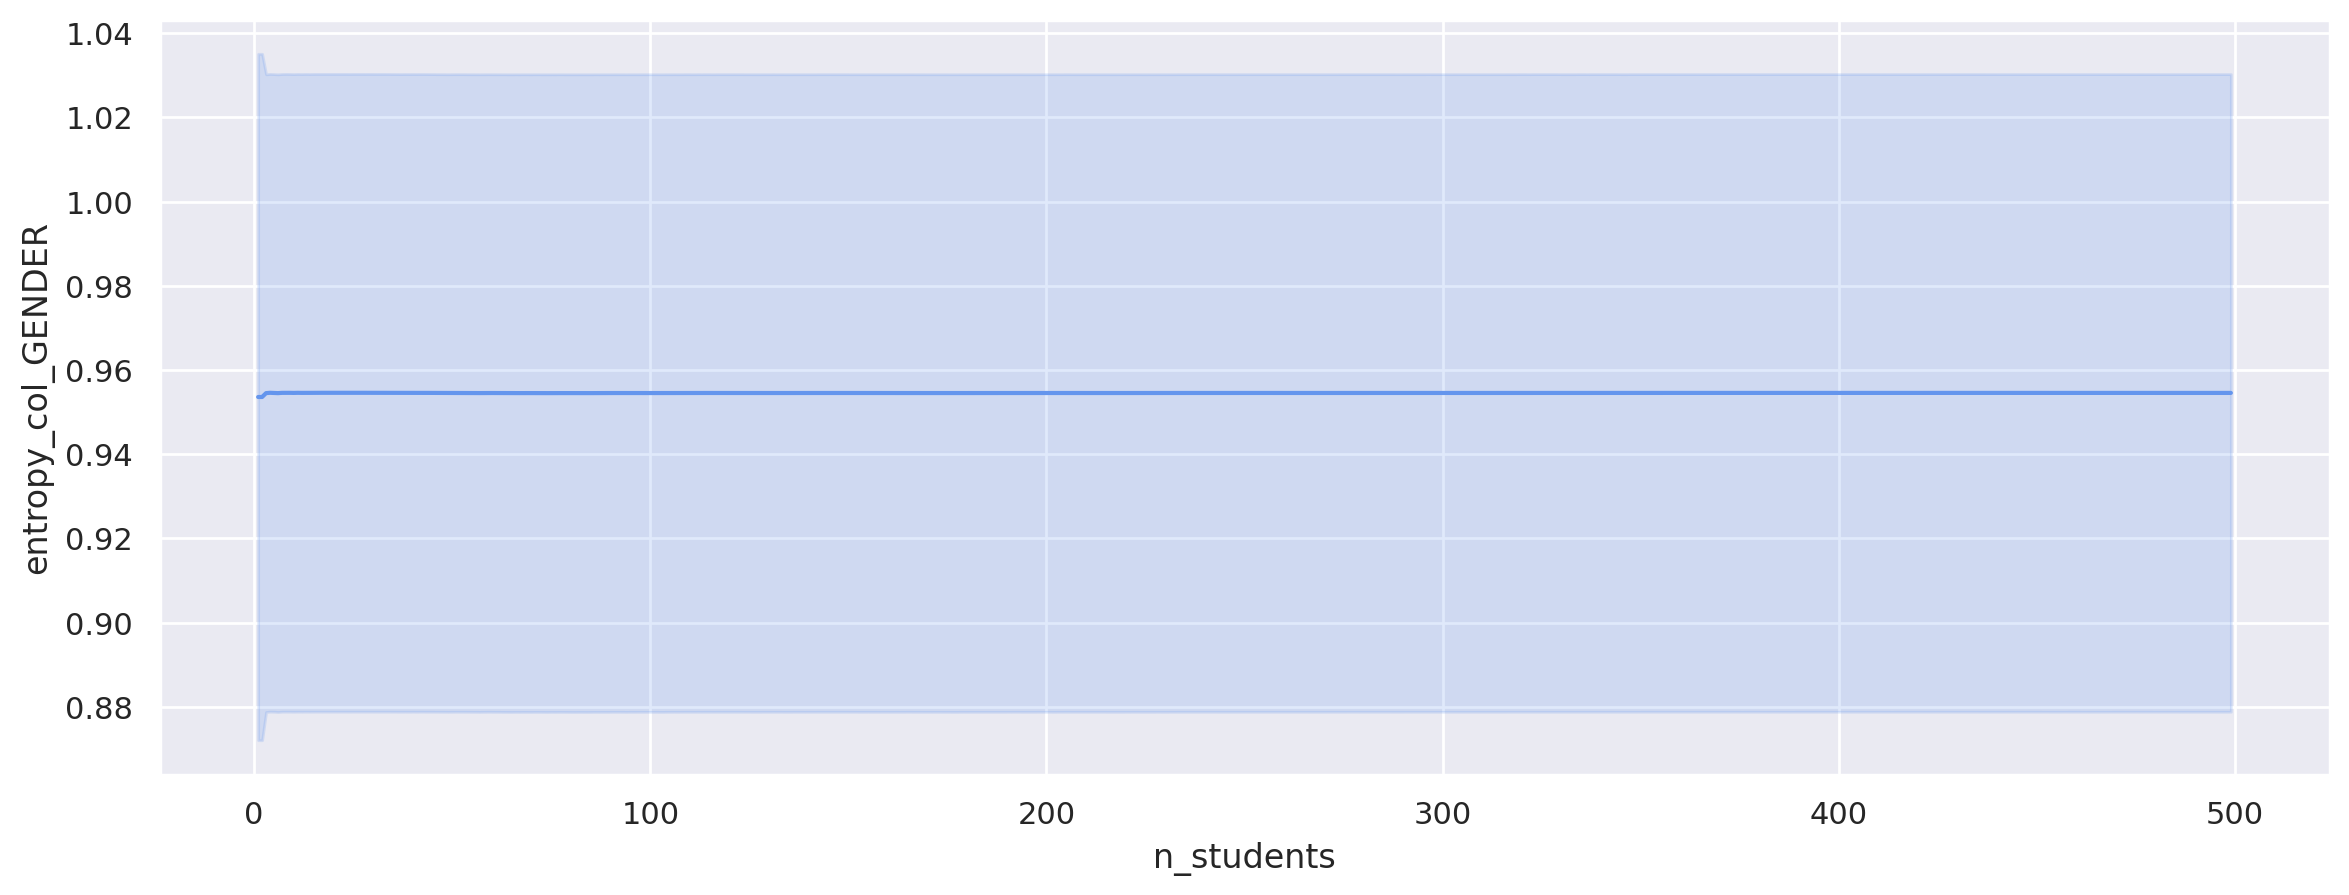

In [ ]:
# random entropy gender

# list of colors: https://matplotlib.org/stable/gallery/color/named_colors.html

df_sort["n_students"] = range(len(df_sort))

sns.color_palette("deep")

# randomsort entropy of gender
sns.lineplot(data=df_random_use, x="n_students", y="entropy_col_GENDER", ci="sd", color="cornflowerblue")
plt.show()


## XGBoost 200 PLAIN Gender entropy


### XGBoost plain and wo. sens., gender entropy

### Gender entropy For 200 dfs

GABI jeg ved altså ikke rigtig om det herunder er rigtigt.

In [ ]:
# # XGBOOST without senesitive attributes 
# df_xgb_wo = pd.read_csv("ONE_samlet_preds_index_ny_WO.csv")
# df_xgb_wo['Gender_bins'] = df_xgb_wo['Gender_bins'].str.strip('[]').astype(int)
# #df_xgb_wo = df_xgb_wo.merge(df_xgb_wo[["GENDER_bin", "Idx"]], on="Idx")
# #CHECK 
# df["Idx"] = df["Unnamed: 0"]
# df_xgb_vanilla = df_xgb_vanilla.merge(df[["Idx", "STRATUM"]], on="Idx")

# # XGBOOST without senesitive attributes 
# df_xgb_wo = df_xgb_wo.merge(df[["Idx", "STRATUM"]], on="Idx")
# df_wo_TWO = pd.read_csv('TWO_samlet_preds_index_ny_WO.csv')
# df_wo_TWO_std = df_wo_TWO.groupby('Unnamed: 0').std()
# df_wo_TWO_mean=  df_wo_TWO.groupby('Unnamed: 0').mean()
# df_wo_TWO_mean = df_wo_TWO_mean.sort_values(by=['Preds'], ascending=False)
# df_wo_TWO_mean["incr_col_mean"] = df_wo_TWO_mean.Preds.expanding().mean()

# #cumsum of index to use for plot
# df_wo_TWO_mean["n_students"] = range(1,len(df_wo_TWO_mean)+1)

In [ ]:
# KAT KØRER HER

df_plain = pd.read_csv('TWO_samlet_preds_index_ny_PLAIN.csv')
#import df from xgboost
# df_plain = pd.read_csv("samlet_preds_index_ny_PLAIN.csv")
#only take n students from index 1-500
indexs = np.arange(0,500)
#df_plain["n_students"] = range(len(df_plain))
df_plain_use = df_plain.loc[df_plain['Unnamed: 0'].isin(indexs)]
df_plain_use = df_plain_use.reset_index()
#apply new column of cumsum+1


#Create new list with standard deviation for each n, 0-499
stds = []
for i in df_plain_use["Unnamed: 0"].unique():
    stds.append(df_plain_use[df_plain_use["Unnamed: 0"] == i].Preds.std())


indexs2 = np.arange(0,500)
df_plain_use = df_plain.loc[df_plain['Unnamed: 0'].isin(indexs)]

df_plain_use = df_plain_use.iloc[:5000]


#value counts for each df in all dfs
plain_value_counts_GENDER = []
i = 0
while i < 10: #iterate over 200 dfs
    idx = 0
    while idx <= df_plain_use["Unnamed: 0"].max(): #iterate over each idx from 0-499 in each df
        plain_value_counts_GENDER.append(np.array([df_plain_use["Gender_bins"][:idx].value_counts(normalize=True)]))
        idx = idx+1 
    i = i+1

df_plain_use["value_counts_col_GENDER"] = plain_value_counts_GENDER


plain_entropy_GENDER = []
for i in df_plain_use["Unnamed: 0"]:
    plain_entropy_GENDER.append(-(df_plain_use["value_counts_col_GENDER"][i]*np.log2(df_plain_use["value_counts_col_GENDER"][i])).sum())    

df_plain_use["entropy_col_GENDER"] = plain_entropy_GENDER

<AxesSubplot:xlabel='Unnamed: 0', ylabel='entropy_col_GENDER'>

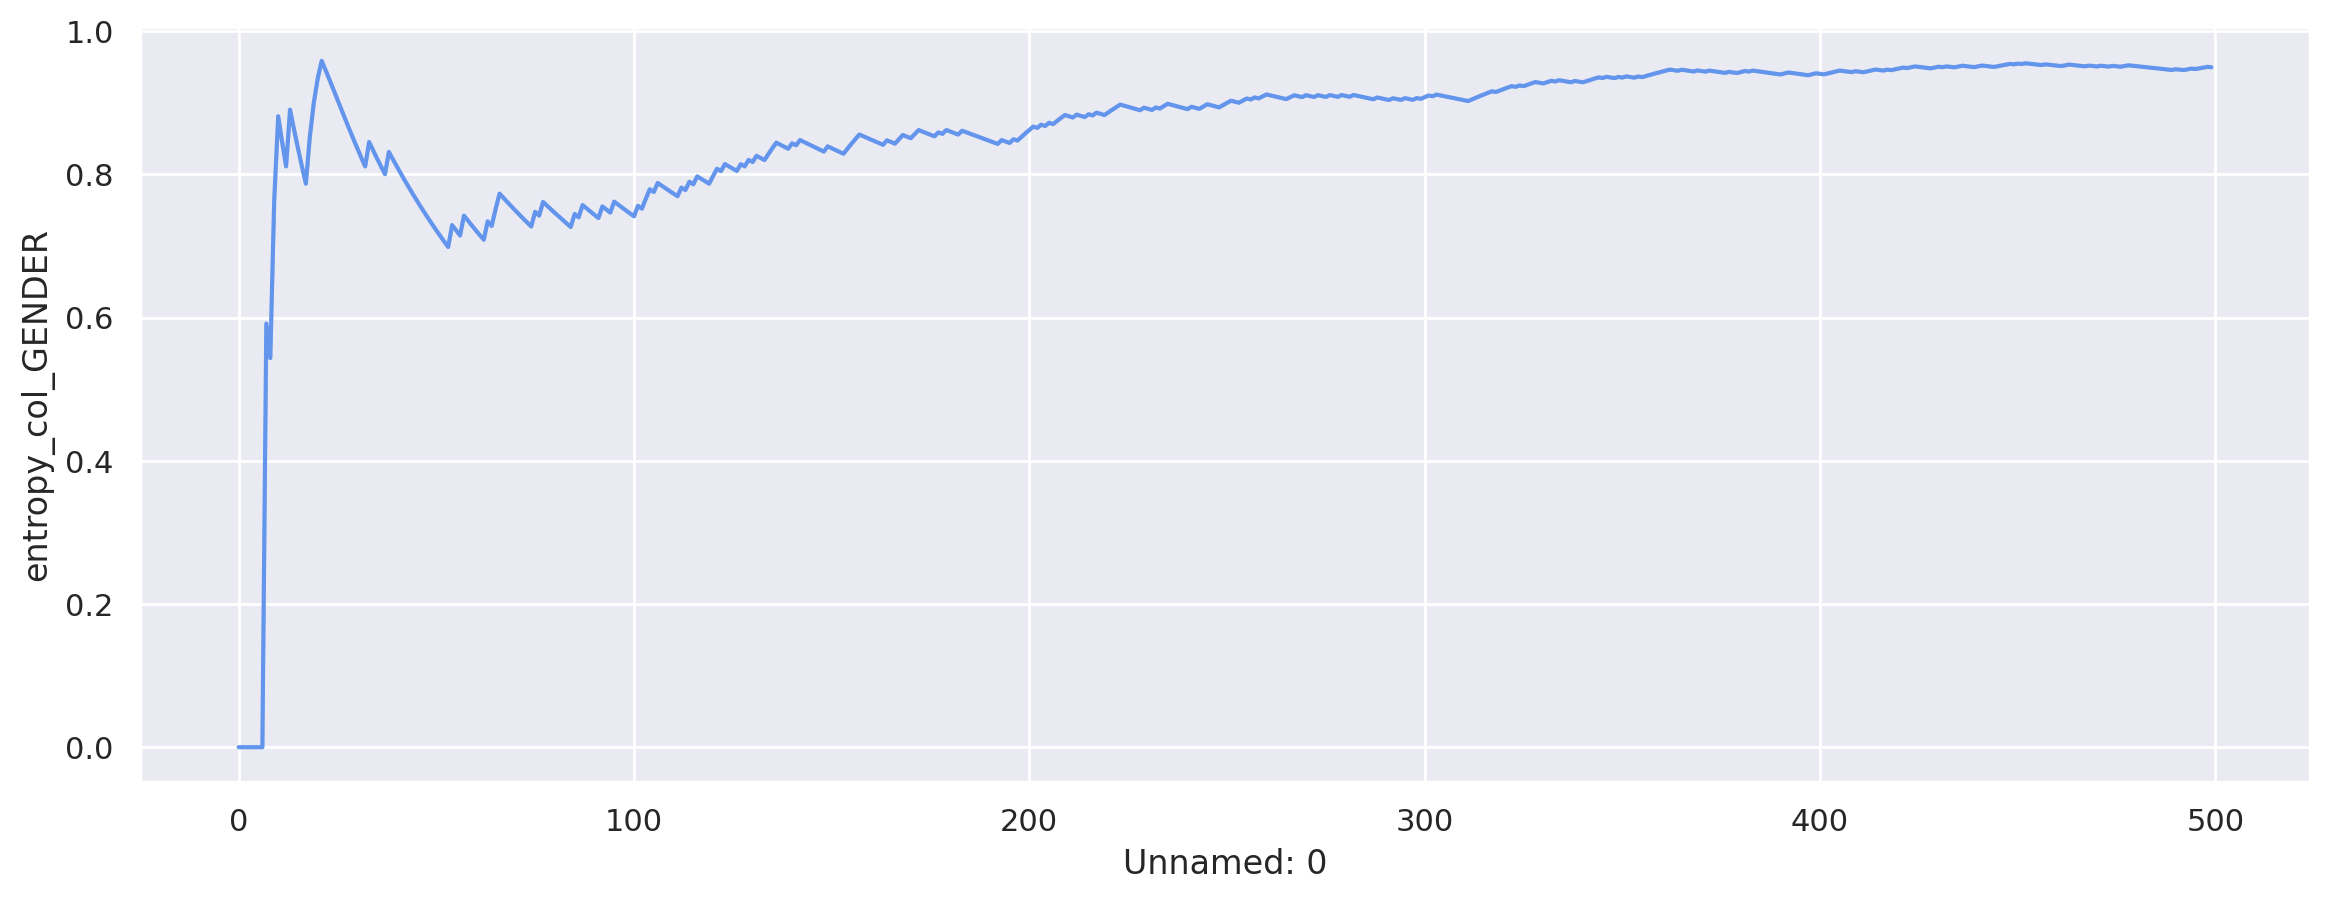

In [ ]:
sns.lineplot(data=df_plain_use, x="Unnamed: 0", y="entropy_col_GENDER",  color="cornflowerblue", ci="sd")

<AxesSubplot:xlabel='Unnamed: 0', ylabel='ENTROPY_KAT'>

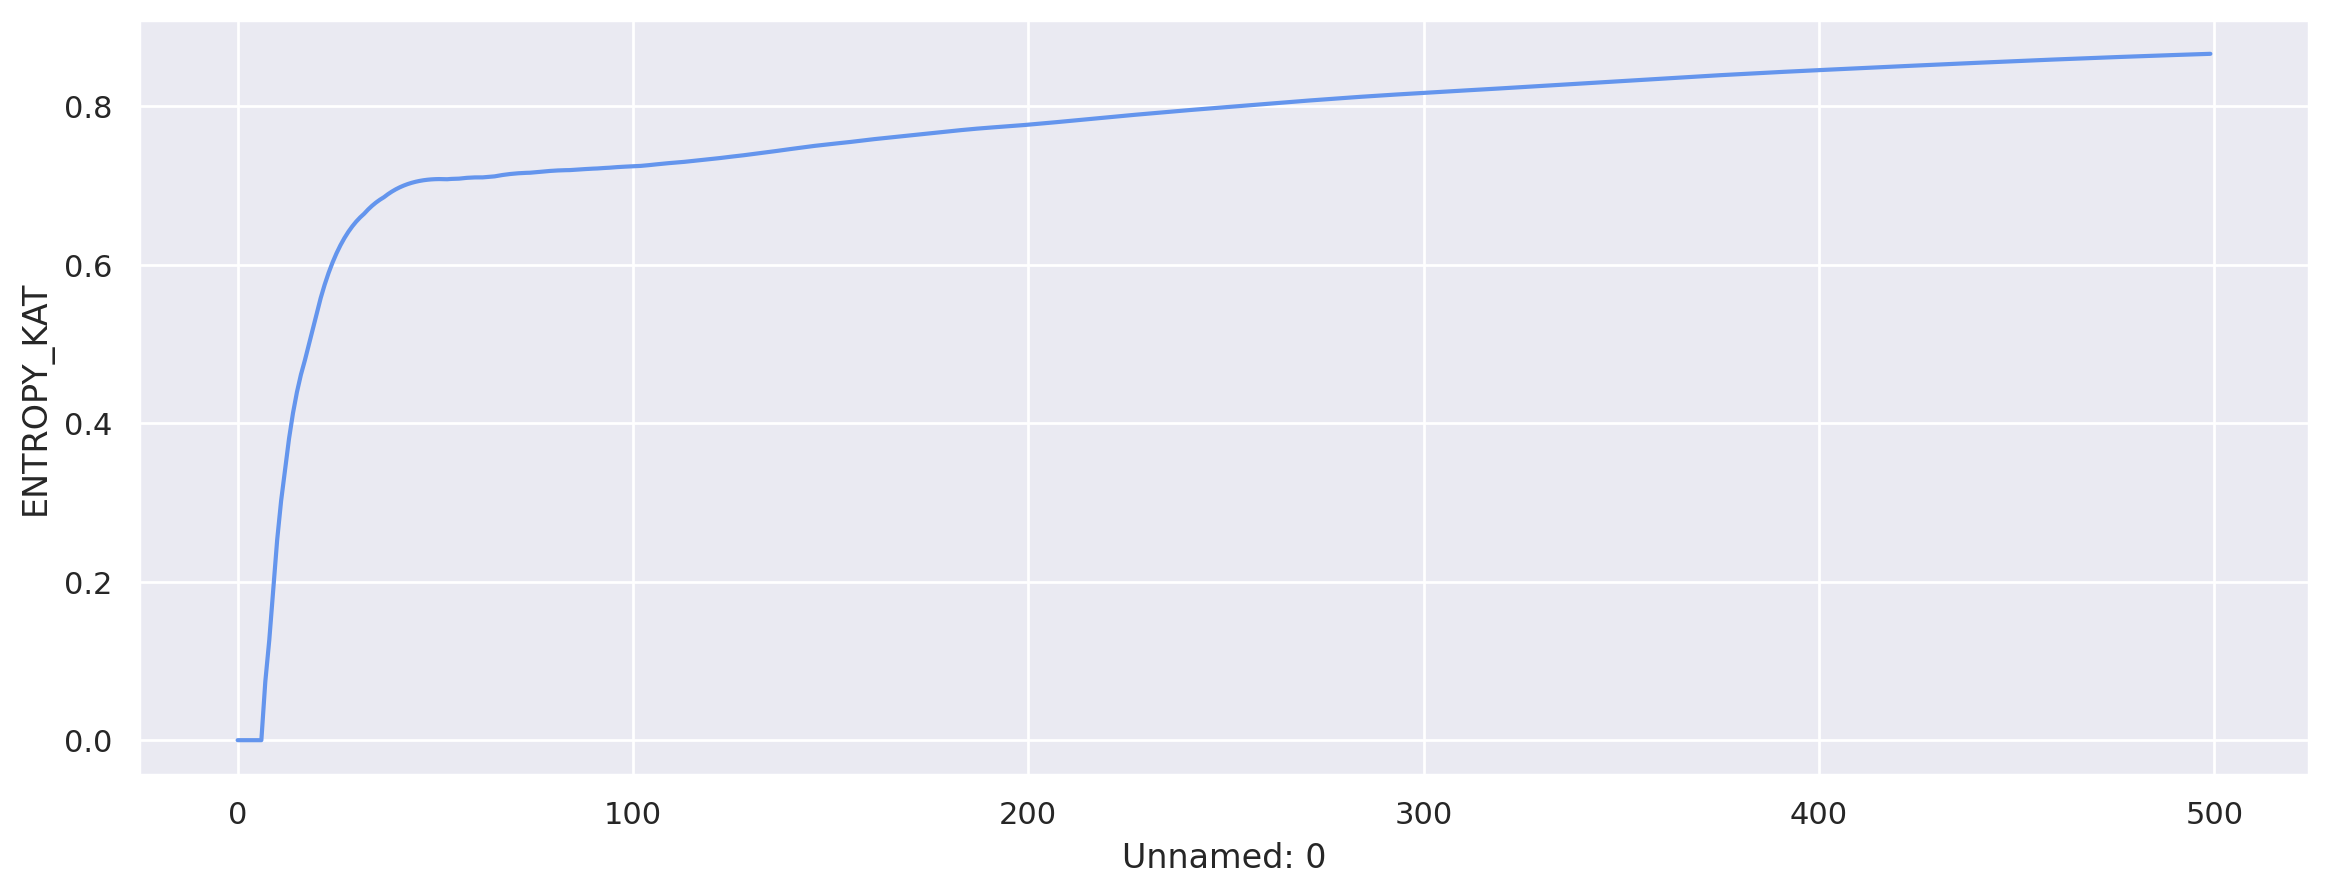

In [ ]:
df_PLAIN_ENTROPY = df_plain_use
df_PLAIN_ENTROPY_std = df_PLAIN_ENTROPY.groupby('Unnamed: 0').std()
df_PLAIN_ENTROPY_mean =  df_PLAIN_ENTROPY.groupby('Unnamed: 0').mean()
df_PLAIN_ENTROPY_mean = df_PLAIN_ENTROPY_mean.sort_values(by=['Preds'], ascending=False)
df_PLAIN_ENTROPY_mean["ENTROPY_KAT"] = df_PLAIN_ENTROPY_mean.entropy_col_GENDER.expanding().mean()
sns.lineplot(data=df_PLAIN_ENTROPY_mean, x="Unnamed: 0", y="ENTROPY_KAT",  color="cornflowerblue", ci="sd")

<AxesSubplot:xlabel='Unnamed: 0', ylabel='Preds'>

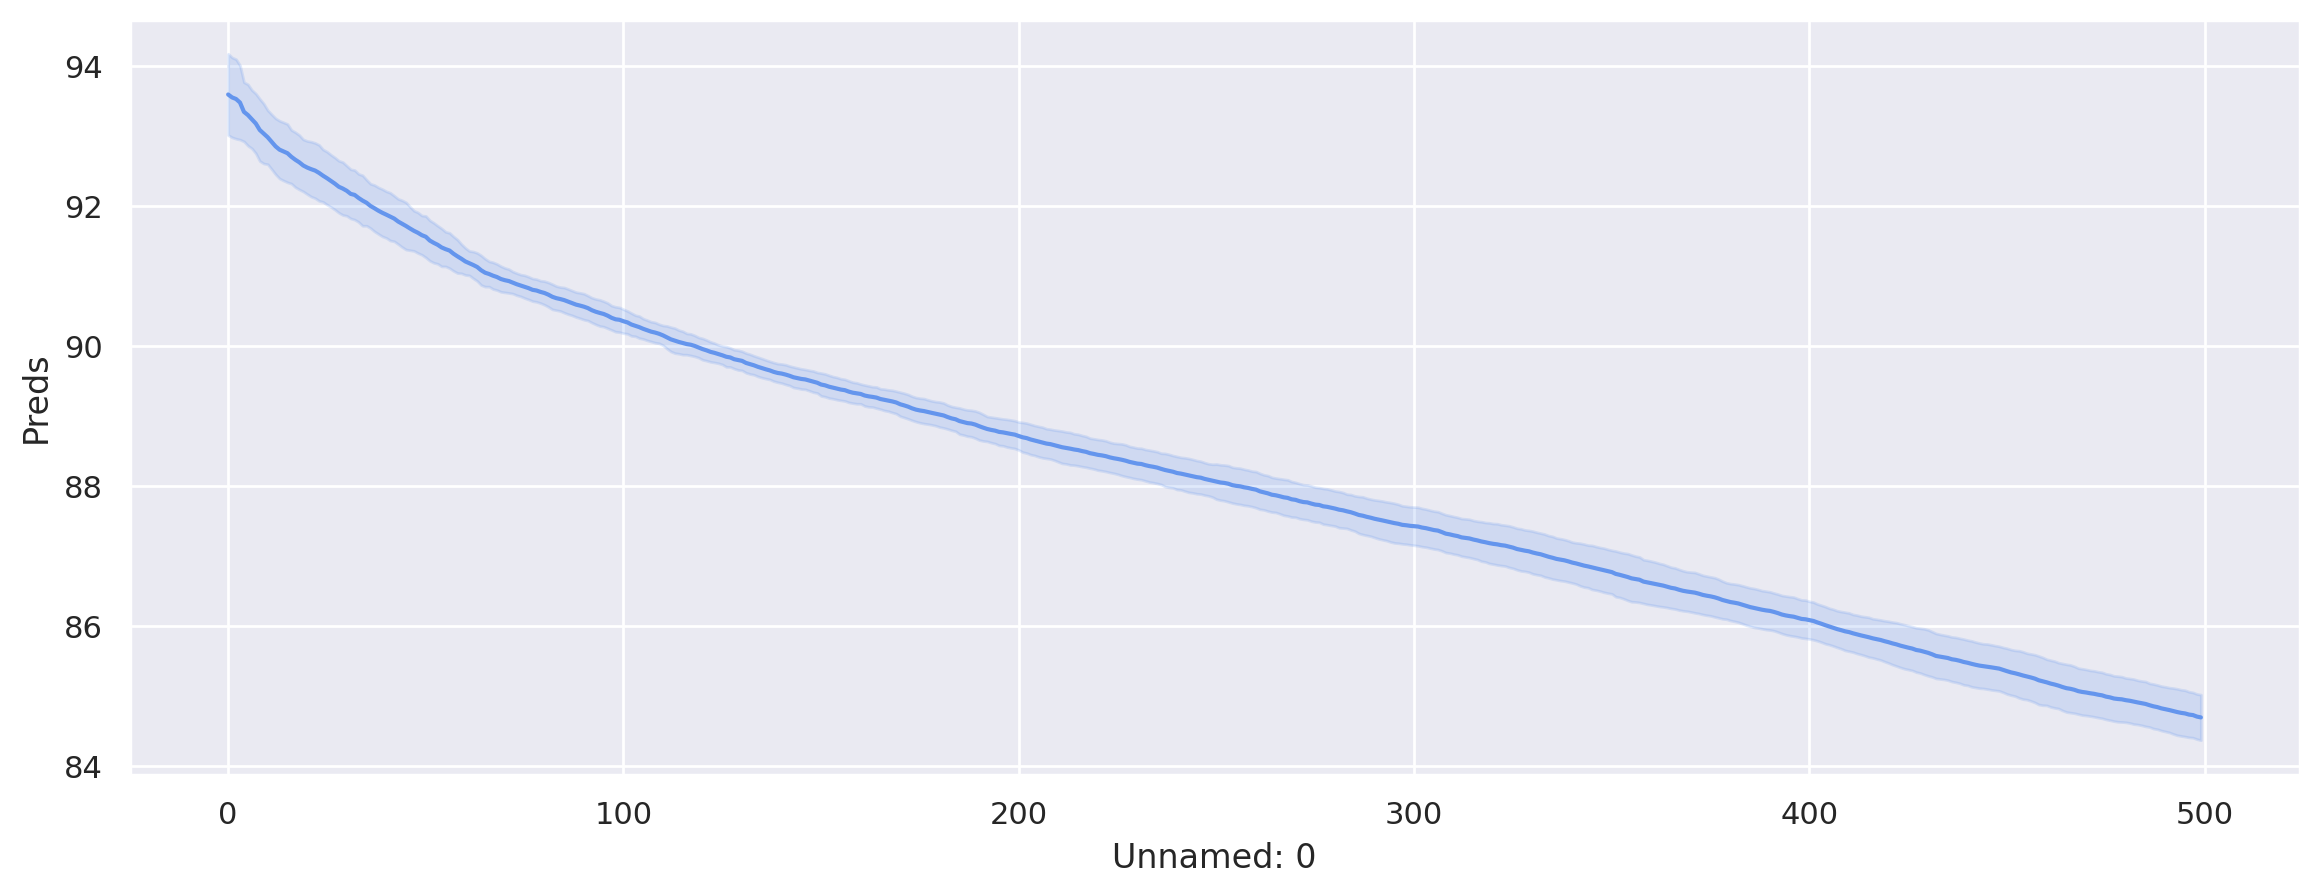

In [ ]:

sns.lineplot(data=df_plain_use, x="Unnamed: 0", y="Preds",  color="cornflowerblue" , ci="sd")


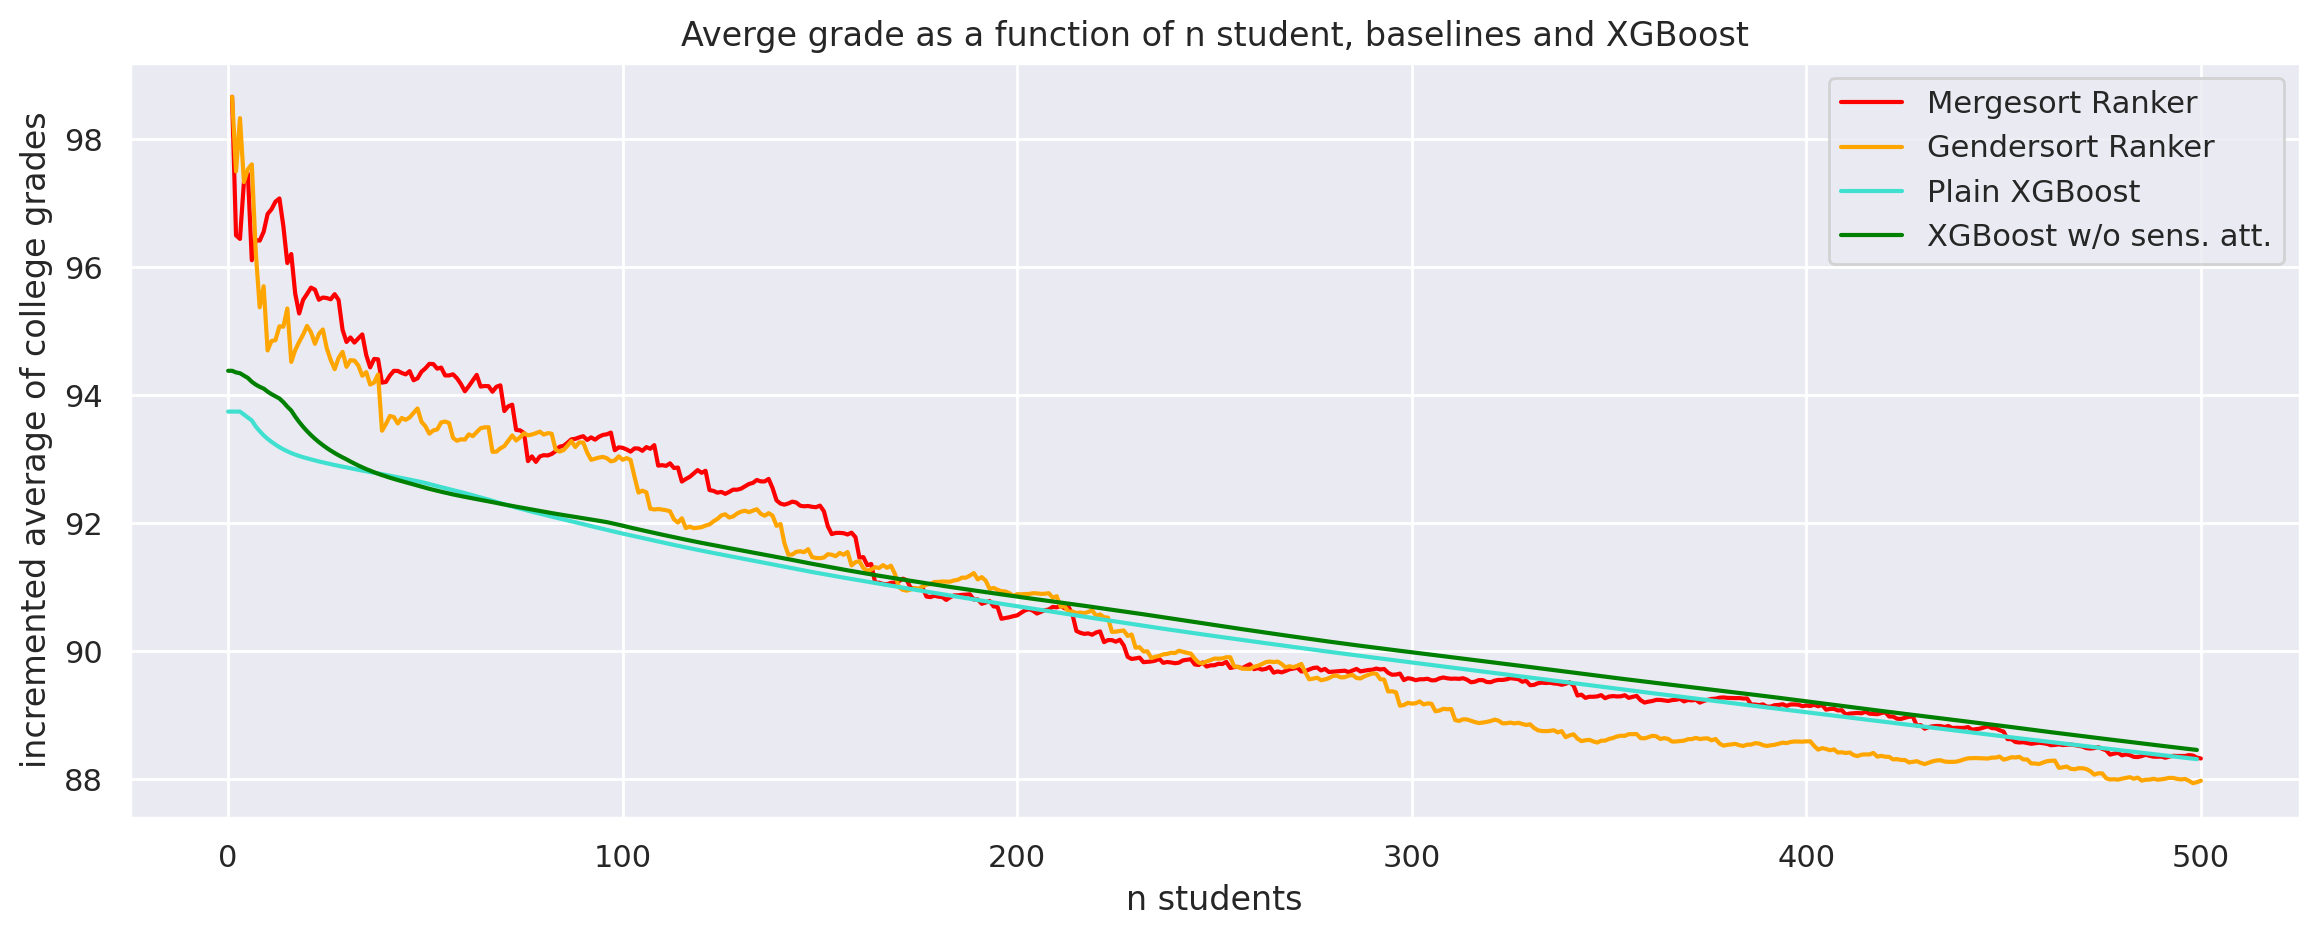

In [ ]:
# The random grades per n students together with the gendersorted mergesort grades per n students

sns.lineplot(x="n_students", y="incr_col_mean", data=df_avg[:500], color='red')
sns.lineplot(x="n_students", y="incr_col_mean", data=gender_df[:500], color ='orange')
sns.lineplot(x="n_students", y="incr_col_mean", data=df_xgb_vanilla[:500], color="turquoise")
# sns.lineplot(x="Unnamed: 0", y="Preds",data=df_plain_use,  color="turquoise" , ci="sd") #Denne har ikke incremented mean og derfor ser den dårligere ud
sns.lineplot(x="n_students", y="incr_col_mean", data=df_xgb_wo[:500], color ="green")
# sns.lineplot(x="n_students", y="incr_col_mean", data=df_reR[:500], color="blue")



plt.xlabel('n students')
plt.ylabel('incremented average of college grades')
plt.title("Averge grade as a function of n student, baselines and XGBoost")
plt.legend(["Mergesort Ranker", "Gendersort Ranker", "Plain XGBoost", "XGBoost w/o sens. att.", "Fairness enhanced XGBoost"], loc ="upper right")
plt.show()

# ENTROPY

In [ ]:

#value counts for each df in all dfs. 0-4000.4000-8000 etc. 
plain_value_counts_GENDER = []
i = 0
while i < 10: #iterate over 200 dfs
    idx = 0
    while idx <= df_plain_use["Unnamed: 0"].max(): #iterate over each idx from 0-499 in each df
        plain_value_counts_GENDER.append(np.array([df_plain_use["Gender_bins"][:idx].value_counts(normalize=True)]))
        idx = idx+1 
    i = i+1

len(plain_value_counts_GENDER)



df_plain_use["value_counts_col_GENDER"] = plain_value_counts_GENDER

#Get gender entropy from the above computed value counts
plain_entropy_GENDER = []
for i in df_plain_use["Unnamed: 0"]:
    plain_entropy_GENDER.append(-(df_plain_use["value_counts_col_GENDER"][i]*np.log2(df_plain_use["value_counts_col_GENDER"][i])).sum())    

df_plain_use["entropy_col_GENDER"] = plain_entropy_GENDER

df_plain_use


5000

In [ ]:
# ## TODO: herunder er lavet til 200 dfs - brug den df


# #import df from xgboost
# # df_plain = df_xgb_vanilla
# # df_plain = pd.read_csv('TWO_samlet_preds_index_ny_PLAIN.csv') #Denne er sat i stedet for vanilla ovenfor
# #only take n students from index 1-500
# indexs = np.arange(0,500)
# #df_plain["n_students"] = range(len(df_plain))
# df_plain_use = df_plain.loc[df_plain['Unnamed: 0'].isin(indexs)]
# df_plain_use = df_plain_use.reset_index()

# # df_plain_use
# # Denne kører altså top 500 efterfulgt af top 500 efter fulgt af top 500

# #apply new column of cumsum+1
# df_plain_use


In [ ]:

# #Check standard deviations for plain

# #Create new list with standard deviation for each n, 0-499
# stds = []
# for i in df_plain_use["Unnamed: 0"].unique():
#     stds.append(df_plain_use[df_plain_use["Unnamed: 0"] == i].Preds.std())

# #entropy calc
# # len(stds)
# # stds

In [ ]:
# # df_plain_use
# #Try with 5000
# # VI tager nu de første 5000 rækker af de 100000 rækker. 
# df_plain_use = df_plain_use.iloc[:5000]
# df_plain_use


In [ ]:

# #value counts for each df in all dfs. 0-4000.4000-8000 etc. 
# plain_value_counts_GENDER = []
# i = 0
# while i < 10: #iterate over 200 dfs
#     idx = 0
#     while idx <= df_plain_use["Unnamed: 0"].max(): #iterate over each idx from 0-499 in each df
#         plain_value_counts_GENDER.append(np.array([df_plain_use["Gender_bins"][:idx].value_counts(normalize=True)]))
#         idx = idx+1 
#     i = i+1

# len(plain_value_counts_GENDER)


5000

In [ ]:


# df_plain_use["value_counts_col_GENDER"] = plain_value_counts_GENDER

# #Get gender entropy from the above computed value counts
# plain_entropy_GENDER = []
# for i in df_plain_use["Unnamed: 0"]:
#     plain_entropy_GENDER.append(-(df_plain_use["value_counts_col_GENDER"][i]*np.log2(df_plain_use["value_counts_col_GENDER"][i])).sum())    

# df_plain_use["entropy_col_GENDER"] = plain_entropy_GENDER

# df_plain_use


<AxesSubplot:xlabel='Unnamed: 0', ylabel='entropy_col_GENDER'>

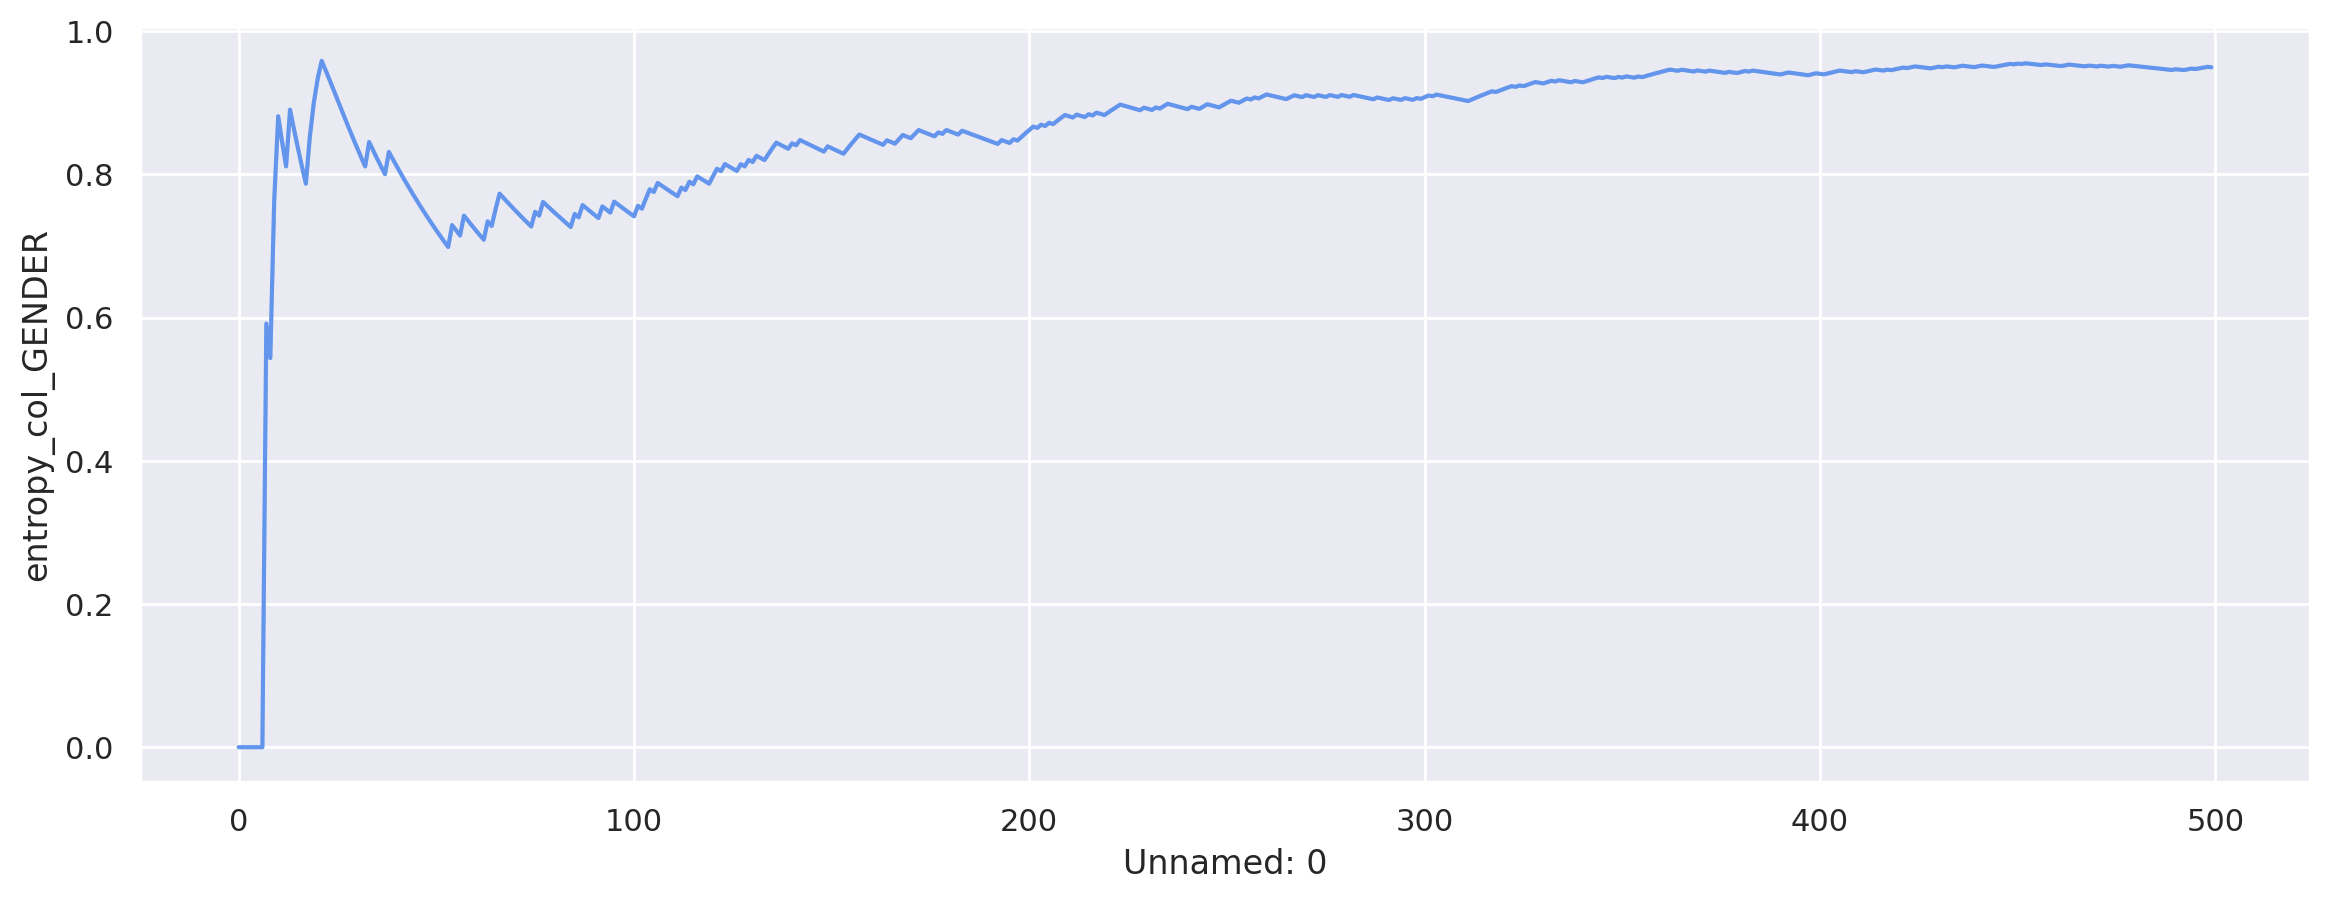

In [ ]:


# #Create new list with standard deviation for each n, 0-499
# stds = []
# for i in df_plain_use["Unnamed: 0"].unique():
#     stds.append(df_plain_use[df_plain_use["Unnamed: 0"] == i].entropy_col_GENDER.std())


#Plot entropy of 200 with std
sns.lineplot(data=df_plain_use, x="Unnamed: 0", y="entropy_col_GENDER",  color="cornflowerblue", ci="sd")



<AxesSubplot:xlabel='Unnamed: 0', ylabel='ENTROPY_KAT'>

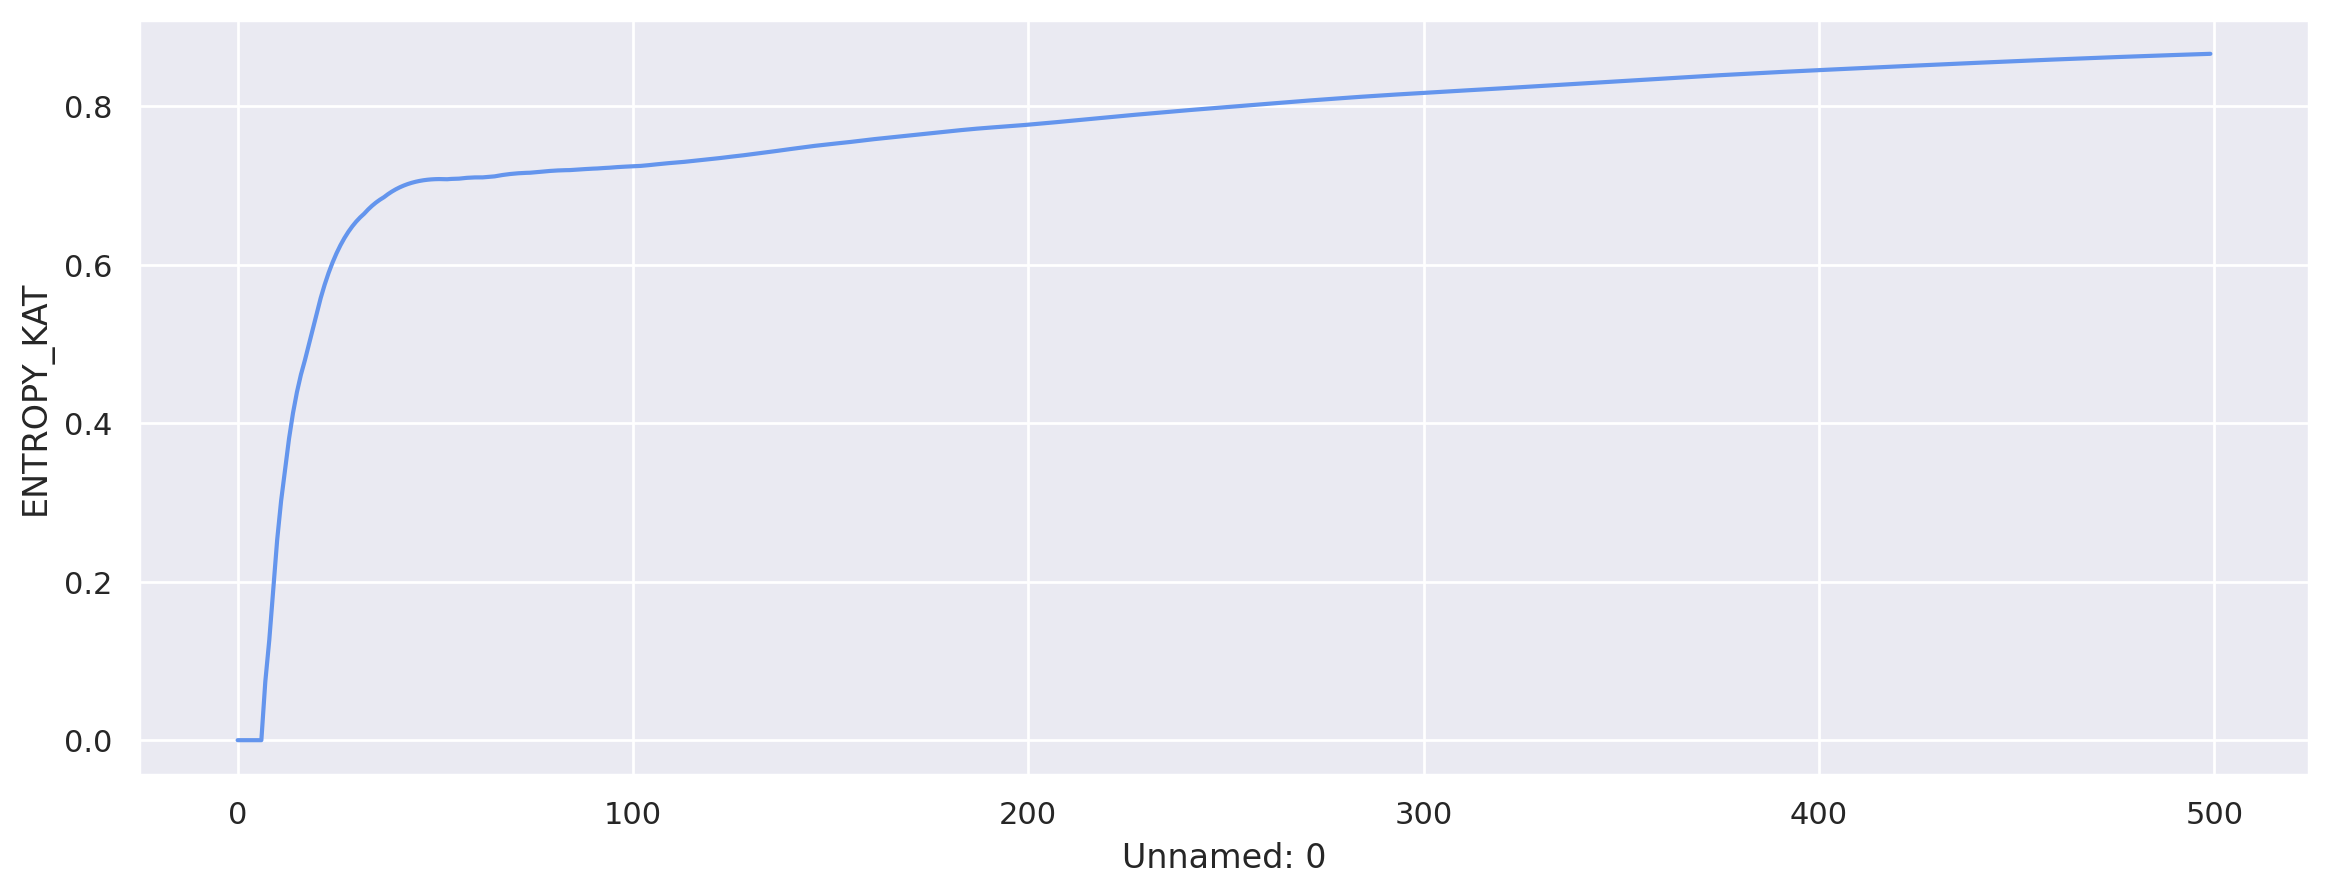

In [ ]:
df_PLAIN_ENTROPY = df_plain_use
df_PLAIN_ENTROPY_std = df_PLAIN_ENTROPY.groupby('Unnamed: 0').std()
df_PLAIN_ENTROPY_mean =  df_PLAIN_ENTROPY.groupby('Unnamed: 0').mean()
df_PLAIN_ENTROPY_mean = df_PLAIN_ENTROPY_mean.sort_values(by=['Preds'], ascending=False)
df_PLAIN_ENTROPY_mean["ENTROPY_KAT"] = df_PLAIN_ENTROPY_mean.entropy_col_GENDER.expanding().mean()
sns.lineplot(data=df_PLAIN_ENTROPY_mean, x="Unnamed: 0", y="ENTROPY_KAT",  color="cornflowerblue", ci="sd")

In [ ]:

# ##### WO 200 

df_wo = pd.read_csv('TWO_samlet_preds_index_ny_WO.csv')
#import df from xgboost
# df_plain = pd.read_csv("samlet_preds_index_ny_PLAIN.csv")
#only take n students from index 1-500
indexs = np.arange(0,500)
#df_plain["n_students"] = range(len(df_plain))
df_wo_use = df_wo.loc[df_wo['Unnamed: 0'].isin(indexs)]
df_wo_use = df_wo_use.reset_index()
#apply new column of cumsum+1


In [ ]:

#Create new list with standard deviation for each n, 0-499
stds = []
for i in df_wo_use["Unnamed: 0"].unique():
    stds.append(df_wo_use[df_wo_use["Unnamed: 0"] == i].Preds.std())


indexs2 = np.arange(0,500)
df_wo_use = df_wo.loc[df_wo['Unnamed: 0'].isin(indexs)]

df_wo_use = df_wo_use.iloc[:5000]


#value counts for each df in all dfs
wo_value_counts_GENDER = []
i = 0
while i < 10: #iterate over 200 dfs
    idx = 0
    while idx <= df_wo_use["Unnamed: 0"].max(): #iterate over each idx from 0-499 in each df
        wo_value_counts_GENDER.append(np.array([df_wo_use["Gender_bins"][:idx].value_counts(normalize=True)]))
        idx = idx+1 
    i = i+1

df_wo_use["value_counts_col_GENDER"] = wo_value_counts_GENDER


wo_entropy_GENDER = []
for i in df_wo_use["Unnamed: 0"]:
    wo_entropy_GENDER.append(-(df_wo_use["value_counts_col_GENDER"][i]*np.log2(df_wo_use["value_counts_col_GENDER"][i])).sum())    

df_wo_use["entropy_col_GENDER"] = wo_entropy_GENDER

In [ ]:

#PROBABLY DON*T NEED IT



# #For each row incremented, get ratio of M and F
# data_value_counts_xg_vanilla= []
# for i in range(1,len(df_xgb_vanilla)+1):
#     data_value_counts_xg_vanilla.append(np.array([df_xgb_vanilla["Gender_bins"][:i].value_counts(normalize=True)]))

# #Create new column with the ratios
# df_xgb_vanilla["value_counts_col_GENDER"] = data_value_counts_xg_vanilla

# # Check if probabilities look correct
# #print(df_xgb_vanilla[["value_counts_col_GENDER", "GENDER_bin"]][:5])

# #For each row incremented, get entropy 
# data_entropy_xgb_vanilla = []
# for i in range(len(df_xgb_vanilla)):
#     data_entropy_xgb_vanilla.append(-(df_xgb_vanilla["value_counts_col_GENDER"][i]*np.log2(df_xgb_vanilla["value_counts_col_GENDER"][i])).sum())

# #Create new column with the entropy
# df_xgb_vanilla["entropy_col_GENDER"] = data_entropy_xgb_vanilla




In [ ]:

## WITHOUT SENSITIVE ATTRIBUTES
#value counts for each df in all dfs. 0-4000.4000-8000 etc. 

# df_wo_use = df_xgb_wo.loc[df_xgb_wo['Unnamed: 0'].isin(indexs)]
# df_wo_use = df_wo_use.reset_index()
# df_WO_ENTROPY = df_wo_use

# wo_value_counts_GENDER = []
# i = 0
# while i < 1: #while i < 10: #iterate over 200 dfs
#     idx = 0
#     while idx <= df_WO_ENTROPY["Unnamed: 0"].max(): #iterate over each idx from 0-499 in each df
#         wo_value_counts_GENDER.append(np.array([df_WO_ENTROPY["Gender_bins"][:idx].value_counts(normalize=True)]))
#         idx = idx+1 
#     i = i+1

# df_WO_ENTROPY["value_counts_col_GENDER"] = wo_value_counts_GENDER

# #Get gender entropy from the above computed value counts
# wo_entropy_GENDER = []
# for i in df_WO_ENTROPY["Unnamed: 0"]:
#     wo_entropy_GENDER.append(-(df_WO_ENTROPY["value_counts_col_GENDER"][i]*np.log2(df_WO_ENTROPY["value_counts_col_GENDER"][i])).sum())    

# df_WO_ENTROPY["entropy_col_GENDER"] = wo_entropy_GENDER

# df_WO_ENTROPY

,index,Unnamed: 0,Idx,Gender_bins,Preds,STRATUM,incr_col_mean,n_students,value_counts_col_GENDER,entropy_col_GENDER
0,0,0,2068,0,94.381973,Stratum_3,94.381973,0,[[]],-0.000000
1,1,1,7493,0,94.381973,Stratum_3,94.381973,1,[[1.0]],-0.000000
2,2,2,4900,0,94.305351,Stratum_2,94.356433,2,[[1.0]],-0.000000
3,3,3,7126,0,94.305351,Stratum_3,94.343662,3,[[1.0]],-0.000000
4,4,4,12328,0,94.163025,Stratum_3,94.307535,4,[[1.0]],-0.000000
...,...,...,...,...,...,...,...,...,...,...
495,495,495,11490,0,84.887222,Stratum_4,88.480810,495,"[[0.6666666666666666, 0.3333333333333333]]",0.918296
496,496,496,5503,1,84.887222,Stratum_3,88.473580,496,"[[0.6673387096774194, 0.3326612903225806]]",0.917622
497,497,497,2657,0,84.887222,Stratum_4,88.466378,497,"[[0.6659959758551308, 0.33400402414486924]]",0.918965
498,498,498,8078,0,84.885666,Stratum_5,88.459202,498,"[[0.6666666666666666, 0.3333333333333333]]",0.918296


<AxesSubplot:xlabel='Unnamed: 0', ylabel='ENTROPY_KAT'>

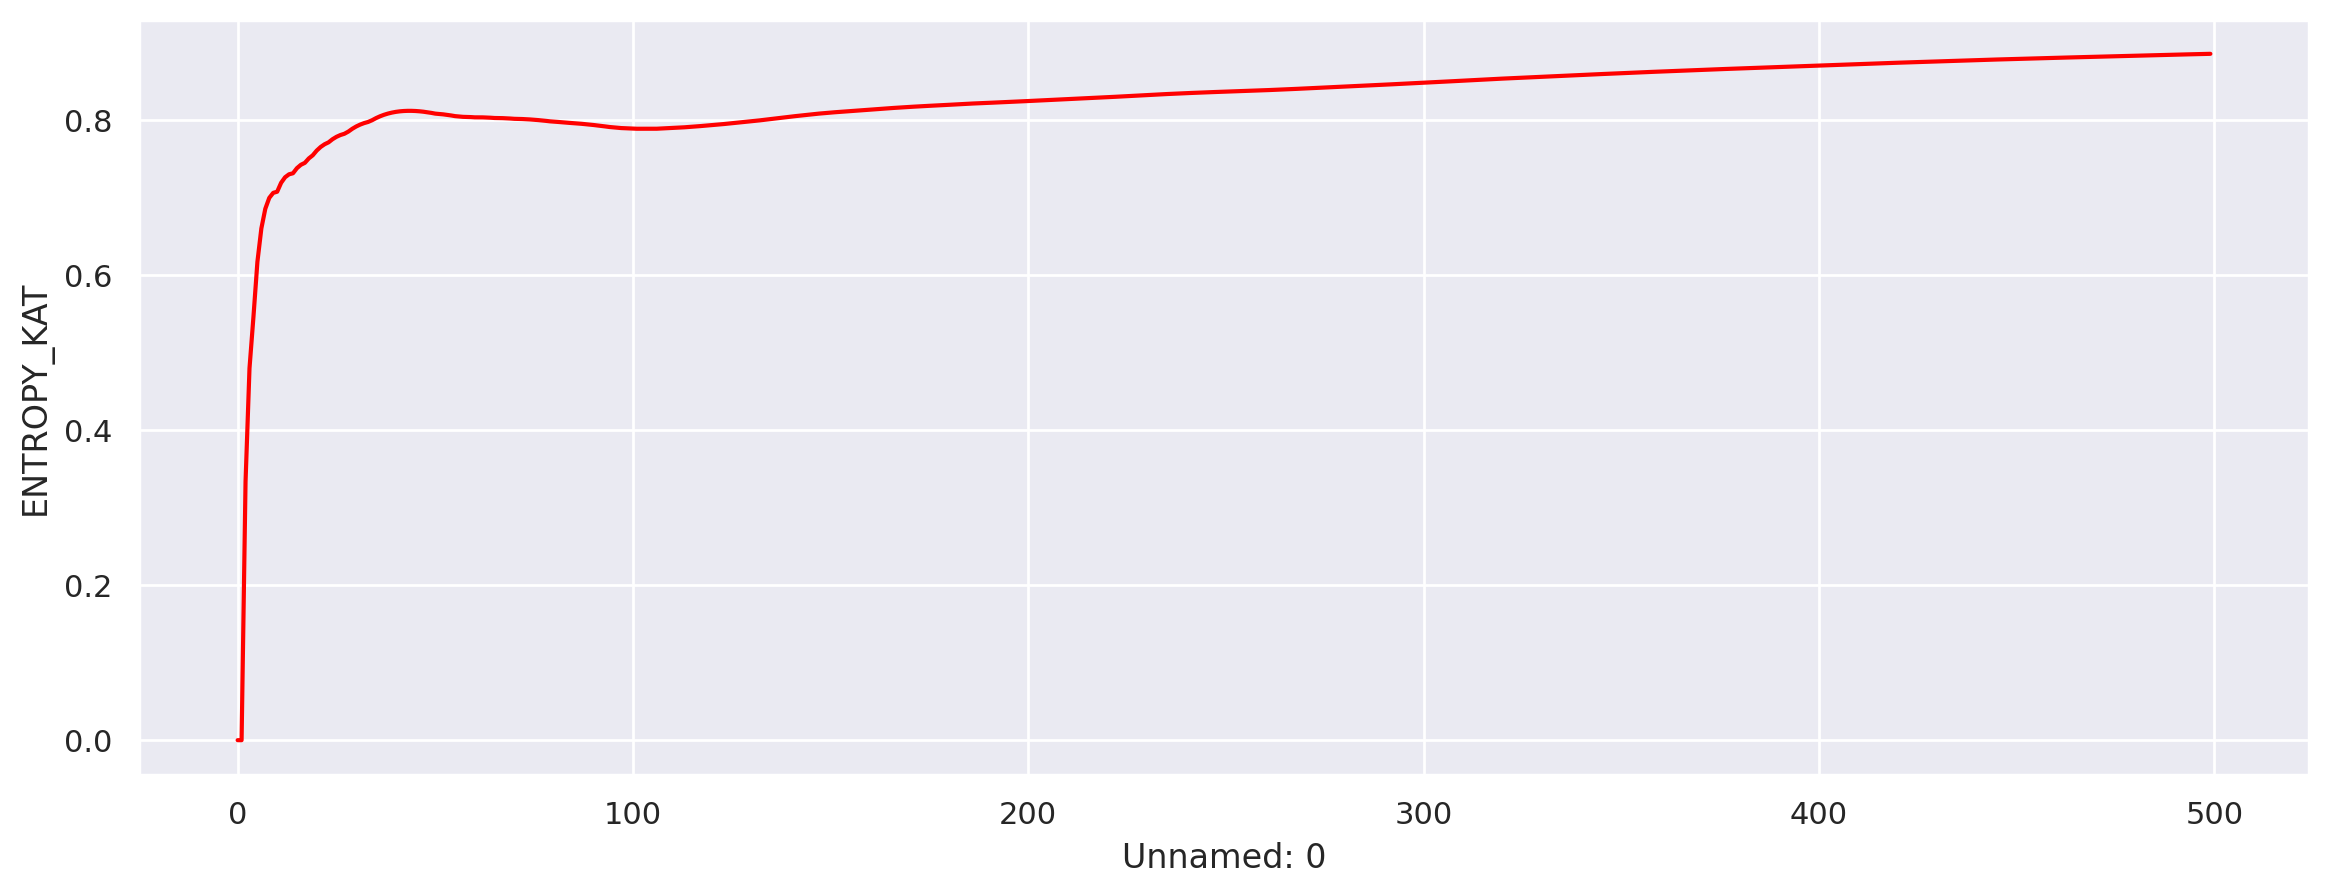

In [ ]:

df_WO_ENTROPY = df_wo_use
df_WO_ENTROPY_std = df_WO_ENTROPY.groupby('Unnamed: 0').std()
df_WO_ENTROPY_mean =  df_WO_ENTROPY.groupby('Unnamed: 0').mean()
df_WO_ENTROPY_mean = df_WO_ENTROPY_mean.sort_values(by=['Preds'], ascending=False)
df_WO_ENTROPY_mean["ENTROPY_KAT"] = df_WO_ENTROPY_mean.entropy_col_GENDER.expanding().mean()
sns.lineplot(data=df_WO_ENTROPY_mean, x="Unnamed: 0", y="ENTROPY_KAT",  color="red", ci="sd")


<AxesSubplot:xlabel='Unnamed: 0', ylabel='ENTROPY_KAT'>

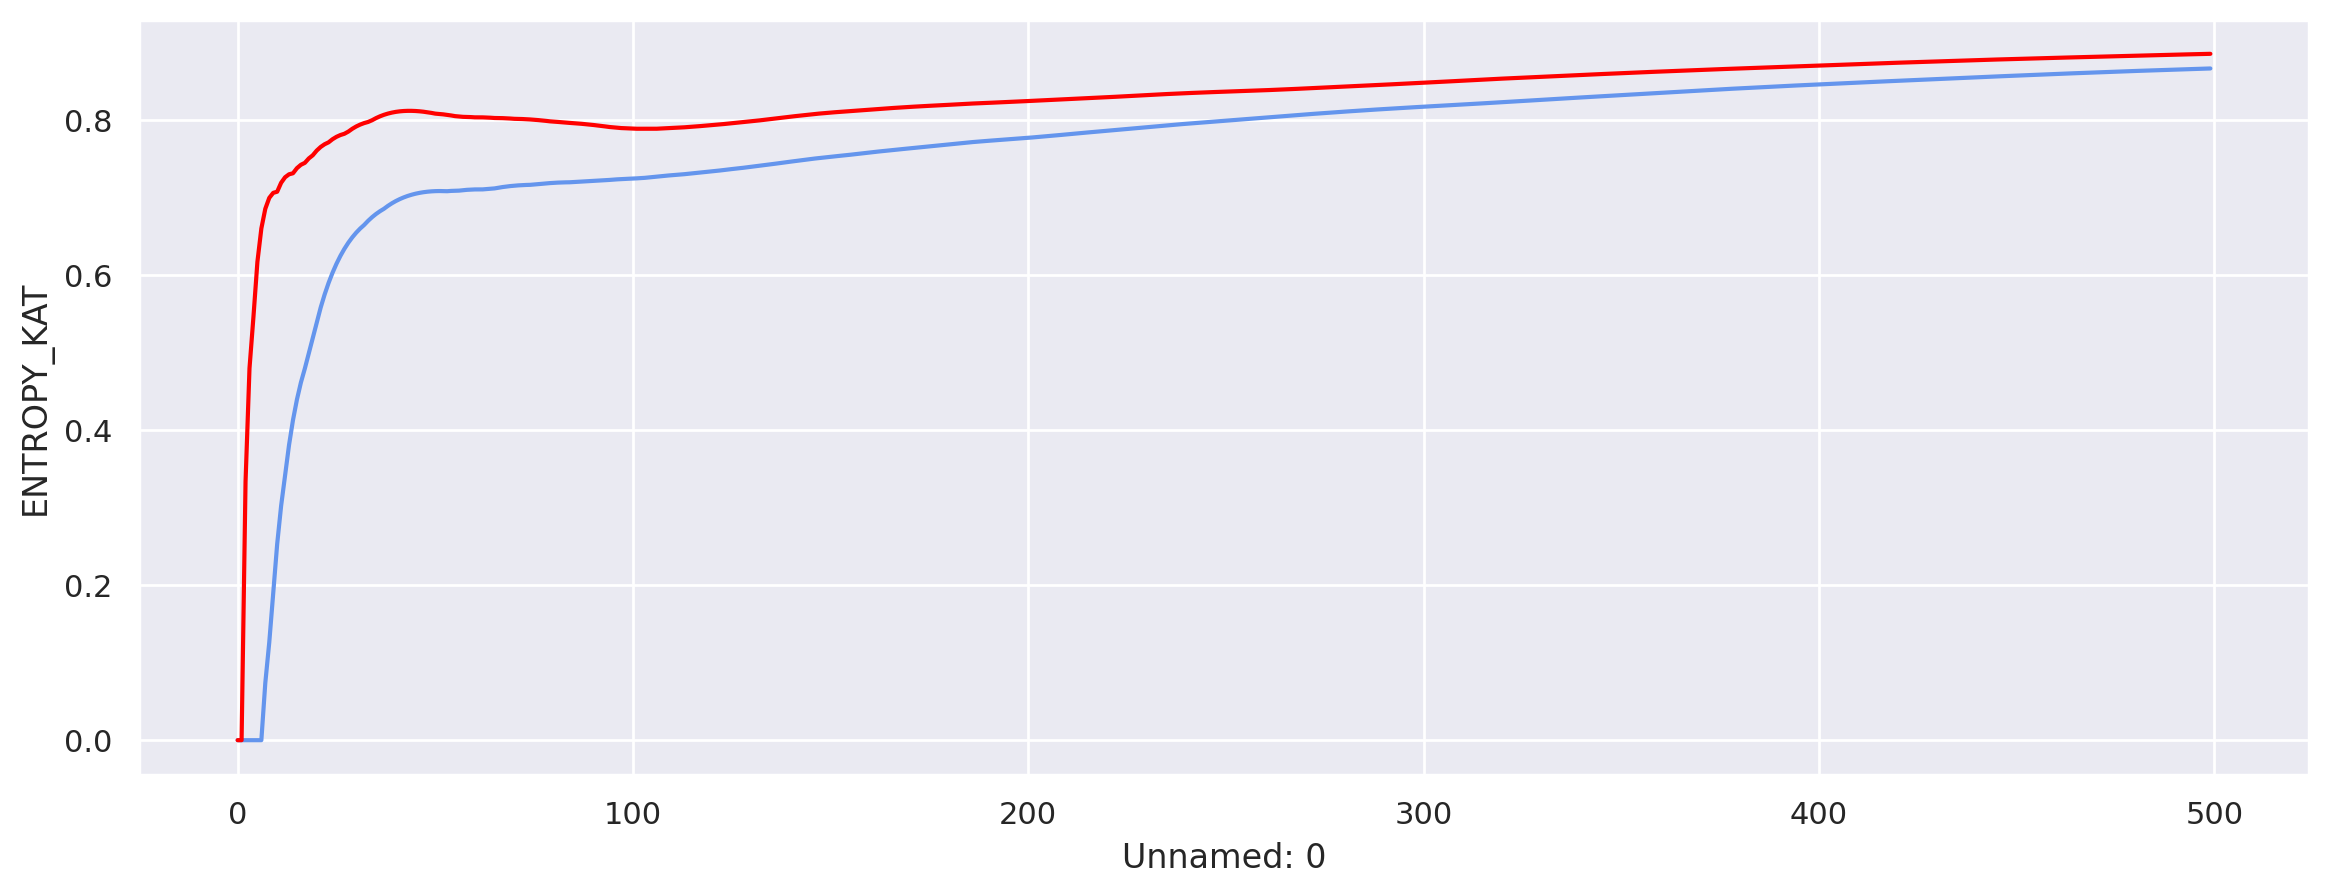

In [ ]:


# df_PLAIN_ENTROPY = pd.read_csv('TWO_samlet_preds_index_ny_PLAIN.csv')
# df_PLAIN_ENTROPY = df_PLAIN_ENTROPY[:5000]


df_PLAIN_ENTROPY = df_plain_use
df_PLAIN_ENTROPY_std = df_PLAIN_ENTROPY.groupby('Unnamed: 0').std()
df_PLAIN_ENTROPY_mean =  df_PLAIN_ENTROPY.groupby('Unnamed: 0').mean()
df_PLAIN_ENTROPY_mean = df_PLAIN_ENTROPY_mean.sort_values(by=['Preds'], ascending=False)
df_PLAIN_ENTROPY_mean["ENTROPY_KAT"] = df_PLAIN_ENTROPY_mean.entropy_col_GENDER.expanding().mean()
sns.lineplot(data=df_PLAIN_ENTROPY_mean, x="Unnamed: 0", y="ENTROPY_KAT",  color="cornflowerblue", ci="sd")
sns.lineplot(data=df_WO_ENTROPY_mean, x="Unnamed: 0", y="ENTROPY_KAT",  color="red", ci="sd")



In [ ]:
## RE RANKED 
df_reR = pd.read_csv('re_ranked_PLAIN.csv')
#For each row incremented, get ratio of M and F
data_value_counts_RE_RANKED = []
for i in range(1,len(df_reR)+1):
    data_value_counts_RE_RANKED.append(np.array([df_reR["Gender_bins"][:i].value_counts(normalize=True)]))

#Create new column with the ratios
df_reR["value_counts_col_GENDER"] = data_value_counts_RE_RANKED

# Check if probabilities look correct
# print(df_reR[["value_counts_col_GENDER", "Gender_bins"]][:10])


#For each row incremented, get entropy 
data_entropy_RE_RANKED = []
for i in range(len(df_reR)):
    data_entropy_RE_RANKED.append(-(df_reR["value_counts_col_GENDER"][i]*np.log2(df_reR["value_counts_col_GENDER"][i])).sum())

#Create new column with the entropy
df_reR["entropy_col_GENDER"] = data_entropy_RE_RANKED

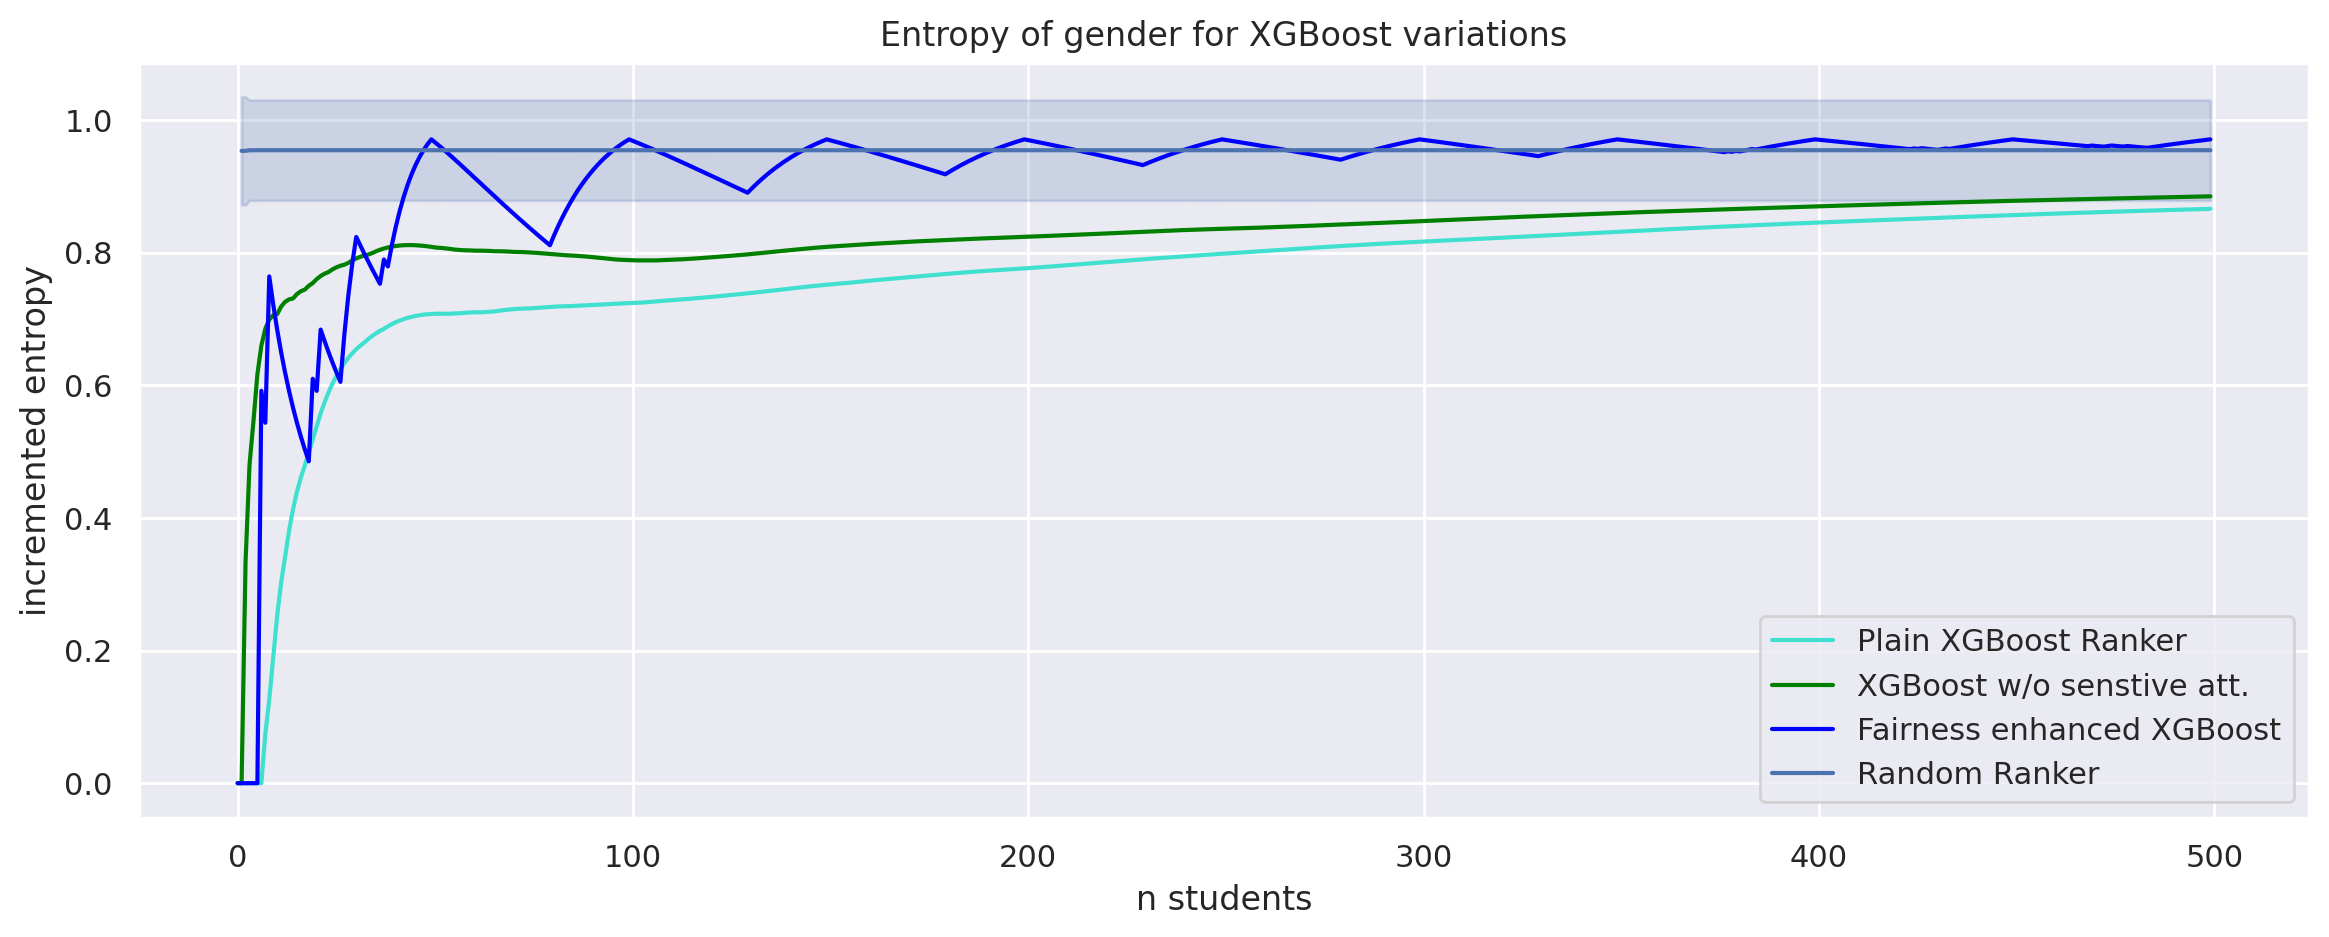

In [ ]:
## PLOT TOGETHER

#apply new column of cumsum+1
df_xgb_vanilla["n_students"] = range(len(df_xgb_vanilla))
df_xgb_wo["n_students"] = range(len(df_xgb_wo))
df_reR["n_students"] = range(len(df_reR))


# sns.lineplot(x="n_students", y="entropy_col_GENDER", data=df_xgb_vanilla[:500], color="turquoise") #with
sns.lineplot(data=df_PLAIN_ENTROPY_mean[:500], x="Unnamed: 0", y="ENTROPY_KAT",  color="turquoise", ci="sd")
# sns.lineplot(x="n_students", y="entropy_col_GENDER", data=df_xgb_wo[:500], color="green") #without
sns.lineplot(data=df_WO_ENTROPY_mean, x="Unnamed: 0", y="ENTROPY_KAT",  color="green", ci="sd")

sns.lineplot(x="n_students", y="entropy_col_GENDER", data=df_reR[:500], color="blue") #without
sns.lineplot(data=df_random_use, x="n_students", y="entropy_col_GENDER", ci="sd")




plt.title("Entropy of gender for XGBoost variations")
plt.xlabel('n students')
plt.ylabel('incremented entropy')

plt.legend(["Plain XGBoost Ranker", "XGBoost w/o senstive att.",'Fairness enhanced XGBoost','Random Ranker'], loc ="lower right")

plt.show()

<AxesSubplot:xlabel='Unnamed: 0', ylabel='ENTROPY_KAT'>

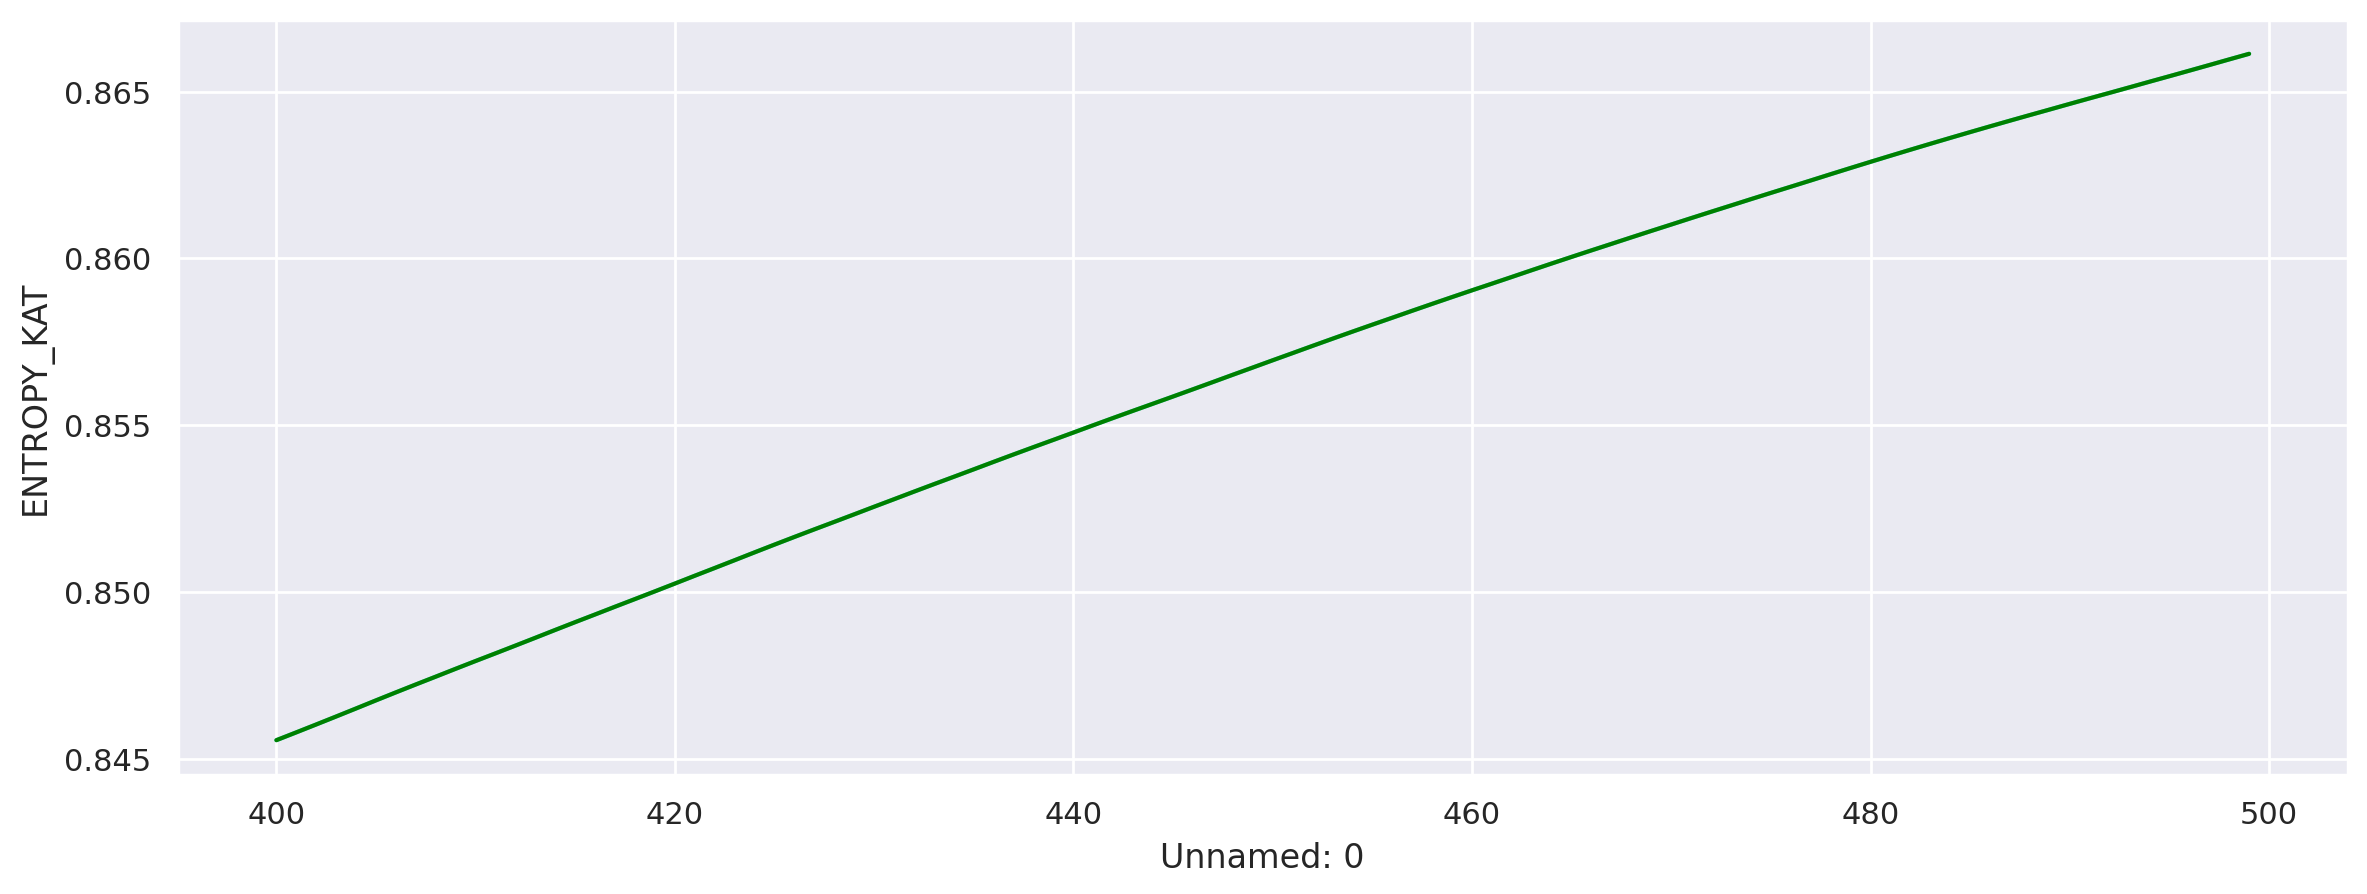

In [ ]:
sns.lineplot(data=df_PLAIN_ENTROPY_mean[400:500], x="Unnamed: 0", y="ENTROPY_KAT",  color="turquoise", ci="sd")
# sns.lineplot(x="n_students", y="entropy_col_GENDER", data=df_xgb_wo[:500], color="green") #without
sns.lineplot(data=df_WO_ENTROPY_mean[400:500], x="Unnamed: 0", y="ENTROPY_KAT",  color="green", ci="sd")

## Plot of gender entropy: Mergesort, gendersort and random, XGBoost


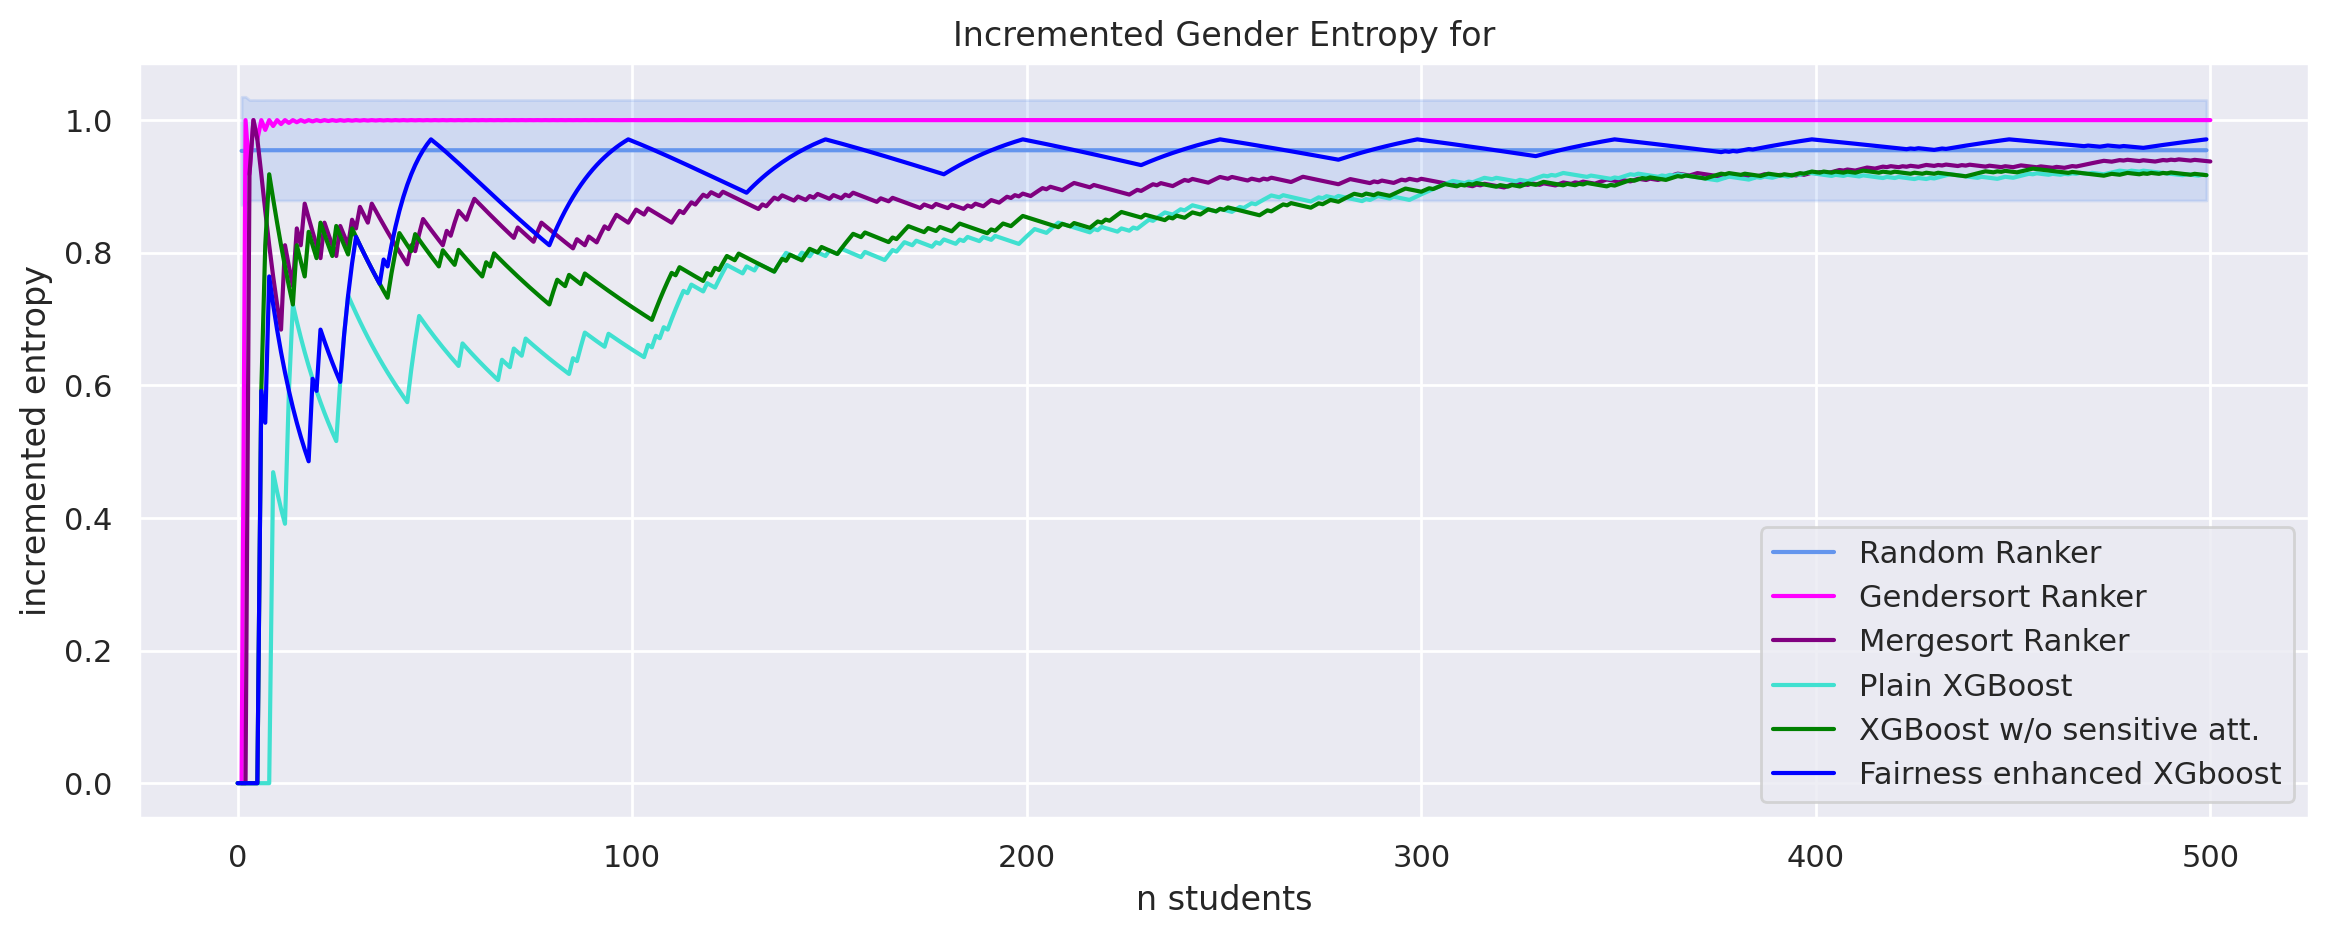

In [ ]:
#ENTROPY GENDER gender_sort and merge_sort and random

# list of colors: https://matplotlib.org/stable/gallery/color/named_colors.html

df_sort["n_students"] = range(1,len(df_sort)+1)

sns.color_palette("deep")

# randomsort entropy of gender
sns.lineplot(data=df_random_use, x="n_students", y="entropy_col_GENDER", ci="sd", color="cornflowerblue")


# gendersort entropy of gender
sns.lineplot(x="n_students", y="entropy_col_GENDER", data=gender_df[:500], color="magenta")

# mergesort entropy of gender
sns.lineplot(x="n_students", y="entropy_col_GENDER", data=df_sort[:500], color="purple")


## XGBOOST

#apply new column of cumsum+1
df_xgb_vanilla["n_students"] = range(len(df_xgb_vanilla))
df_xgb_wo["n_students"] = range(len(df_xgb_wo))
df_reR["n_students"] = range(len(df_reR))


sns.lineplot(x="n_students", y="entropy_col_GENDER", data=df_xgb_vanilla[:500], color="turquoise") #with
sns.lineplot(x="n_students", y="entropy_col_GENDER", data=df_xgb_wo[:500], color="green") #without
sns.lineplot(x="n_students", y="entropy_col_GENDER", data=df_reR[:500], color="blue") #fair


plt.title("Incremented Gender Entropy for")
plt.xlabel('n students')
plt.ylabel('incremented entropy')

plt.legend(['Random Ranker',"Gendersort Ranker", "Mergesort Ranker", "Plain XGBoost",'XGBoost w/o sensitive att.', 'Fairness enhanced XGboost'], loc ="lower right")



plt.show()

## Gender-stratum entropy
In this case *i* = {1_0, 1_1, 2_0, 2_1, ... , 6_0, 6_1}. We call each entry for a sg-par. E.g. 1_0 represents Stratum 1, Gender F = 0. 6_1 represents Stratum 6, Gender M = 1. 
I.e. $p_{i}$ is the ratio of each sg-pair in the given sample. The entropy is the summation over the number of sg-pair present in the sample. 
Log base e (natural) is used, as each entry is a natural number. 


### Mergesort, gender-stratum entropy

In [ ]:
# Function creating gender-startum pair = sg_pair
def sgpair_func(gen, strat):
    #combines startum number and binary gender number in a string:
    for i in range(1,7):
        if gen==1 and strat == "Stratum_{}".format(i):
            return "{}_1".format(i)
        elif gen==0 and strat == "Stratum_{}".format(i):
            return "{}_0".format(i)
        else:
            None

#stratum gender pair column
df_sort["sg_pair"] = df_sort.apply(lambda x: sgpair_func(x['GENDER_bin'], x['STRATUM']), axis=1)

#For each row incremented, get ratio of sg-pair(s) and add to df
data_value_counts = []
for i in range(1,len(df_sort)+1):
    data_value_counts.append(np.array([df_sort["sg_pair"][:i].value_counts(normalize=True)]))

df_sort["value_counts_col"] = data_value_counts

#For each row incremented, get entropy of sg-pair(s) and add to df
data_entropy = []
for i in range(len(df_sort)):
    data_entropy.append(-(df_sort["value_counts_col"][i]*np.log10(df_sort["value_counts_col"][i])).sum())

df_sort["entropy_col"] = data_entropy

In [ ]:
# Check if entropy looks correct
#print(-2*np.sum(0.5*np.log10(0.5)))

#df_sort[["sg_pair", "value_counts_col", "entropy_col"]]

### Gendersort, gender-stratum entropy

In [ ]:
# Function creating gender-startum pair = sg_pair
def sgpair_func(gen, strat):
    #combines startum number and binary gender number in a string:
    for i in range(1,7):
        if gen==1 and strat == "Stratum_{}".format(i):
            return "{}_1".format(i)
        elif gen==0 and strat == "Stratum_{}".format(i):
            return "{}_0".format(i)
        else:
            None

#stratum gender pair column
gender_df["sg_pair"] = gender_df.apply(lambda x: sgpair_func(x['GENDER_bin'], x['STRATUM']), axis=1)

#For each row incremented, get ratio of sg-pair(s) and add to df
data_value_counts = []
for i in range(1,len(gender_df)+1):
    data_value_counts.append(np.array([gender_df["sg_pair"][:i].value_counts(normalize=True)]))

gender_df["value_counts_col"] = data_value_counts

#For each row incremented, get entropy of sg-pair(s) and add to df
data_entropy = []
for i in range(len(gender_df)):
    data_entropy.append(-(gender_df["value_counts_col"][i]*np.log10(gender_df["value_counts_col"][i])).sum())


gender_df["entropy_col"] = data_entropy

In [ ]:
# Check if entropy looks correct
#print(-2*np.sum(0.5*np.log10(0.5)))

#gender_df[["sg_pair", "value_counts_col", "entropy_col"]]

# TODO: gender-stratum entropy for random

# TODO: gender-stratum entropy for XGBoost

### Plot of gender-stratum entropy: Mergesort, gendersort and random

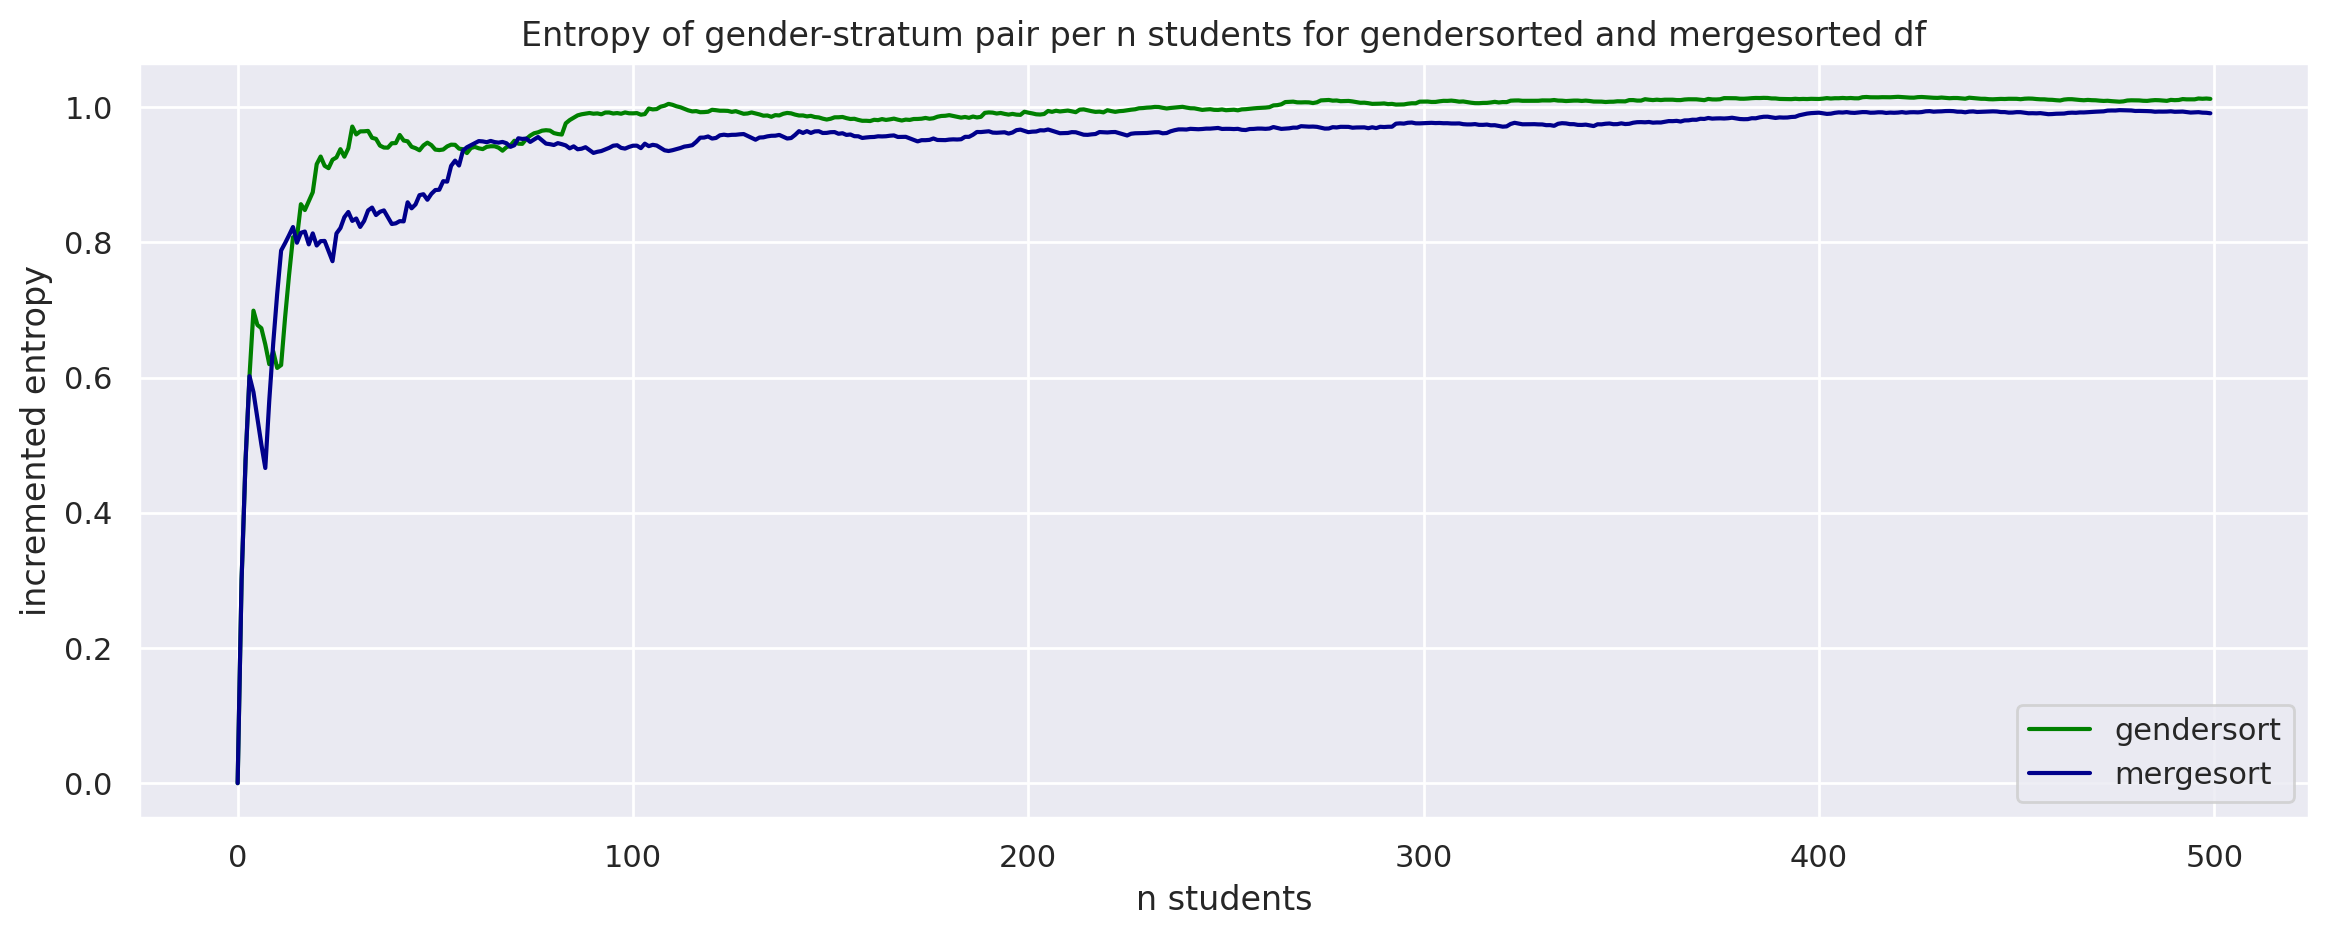

In [ ]:
#ENTROPY stratum-gender gender_sort and merge_sort

# Add new column of cumsum+1 to use for x-axis
gender_df["n_students"] = range(len(gender_df))
df_sort["n_students"] = range(len(df_sort)) 


# gendersort entropy of gender-stratum
sns.lineplot(x="n_students", y="entropy_col", data=gender_df[:500], color="green").set_title("Entropy of gender-stratum pair per n students for gendersorted and mergesorted df")

# mergesort entropy of gender-stratum
sns.lineplot(x="n_students", y="entropy_col", data=df_sort[:500], color="darkblue")

plt.xlabel('n students')
plt.ylabel('incremented entropy')

plt.legend(["gendersort", "mergesort"], loc ="lower right")

plt.show()

# Entropy of xgboost
## - With and without senstitive attributes

Inspect the plot by 200

### Stratum-gender entropy, both XGboosts

In [ ]:
df_xgb_wo


In [ ]:
# Function creating gender-startum pair = sg_pair
def sgpair_func(gen, strat):
    #combines startum number and binary gender number in a string:
    for i in range(1,7):
        if gen==1 and strat == "Stratum_{}".format(i):
            return "{}_1".format(i)
        elif gen==0 and strat == "Stratum_{}".format(i):
            return "{}_0".format(i)
        else:
            None

## XGBOOST with sensitive attributes            
            
#stratum gender pair column
df_xgb_vanilla["sg_pair"] = df_xgb_vanilla.apply(lambda x: sgpair_func(x['Gender_bins'], x['STRATUM']), axis=1)

#For each row incremented, get ratio of sg-pair(s) and add to df
data_value_counts = []
for i in range(1,len(df_xgb_vanilla)+1):
    data_value_counts.append(np.array([df_xgb_vanilla["sg_pair"][:i].value_counts(normalize=True)]))

df_xgb_vanilla["value_counts_col"] = data_value_counts

#For each row incremented, get entropy of sg-pair(s) and add to df
data_entropy = []
for i in range(len(df_xgb_vanilla)):
    data_entropy.append(-(df_xgb_vanilla["value_counts_col"][i]*np.log10(df_xgb_vanilla["value_counts_col"][i])).sum())


df_xgb_vanilla["entropy_col"] = data_entropy



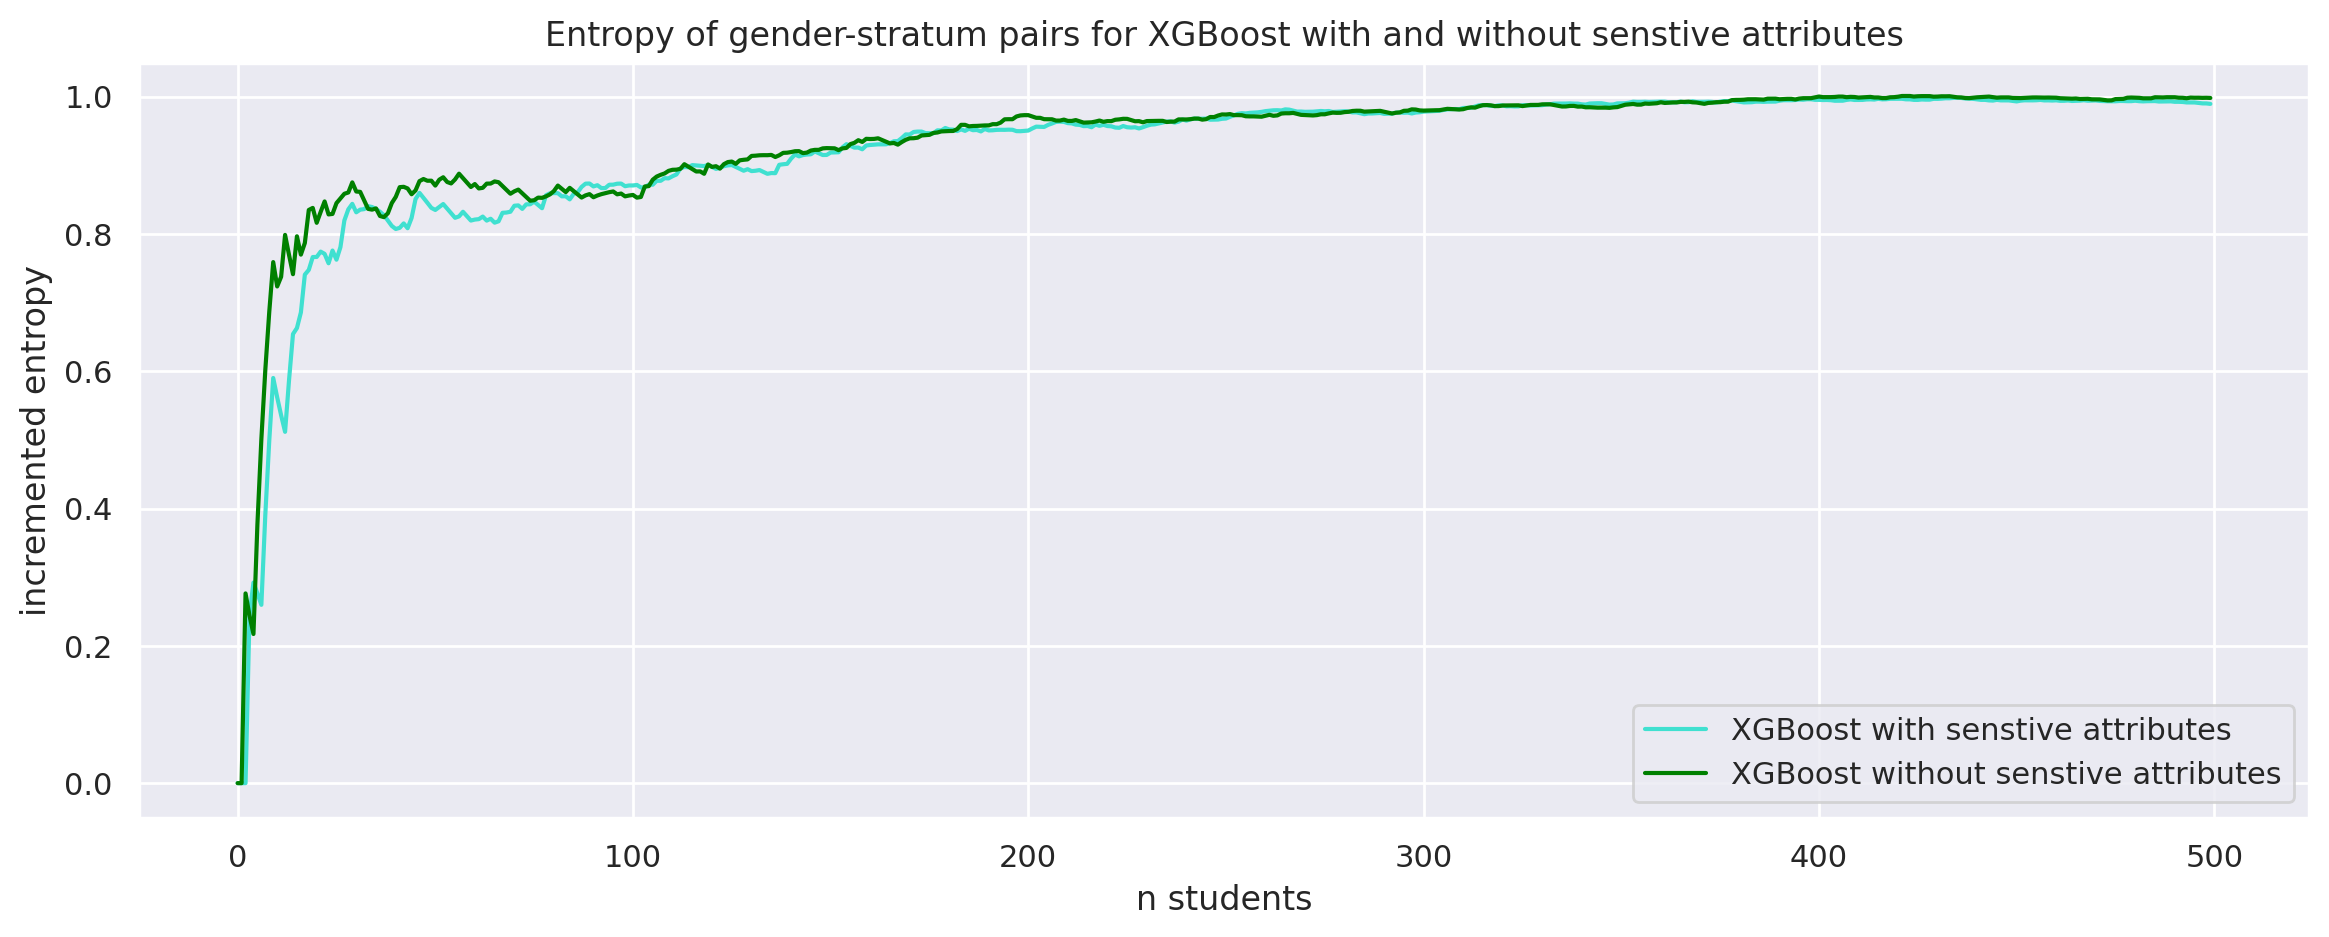

In [ ]:


## XGBOOST without sensitive attributes            

#stratum gender pair column
df_xgb_wo["sg_pair"] = df_xgb_wo.apply(lambda x: sgpair_func(x['Gender_bins'], x['STRATUM']), axis=1)

#For each row incremented, get ratio of sg-pair(s) and add to df
data_value_counts = []
for i in range(1,len(df_xgb_wo)+1):
    data_value_counts.append(np.array([df_xgb_wo["sg_pair"][:i].value_counts(normalize=True)]))

df_xgb_wo["value_counts_col"] = data_value_counts

#For each row incremented, get entropy of sg-pair(s) and add to df
data_entropy = []
for i in range(len(df_xgb_wo)):
    data_entropy.append(-(df_xgb_wo["value_counts_col"][i]*np.log10(df_xgb_wo["value_counts_col"][i])).sum())


df_xgb_wo["entropy_col"] = data_entropy



## PLOT TOGETHER

#apply new column of cumsum+1
df_xgb_vanilla["n_students"] = range(len(df_xgb_vanilla))
df_xgb_wo["n_students"] = range(len(df_xgb_wo))


# xgb entropy of gender-stratum
sns.lineplot(x="n_students", y="entropy_col", data=df_xgb_vanilla[:500], color="turquoise") #with
sns.lineplot(x="n_students", y="entropy_col", data=df_xgb_wo[:500], color="green") #without


plt.title("Entropy of gender-stratum pairs for XGBoost with and without senstive attributes")
plt.xlabel('n students')
plt.ylabel('incremented entropy')
x1,x2,y1,y2 = plt.axis()  
plt.axis((x1,x2,y1,1.05))
plt.legend(["XGBoost with senstive attributes", "XGBoost without senstive attributes"], loc ="lower right")

plt.show()



## All Gender entropies together

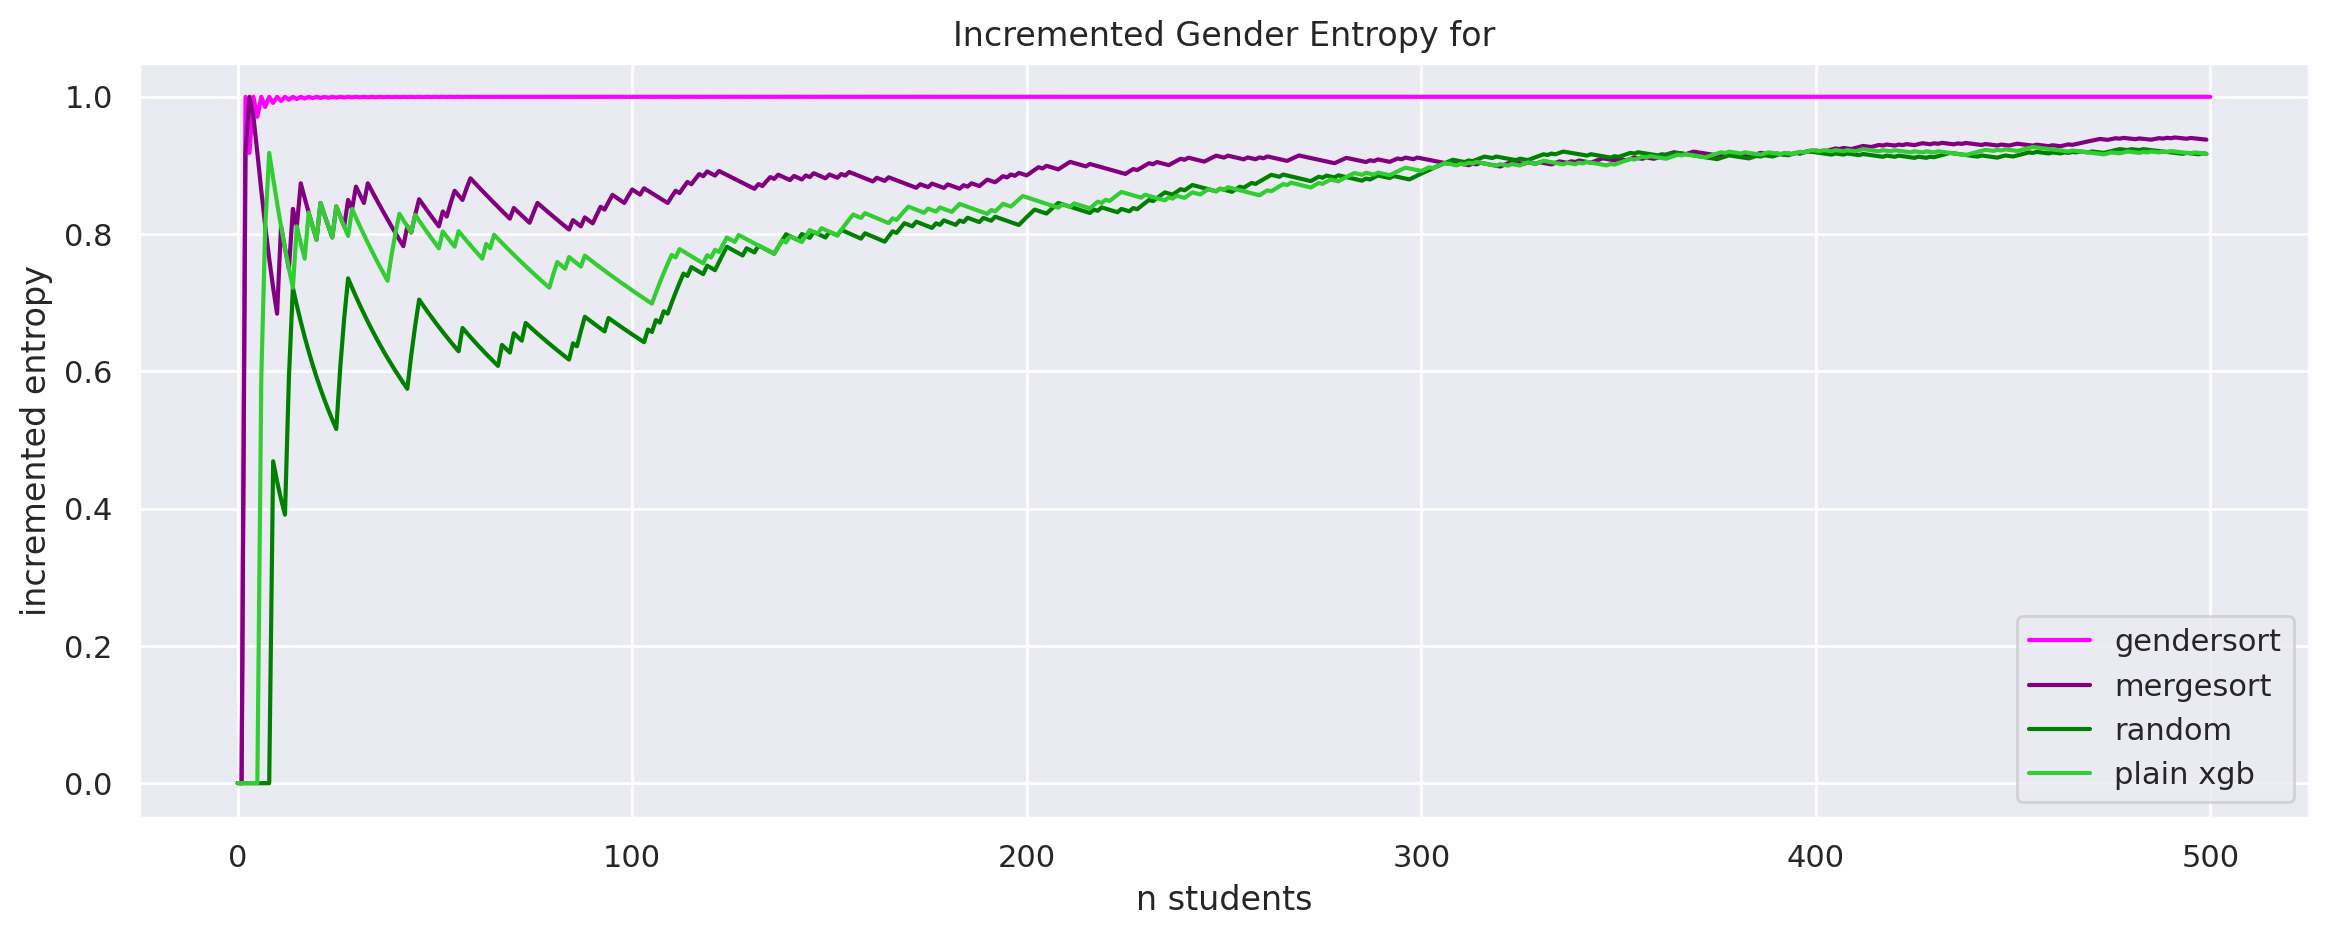

In [ ]:
#ENTROPY GENDER gender_sort and merge_sort and random

# list of colors: https://matplotlib.org/stable/gallery/color/named_colors.html

df_sort["n_students"] = range(len(df_sort))

sns.color_palette("deep")

# gendersort entropy of gender
sns.lineplot(x="n_students", y="entropy_col_GENDER", data=gender_df[:500], color="magenta")

# mergesort entropy of gender
sns.lineplot(x="n_students", y="entropy_col_GENDER", data=df_sort[:500], color="purple")

# randomsort entropy of gender
# sns.lineplot(data=df_random_use, x="n_students", y="entropy_col_GENDER", ci="sd", color="cornflowerblue") TODO: DENNE VIRKER IKKE

## XGBOOST

#apply new column of cumsum+1
df_xgb_vanilla["n_students"] = range(len(df_xgb_vanilla))
df_xgb_wo["n_students"] = range(len(df_xgb_wo))

# mergesort entropy of gender
sns.lineplot(x="n_students", y="entropy_col_GENDER", data=df_xgb_vanilla[:500], color="green") #with
sns.lineplot(x="n_students", y="entropy_col_GENDER", data=df_xgb_wo[:500], color="limegreen") #without


plt.title("Incremented Gender Entropy for")
plt.xlabel('n students')
plt.ylabel('incremented entropy')

plt.legend(["gendersort", "mergesort", "random", "plain xgb", "without sens. xgb"], loc ="lower right")



plt.show()

## All stratum-gender entropies together

In [ ]:
# ADD the other three baselines to the xgboost



# Add new column of cumsum+1 to use for x-axis
df_xgb_vanilla["n_students"] = range(len(df_xgb_vanilla))
df_xgb_wo["n_students"] = range(len(df_xgb_wo))
gender_df["n_students"] = range(len(gender_df))
df_sort["n_students"] = range(len(df_sort)) 



# gendersort and mergesort entropy of gender-stratum
sns.lineplot(x="n_students", y="entropy_col", data=gender_df[:500], color="magenta")
sns.lineplot(x="n_students", y="entropy_col", data=df_sort[:500], color="purple")
# xgb entropy of gender-stratum
sns.lineplot(x="n_students", y="entropy_col", data=df_xgb_vanilla[:500], color="green") #with
sns.lineplot(x="n_students", y="entropy_col", data=df_xgb_wo[:500], color="limegreen") #without



plt.title("Entropy of gender-stratum pairs for all baselines")
plt.xlabel('n students')
plt.ylabel('incremented entropy of gender-stratum')


x1,x2,y1,y2 = plt.axis()  
plt.axis((x1,x2,y1,1.05))
plt.legend(["gendersorted", "mergesort","XGBoost with senstive attributes", "XGBoost without senstive attributes"], loc ="lower right")

plt.show()